# dMdisk = 5e-9 * 5.972e27/3.154e7/150

In [1]:
load_dep = True

In [2]:
import numpy as np
import os 
from dedalus import public as de
from dedalus.extras.plot_tools import quad_mesh, pad_limits
import matplotlib.pyplot as plt
from scipy.special import erf 
import logging
logger = logging.getLogger(__name__)

%matplotlib inline

import time

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

from dedalus.extras import plot_tools 

In [3]:
a_1 = 1
AU = 1.496e13
Mp = 1 # Earth masses
T_disk = 300 *a_1**(-1/2)

rho_disk = 2.4e-9*a_1**(-11/4)
r_Hill = 2e11*a_1*(Mp)**(1/3)
r_Bondi = 4e10*a_1**(1/2)*Mp

print('disk temperature: ' + str(T_disk))
print('disk density: ' + str(rho_disk))
print('hill radius: {:.4e}'.format(r_Hill))
print('bondi radius: {:.4e}'.format(r_Bondi))

disk temperature: 300.0
disk density: 2.4e-09
hill radius: 2.0000e+11
bondi radius: 4.0000e+10


In [4]:
# Basis and domain

resolution = 256 #500
# normalization factors
r_0 = 1.2e8
T_0 = 1000
P_0 = 1 #1e5 #1
M_0 = 1e-12
m_0 = 1e25
L_0 = 3.144546892817586e+27
Dep_0 = 5.972e27/3.154e7 

# r_outer = 1.496e13/r_0
r_outer = r_Hill /r_0 # 3.4199512e11/r_0
r_inner = 1.2e9/r_0

log_inner = np.log(r_inner) 
log_outer = np.log(r_outer)

log_basis = de.Chebyshev('r', resolution, interval=(log_inner,log_outer))  
domain = de.Domain([log_basis], np.float64)

In [5]:
# Problem

ncc_cutoff = 1e-6 #1e-2
tolerance = 1e-6 #1e-2
# P and T are actually log(P) and log(T)
problem = de.NLBVP(domain,variables = ['lgP', 'lgT', 'lgM', 'lgZgr','m', 'L'], ncc_cutoff = ncc_cutoff)
R = np.log10(np.exp(domain.grid(0))*r_0)

In [6]:
# Parameters

problem.parameters['T_0'] = T_0 
problem.parameters['r_0'] = r_0
problem.parameters['P_0'] = P_0 # unused
problem.parameters['M_0'] = M_0
problem.parameters['m_0'] = m_0
problem.parameters['Dep_0'] = Dep_0
problem.parameters['L_0'] = L_0

lgP = domain.new_field(name='lgP')
lgT = domain.new_field(name='lgT')
lgZgr = domain.new_field(name='lgZgr')
lgM = domain.new_field(name='lgM')
m = domain.new_field(name='m')
L = domain.new_field(name='L')

r = domain.new_field(name='R')
r['g'] = domain.grid(0)
S = np.exp(r['g']) * r_0
ones = np.ones(len(r['g']))

pi = np.pi 
Core_mass = Mp*5.972e27
Mc = Core_mass # 5* mass of earth (in g)
mu = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
kb = 1.38064852e-16 # g*cm**2/(K*s**2)
G = 6.67408e-8 # cm**3/(g*s**2)
dMtot = 0.2*1e-5* 5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
sig = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
s0 = 1e-4 # cm
rho_o = 3 #g cm^-3 grain internal density
sigma_b = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
grad_rad_cst = - 3*dMtot/(64*np.pi*rcore*sig)
gm = G*Mc 

rhodisk = rho_disk # 7.5e-9 #g/cm**3
Tdisk = T_disk # 370 # kelvin

mdep = rho_o * 4/3 * pi *(1e4)**3
dMdisk = 5e-9 * 5.972e27/3.154e7/150


problem.parameters['pi'] = np.pi
problem.parameters['Mc'] = Core_mass 
problem.parameters['mu'] = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
problem.parameters['kb'] = 1.38064852e-16 # g*cm**2/(K*s**2)
problem.parameters['G'] = 6.67408e-8 # cm**3/(g*s**2)
problem.parameters['dMtot'] = 0.2*1e-5*5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
problem.parameters['sig'] = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
problem.parameters['s0'] = 1e-4 # cm
problem.parameters['rho_o'] = 3 #g cm^-3 grain internal density
problem.parameters['mdep'] = problem.parameters['rho_o']*4/3*np.pi*(1e-4)**(3)
problem.parameters['sigma_b'] = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
problem.parameters['grad_rad_cst'] = - 3*problem.parameters['dMtot']/(64*np.pi*rcore*problem.parameters['sig'])


# problem.parameters['rhodisk'] = 4e-9 # 1e-11 #g/cm**3
# problem.parameters['Tdisk'] = 370 # 150 # kelvin

problem.parameters['rhodisk'] = rhodisk #g/cm**3
problem.parameters['Tdisk'] = Tdisk # kelvin

problem.substitutions['s'] = '(exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)' # radius
s = (np.exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)


# Deposition Type (3 versions) 

-24.124463218608565


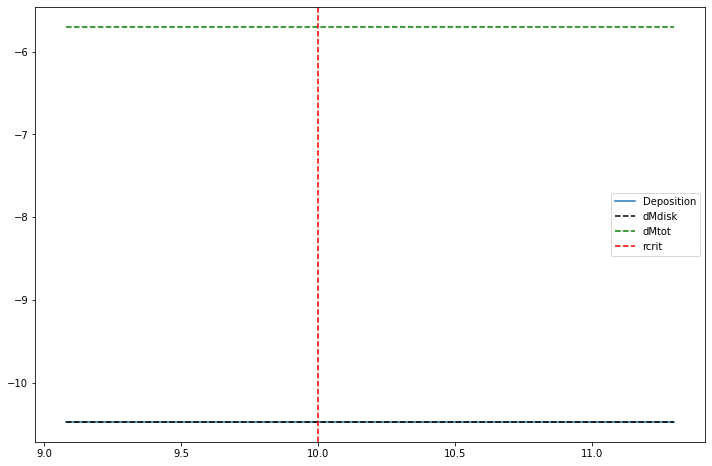

In [7]:
# # Mass deposition 
deposition_version = 'null'

if deposition_version == 0:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.loadtxt('M1dep.txt')

    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    Mdep_fixed = lgdM['g']
    dlgdM_fixed = dlgdM['g']
    n_roll = Mdep_fixed.shape[0]//4
    Mdep_fixed_rolled =np.roll(Mdep_fixed, n_roll)
    dlgdM_fixed_rolled = np.roll(dlgdM_fixed, n_roll)

    # Correct leftmost values too low from wrapping around
    Mdep_fixed_rolled[:n_roll] = Mdep_fixed[0]
    dlgdM_fixed_rolled[:n_roll] = 0. # Zero gradient for constant value correction

    ones = lgdM['g']/lgdM['g']

    constant = np.log(ones*1e-5)
    dconstant = 0.*ones

    lgdM['g'] = Mdep_fixed_rolled
    dlgdM['g'] = dlgdM_fixed_rolled

    

elif deposition_version == 1:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log(np.loadtxt('Deposition.txt')/Dep_0)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()

# elif deposition_version=='None':
#     lgdM = domain.new_field(name='lgdM')
#     lgdM['g'] = np.log(np.loadtxt('Deposition.txt')/Dep_0)
#     d_r = log_basis.Differentiate(lgdM)
#     dlgdM = d_r.evaluate()

elif deposition_version=='null':
    location = 10 # in log10 
    smooth = 3
    X = r['g'] - np.log(10**location/r_0) 
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = X*0
    lgdM['g'] = lgdM['g']+np.log(dMdisk/Dep_0)
    print(np.log(dMdisk/Dep_0))
    # DEP = dMdisk + (dMtot-dMdisk)*((erf(smooth*eX['g']) + 1)/2)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()

else:
    location = 10 # in log10 
    smooth = 3
    X = r['g'] - np.log(10**location/r_0) 
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log((dMdisk + (dMtot-dMdisk)*((-erf(smooth*X) + 1)/2))/Dep_0)    
    # DEP = dMdisk + (dMtot-dMdisk)*((erf(smooth*eX['g']) + 1)/2)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    
problem.parameters['lgDep'] = lgdM
problem.parameters['dlgDep'] = dlgdM

lgDep = domain.new_field(name='lgDep')
dlgDep = domain.new_field(name='dlgDep')
lgDep['g'] = lgdM['g']
dlgDep['g'] = dlgdM['g']

plt.figure(figsize=(12,8))
plt.plot(R, np.log10(np.exp(lgdM['g'])), label='Deposition')
plt.plot(R, np.log10(ones*dMdisk/Dep_0), 'k--', label='dMdisk')
plt.plot(R, np.log10(ones*dMtot/Dep_0), 'g--', label='dMtot')
if deposition_version != 1 and deposition_version !=0:
    plt.axvline(location, color = 'r', ls='--', label='rcrit')
plt.legend()
# plt.plot(R, np.log10(np.exp(dlgdM['g'])))

In [8]:
# Opacity

problem.substitutions['x'] = '2*pi*s*0.3/0.2898'
x = 2*pi*s*0.3/0.2898

# min(2,ex*T*T_0) 
k0 = -10. # -30.
problem.parameters['k0'] = k0

problem.substitutions['Qe'] = "(0.5*(2**k0 + (x*exp(lgT)*T_0)**k0))**(1/k0)"
Qe = (0.5*(2**k0 + (x*np.exp(lgT)*T_0)**k0))**(1/k0)

problem.substitutions['Qk_geo'] = "Qe*3/4*exp(lgZgr)/(s*rho_o)" 
Qk_geo = Qe*3/4*np.exp(lgZgr)/(s*rho_o)

k_gas_cst = 1e-8*(problem.parameters["mu"]/problem.parameters['kb'])**(2/3) # O(10^-14)
problem.parameters['k_gas_cst'] = k_gas_cst

problem.substitutions['k_gas'] = "k_gas_cst*(exp(lgT)*T_0)**(7/3)*(exp(lgP)*P_0)**(2/3)" 
k_gas = k_gas_cst*(np.exp(lgT)*T_0)**(7/3)*(np.exp(lgP)*P_0)**(2/3)

problem.substitutions['kappa'] = "k_gas + Qk_geo"
kappa = k_gas + Qk_geo 

In [9]:
# Gradient  


# problem.substitutions['grad_rad'] = "grad_rad_cst*kappa*exp(lgP)*P_0/(exp(lgT)*T_0)**4"

grad_ad = 0.28
problem.parameters['grad_ad'] = grad_ad


# problem.substitutions['grad_rad'] = '-3*kappa*exp(L)*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
problem.substitutions['grad_rad'] = '3*kappa*L*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
grad_rad = 3*kappa*L*L_0/(64*pi*sigma_b*gm) * np.exp(lgP)*P_0/(np.exp(lgT)*T_0)**4


# min
k1 = -10. # -30.
problem.parameters['k1'] = k1
problem.substitutions['grad'] = "(0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)" 
grad = (0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)

In [10]:
# Tstop: v_set = gm/r^2 * Tstop 

gm = problem.parameters['Mc']*problem.parameters['G']
problem.parameters['gm'] = gm

problem.substitutions['rho_g'] = '(exp(lgP)*P_0*mu)/(kb*exp(lgT)*T_0)'
rho_g = (np.exp(lgP)*P_0*mu)/(kb*np.exp(lgT)*T_0)

problem.substitutions['cg'] = 'sqrt(kb*exp(lgT)*T_0/mu)'
cg = np.sqrt(kb*np.exp(lgT)*T_0/mu)

problem.substitutions['Lg'] = '1e-9/rho_g'
Lg = 1e-9/rho_g

l = 30 #1 #15
problem.parameters['l'] = l

problem.substitutions['max'] = "(0.5*(1 + (9/4*s/Lg)**l))**(1/l)"
Max = (0.5*(1 + (s/Lg)**l))**(1/l)


problem.substitutions['Tstop'] = '(max*4*rho_o*s)/(9*cg*rho_g)'
Tstop = (Max*4*rho_o*s)/(9*cg*rho_g)

problem.substitutions['v_set'] = 'gm*Tstop/(exp(r)*r_0)**2'
v_set = gm*Tstop/(np.exp(r)*r_0)**2

In [11]:
# Tgrow 

problem.substitutions['v_bm'] = 'sqrt(16*kb*exp(lgT)*T_0/(pi*exp(lgM)*M_0))'
v_bm = np.sqrt(16*kb*np.exp(lgT)*T_0/(np.pi*np.exp(lgM)*M_0))

problem.substitutions['v_dd'] = '0.1*v_set'
v_dd = 0.1*v_set

problem.substitutions['Tgrow_inv'] = '3*exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)'
Tgrow_inv = 3*np.exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)

In [12]:
# Energy equation

# problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**2) * dlgDep * 1e5'
problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**3) * dlgDep * Dep_0 * exp(lgDep)'
drho_dep = -1/(4*pi*(np.exp(r)*r_0)**3) * dlgDep * Dep_0 * np.exp(lgDep)

Trelax = 1e30
problem.parameters['Trelax'] = Trelax

Lcore = problem.parameters['gm']*problem.parameters['dMtot']/(r_inner*r_0)
problem.parameters['Lcore'] = Lcore
print(problem.parameters['Lcore'])

1.2578187571270345e+26


In [13]:
# New equations

problem.add_equation('lgZgr = log(exp(lgDep)*Dep_0/(4*pi*gm*Tstop*rho_g))')
# problem.add_equation('lgZgr = log(dMdep/(4*pi*gm*Tstop*rho_g))')
problem.add_equation('dr(lgM) = -Tgrow_inv*(exp(r)*r_0)**3/(gm*Tstop) + dlgDep*(mdep-exp(lgM)*M_0)/(exp(lgM)*M_0)')

In [14]:
# Normalized equations

# problem.parameters['eq1cst'] = -1*problem.parameters['G']*problem.parameters['Mc']*problem.parameters['mu']/(T_0*r_0*problem.parameters['kb'])
problem.add_equation('dr(m) = 4*pi*(exp(r)*r_0)**3 * rho_g/m_0')
problem.add_equation('exp(r) * dr(lgP) = -G*(Mc+m*m_0)*mu/(T_0*r_0*kb*exp(lgT))')
problem.add_equation('dr(lgT) = dr(lgP)*grad')

# problem.add_equation('dr(L) = 4*pi*(exp(r)*r_0)* (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0))')
# problem.add_equation('dr(L)*L_0 = 4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax )')
problem.add_equation('dr(L)*L_0 = (4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax ))')


In [15]:
# Boundary Equations


problem.add_bc("right(lgT) = log(Tdisk/T_0)") # disk temp in kelvins
problem.add_bc("right(lgP) = log(rhodisk*kb*Tdisk/mu/P_0)") # gas law
problem.add_bc("right(lgZgr) = log(1e-3)")
problem.add_bc("left(m) = 0")
problem.add_bc("left(L) = Lcore/L_0")

In [16]:
# solver = problem.build_solver(de.timesteppers.RK443)
solver = problem.build_solver()

2020-11-16 03:01:29,520 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


Text(0.5, 1.0, 'm')

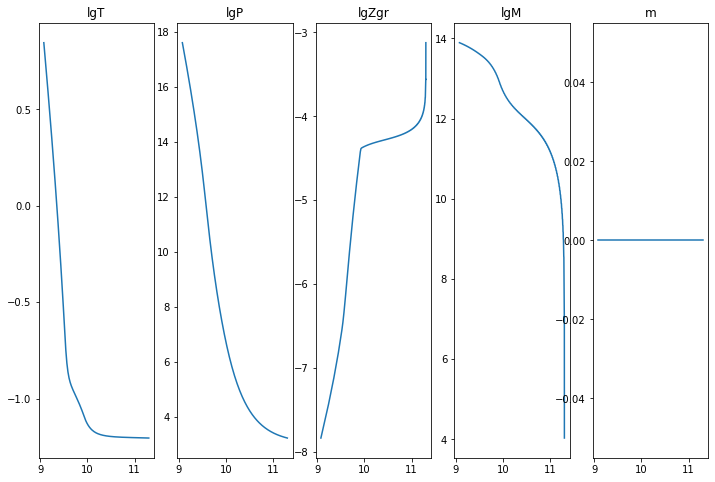

In [17]:
# initial conditions and referencing local grid state fields

lgr = domain.grid(0)
Rscale = np.log10(np.exp(domain.grid(0))*r_0)
lgT1 = solver.state['lgT']
lgP1 = solver.state['lgP']
lgZgr1 = solver.state['lgZgr']
lgM1 = solver.state['lgM']

L1 = solver.state['L']
m1= solver.state['m']

# Load from constant Mass and Zgr version

lgP_initial = np.loadtxt("Pressure.txt")
lgT_initial = np.loadtxt("Temperature.txt")
Zi = np.loadtxt('Zgr.txt')
Mi = np.loadtxt('M.txt')

lgP1['g'] = lgP_initial
lgT1['g'] = lgT_initial
ones = lgT1['g']/lgT1['g']

L1['g'] = ones*problem.parameters['Lcore']/L_0

lgZgr1['g'] = Zi 

lgM1['g'] = Mi
m1['g'] = ones*0


if load_dep: 
    lgP1['g'] = np.loadtxt("NPressure_dep.txt")
    lgT1['g'] = np.loadtxt("NTemperature_dep.txt")
    L1['g'] = np.loadtxt('NL_dep.txt')
    lgZgr1['g'] = np.loadtxt('NZgr_dep.txt') 
    lgM1['g'] = np.loadtxt('NM_dep.txt')
    m1['g'] = np.loadtxt('Nm_dep.txt')
    
    
plt.figure(figsize=(12,8))
plt.subplot(1,5,1)
plt.plot(Rscale,lgT1['g'])
plt.title("lgT")
plt.subplot(1,5,2)
plt.plot(Rscale, lgP1['g'])
plt.title("lgP")
plt.subplot(1,5,3)
plt.plot(Rscale, np.log10(np.exp(lgZgr1['g'])))
plt.title("lgZgr")
plt.subplot(1,5,4)
plt.plot(Rscale, lgM1['g'])
plt.title("lgM")
plt.subplot(1,5,5)
plt.plot(Rscale, m1['g'])
plt.title("m")

In [18]:

lgT_list = [np.copy(lgT1['g'])]
lgP_list = [np.copy(lgP1['g'])]
lgZgr_list = [np.copy(lgZgr1['g'])]
lgM_list = [np.copy(lgM1['g'])]
m_list = [np.copy(m1['g'])]
L_list = [np.copy(L1['g'])]

2020-11-16 03:01:35,209 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s
2020-11-16 03:01:36,232 __main__ 0/1 INFO :: Perturbation norm: 11.804005467485363
2020-11-16 03:01:36,233 __main__ 0/1 INFO :: lgT iterate: 0.8438716405327306
2020-11-16 03:01:36,234 __main__ 0/1 INFO :: lgP iterate: 17.555340354005626
2020-11-16 03:01:36,235 __main__ 0/1 INFO :: lgM iterate: 13.640462863115953
2020-11-16 03:01:36,236 __main__ 0/1 INFO :: lgZgr iterate: -18.044838307922376
2020-11-16 03:01:36,237 __main__ 0/1 INFO :: m iterate: 5.315726706811574e-05
2020-11-16 03:01:36,238 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


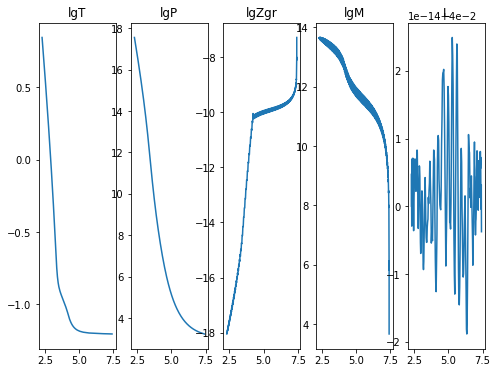

2020-11-16 03:01:40,697 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:01:41,383 __main__ 0/1 INFO :: Perturbation norm: 1.623311122756209
2020-11-16 03:01:41,384 __main__ 0/1 INFO :: lgT iterate: 0.8459357157552982
2020-11-16 03:01:41,388 __main__ 0/1 INFO :: lgP iterate: 17.607298813172058
2020-11-16 03:01:41,389 __main__ 0/1 INFO :: lgM iterate: 13.636139527601166
2020-11-16 03:01:41,393 __main__ 0/1 INFO :: lgZgr iterate: -18.090857119418473
2020-11-16 03:01:41,394 __main__ 0/1 INFO :: m iterate: 5.6146178311067274e-05
2020-11-16 03:01:41,398 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


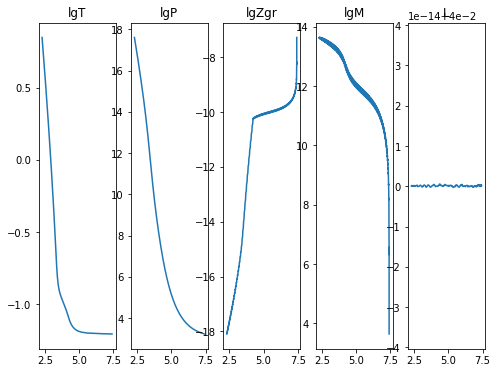

2020-11-16 03:01:45,928 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:01:46,801 __main__ 0/1 INFO :: Perturbation norm: 1.2412244417455418
2020-11-16 03:01:46,803 __main__ 0/1 INFO :: lgT iterate: 0.8462409683727469
2020-11-16 03:01:46,803 __main__ 0/1 INFO :: lgP iterate: 17.618095265408677
2020-11-16 03:01:46,805 __main__ 0/1 INFO :: lgM iterate: 13.646067909675871
2020-11-16 03:01:46,805 __main__ 0/1 INFO :: lgZgr iterate: -18.107833349321005
2020-11-16 03:01:46,806 __main__ 0/1 INFO :: m iterate: 5.7349248808513664e-05
2020-11-16 03:01:46,807 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


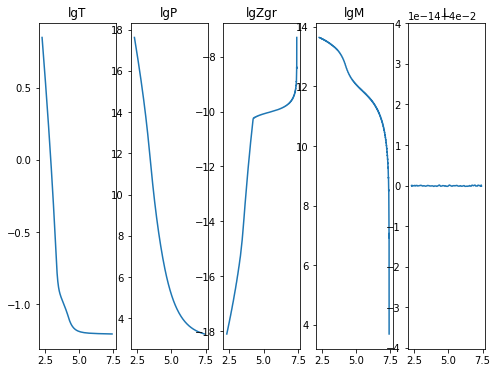

2020-11-16 03:01:51,898 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s
2020-11-16 03:01:53,129 __main__ 0/1 INFO :: Perturbation norm: 1.8912624977275838
2020-11-16 03:01:53,130 __main__ 0/1 INFO :: lgT iterate: 0.8450432196886338
2020-11-16 03:01:53,131 __main__ 0/1 INFO :: lgP iterate: 17.58346755554447
2020-11-16 03:01:53,133 __main__ 0/1 INFO :: lgM iterate: 13.639035825271785
2020-11-16 03:01:53,134 __main__ 0/1 INFO :: lgZgr iterate: -18.07030812712863
2020-11-16 03:01:53,135 __main__ 0/1 INFO :: m iterate: 5.524972476766976e-05
2020-11-16 03:01:53,137 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


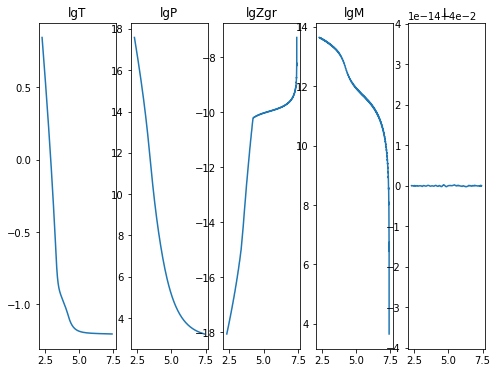

2020-11-16 03:01:58,133 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s
2020-11-16 03:01:59,189 __main__ 0/1 INFO :: Perturbation norm: 1.718208887218482
2020-11-16 03:01:59,190 __main__ 0/1 INFO :: lgT iterate: 0.8456344733237319
2020-11-16 03:01:59,191 __main__ 0/1 INFO :: lgP iterate: 17.599011082782933
2020-11-16 03:01:59,192 __main__ 0/1 INFO :: lgM iterate: 13.641282164213022
2020-11-16 03:01:59,192 __main__ 0/1 INFO :: lgZgr iterate: -18.08646626740933
2020-11-16 03:01:59,193 __main__ 0/1 INFO :: m iterate: 5.603953254063043e-05
2020-11-16 03:01:59,194 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


2020-11-16 03:02:04,583 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s
2020-11-16 03:02:06,568 __main__ 0/1 INFO :: Perturbation norm: 1.8871109731602762
2020-11-16 03:02:06,570 __main__ 0/1 INFO :: lgT iterate: 0.8449129004792804
2020-11-16 03:02:06,571 __main__ 0/1 INFO :: lgP iterate: 17.58109799393209
2020-11-16 03:02:06,572 __main__ 0/1 INFO :: lgM iterate: 13.640705072788837
2020-11-16 03:02:06,573 __main__ 0/1 INFO :: lgZgr iterate: -18.069244928731514
2020-11-16 03:02:06,574 __main__ 0/1 INFO :: m iterate: 5.503125689898525e-05
2020-11-16 03:02:06,575 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


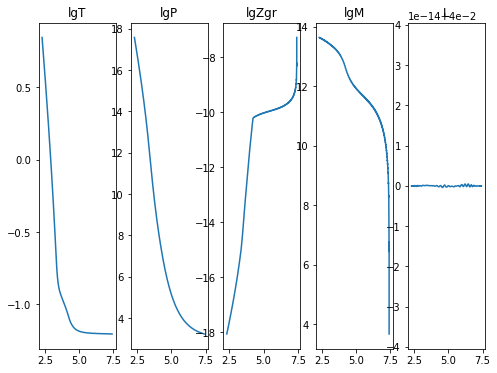

2020-11-16 03:02:11,872 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:02:13,101 __main__ 0/1 INFO :: Perturbation norm: 1.7740080893729657
2020-11-16 03:02:13,106 __main__ 0/1 INFO :: lgT iterate: 0.8455212376367925
2020-11-16 03:02:13,111 __main__ 0/1 INFO :: lgP iterate: 17.595993682059714
2020-11-16 03:02:13,114 __main__ 0/1 INFO :: lgM iterate: 13.640856220123759
2020-11-16 03:02:13,117 __main__ 0/1 INFO :: lgZgr iterate: -18.083334499749625
2020-11-16 03:02:13,120 __main__ 0/1 INFO :: m iterate: 5.5826872516817616e-05
2020-11-16 03:02:13,124 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


2020-11-16 03:02:18,050 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:02:19,141 __main__ 0/1 INFO :: Perturbation norm: 1.7351336835553468
2020-11-16 03:02:19,142 __main__ 0/1 INFO :: lgT iterate: 0.8449398415998224
2020-11-16 03:02:19,143 __main__ 0/1 INFO :: lgP iterate: 17.581825333521703
2020-11-16 03:02:19,144 __main__ 0/1 INFO :: lgM iterate: 13.641188698518402
2020-11-16 03:02:19,145 __main__ 0/1 INFO :: lgZgr iterate: -18.070255011505154
2020-11-16 03:02:19,146 __main__ 0/1 INFO :: m iterate: 5.5054796430198394e-05
2020-11-16 03:02:19,147 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


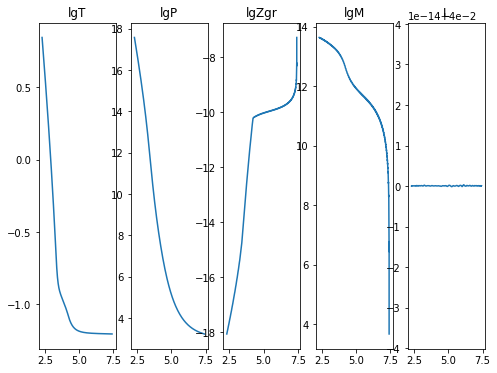

2020-11-16 03:02:23,859 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:02:24,774 __main__ 0/1 INFO :: Perturbation norm: 1.728635575932524
2020-11-16 03:02:24,775 __main__ 0/1 INFO :: lgT iterate: 0.8455471415360222
2020-11-16 03:02:24,776 __main__ 0/1 INFO :: lgP iterate: 17.596703188709743
2020-11-16 03:02:24,777 __main__ 0/1 INFO :: lgM iterate: 13.641139796263552
2020-11-16 03:02:24,778 __main__ 0/1 INFO :: lgZgr iterate: -18.08419428860476
2020-11-16 03:02:24,779 __main__ 0/1 INFO :: m iterate: 5.58705743713972e-05
2020-11-16 03:02:24,780 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


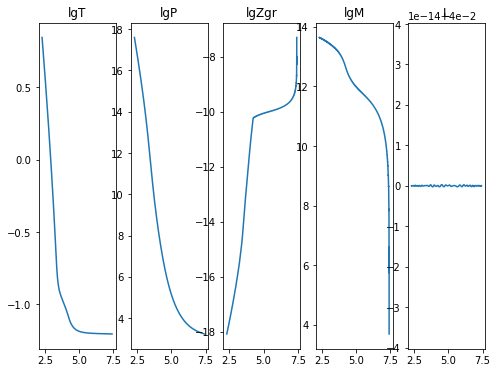

2020-11-16 03:02:29,551 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:02:31,097 __main__ 0/1 INFO :: Perturbation norm: 1.7193657422756767
2020-11-16 03:02:31,102 __main__ 0/1 INFO :: lgT iterate: 0.8449351510551535
2020-11-16 03:02:31,107 __main__ 0/1 INFO :: lgP iterate: 17.581688468138335
2020-11-16 03:02:31,111 __main__ 0/1 INFO :: lgM iterate: 13.641111638392978
2020-11-16 03:02:31,114 __main__ 0/1 INFO :: lgZgr iterate: -18.07007363801836
2020-11-16 03:02:31,118 __main__ 0/1 INFO :: m iterate: 5.5049296096676414e-05
2020-11-16 03:02:31,122 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


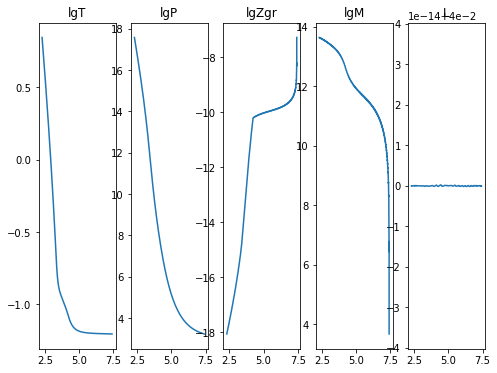

2020-11-16 03:02:36,205 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:02:37,449 __main__ 0/1 INFO :: Perturbation norm: 1.729293616352249
2020-11-16 03:02:37,453 __main__ 0/1 INFO :: lgT iterate: 0.8455546503180646
2020-11-16 03:02:37,456 __main__ 0/1 INFO :: lgP iterate: 17.596885291394862
2020-11-16 03:02:37,457 __main__ 0/1 INFO :: lgM iterate: 13.641152119643477
2020-11-16 03:02:37,458 __main__ 0/1 INFO :: lgZgr iterate: -18.08437333163566
2020-11-16 03:02:37,468 __main__ 0/1 INFO :: m iterate: 5.58810977357993e-05
2020-11-16 03:02:37,471 __main__ 0/1 INFO :: L iterate: 0.04


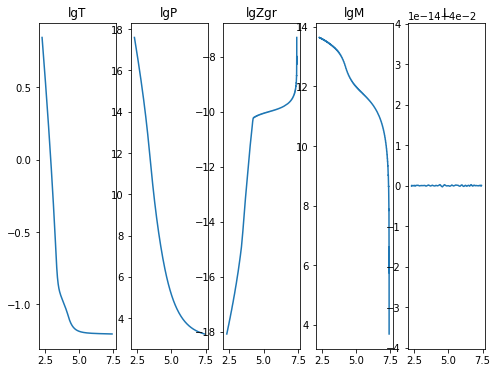

2020-11-16 03:02:43,331 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:02:44,878 __main__ 0/1 INFO :: Perturbation norm: 1.7358302290920153
2020-11-16 03:02:44,879 __main__ 0/1 INFO :: lgT iterate: 0.844930308861432
2020-11-16 03:02:44,880 __main__ 0/1 INFO :: lgP iterate: 17.58156771890326
2020-11-16 03:02:44,881 __main__ 0/1 INFO :: lgM iterate: 13.64106964429561
2020-11-16 03:02:44,882 __main__ 0/1 INFO :: lgZgr iterate: -18.06993205474869
2020-11-16 03:02:44,883 __main__ 0/1 INFO :: m iterate: 5.504346726592502e-05
2020-11-16 03:02:44,883 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


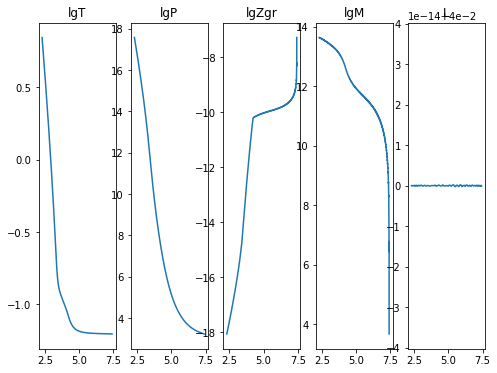

2020-11-16 03:02:50,929 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 03:02:54,333 __main__ 0/1 INFO :: Perturbation norm: 1.737484744335208
2020-11-16 03:02:54,334 __main__ 0/1 INFO :: lgT iterate: 0.8455524967834175
2020-11-16 03:02:54,339 __main__ 0/1 INFO :: lgP iterate: 17.596822737729983
2020-11-16 03:02:54,340 __main__ 0/1 INFO :: lgM iterate: 13.641120142164212
2020-11-16 03:02:54,345 __main__ 0/1 INFO :: lgZgr iterate: -18.08429267634053
2020-11-16 03:02:54,355 __main__ 0/1 INFO :: m iterate: 5.587684805696824e-05
2020-11-16 03:02:54,362 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


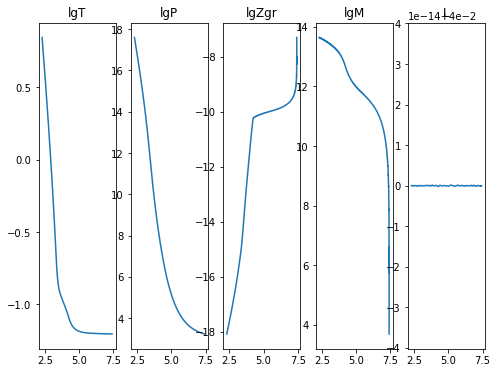

2020-11-16 03:03:01,431 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:03:03,714 __main__ 0/1 INFO :: Perturbation norm: 1.7400071868293918
2020-11-16 03:03:03,715 __main__ 0/1 INFO :: lgT iterate: 0.8449297578008887
2020-11-16 03:03:03,716 __main__ 0/1 INFO :: lgP iterate: 17.581556395529937
2020-11-16 03:03:03,722 __main__ 0/1 INFO :: lgM iterate: 13.641073109613622
2020-11-16 03:03:03,723 __main__ 0/1 INFO :: lgZgr iterate: -18.069923868376414
2020-11-16 03:03:03,724 __main__ 0/1 INFO :: m iterate: 5.504259826238922e-05
2020-11-16 03:03:03,725 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


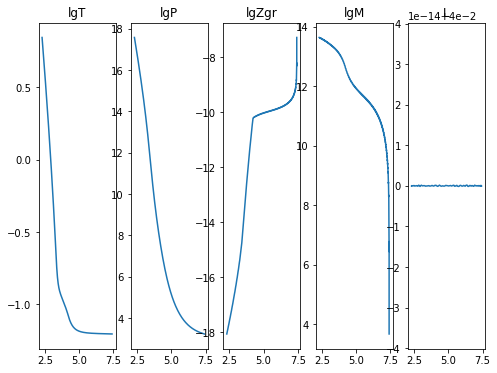

2020-11-16 03:03:10,655 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:03:12,441 __main__ 0/1 INFO :: Perturbation norm: 1.7396891036532065
2020-11-16 03:03:12,442 __main__ 0/1 INFO :: lgT iterate: 0.8455519325106234
2020-11-16 03:03:12,443 __main__ 0/1 INFO :: lgP iterate: 17.59680801320975
2020-11-16 03:03:12,448 __main__ 0/1 INFO :: lgM iterate: 13.641114834885837
2020-11-16 03:03:12,449 __main__ 0/1 INFO :: lgZgr iterate: -18.08427525781609
2020-11-16 03:03:12,450 __main__ 0/1 INFO :: m iterate: 5.587587200750477e-05
2020-11-16 03:03:12,451 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


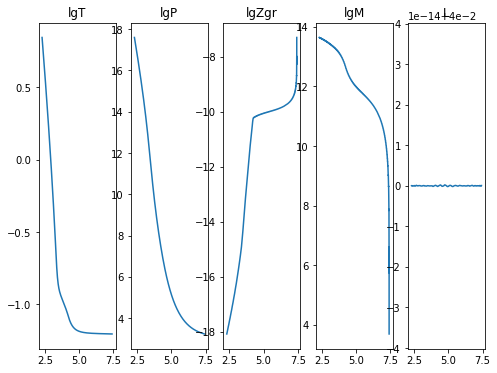

2020-11-16 03:03:19,098 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:03:20,820 __main__ 0/1 INFO :: Perturbation norm: 1.7398732059363622
2020-11-16 03:03:20,821 __main__ 0/1 INFO :: lgT iterate: 0.8449299039149171
2020-11-16 03:03:20,823 __main__ 0/1 INFO :: lgP iterate: 17.581560156404134
2020-11-16 03:03:20,836 __main__ 0/1 INFO :: lgM iterate: 13.641075899833506
2020-11-16 03:03:20,837 __main__ 0/1 INFO :: lgZgr iterate: -18.06992927522265
2020-11-16 03:03:20,839 __main__ 0/1 INFO :: m iterate: 5.504273037892915e-05
2020-11-16 03:03:20,846 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


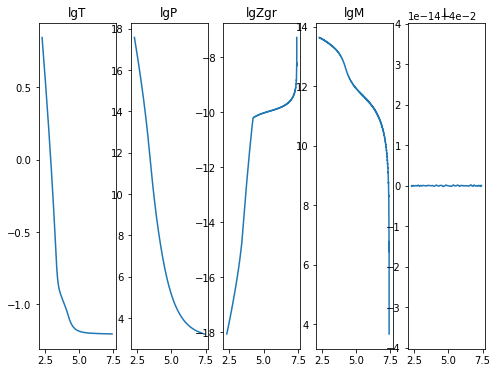

2020-11-16 03:03:27,680 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:03:29,867 __main__ 0/1 INFO :: Perturbation norm: 1.7399666314259963
2020-11-16 03:03:29,873 __main__ 0/1 INFO :: lgT iterate: 0.8455521995468119
2020-11-16 03:03:29,874 __main__ 0/1 INFO :: lgP iterate: 17.596815187936066
2020-11-16 03:03:29,875 __main__ 0/1 INFO :: lgM iterate: 13.641116158855201
2020-11-16 03:03:29,876 __main__ 0/1 INFO :: lgZgr iterate: -18.084282914675143
2020-11-16 03:03:29,877 __main__ 0/1 INFO :: m iterate: 5.5876312383240645e-05
2020-11-16 03:03:29,878 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


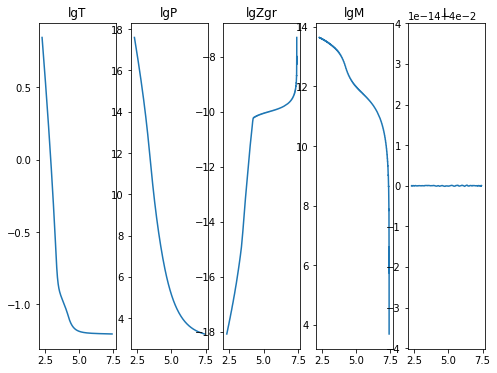

2020-11-16 03:03:36,706 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:03:39,214 __main__ 0/1 INFO :: Perturbation norm: 1.7400598676250658
2020-11-16 03:03:39,221 __main__ 0/1 INFO :: lgT iterate: 0.8449298487482131
2020-11-16 03:03:39,225 __main__ 0/1 INFO :: lgP iterate: 17.581558562772358
2020-11-16 03:03:39,229 __main__ 0/1 INFO :: lgM iterate: 13.641075200664249
2020-11-16 03:03:39,234 __main__ 0/1 INFO :: lgZgr iterate: -18.069927296717815
2020-11-16 03:03:39,238 __main__ 0/1 INFO :: m iterate: 5.504266865230534e-05
2020-11-16 03:03:39,241 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


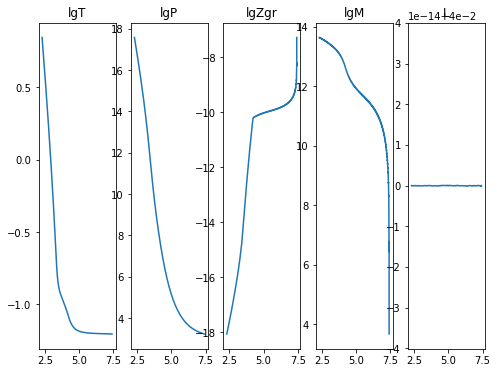

2020-11-16 03:03:45,824 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 03:03:48,326 __main__ 0/1 INFO :: Perturbation norm: 1.7401953024952894
2020-11-16 03:03:48,327 __main__ 0/1 INFO :: lgT iterate: 0.8455522978200494
2020-11-16 03:03:48,328 __main__ 0/1 INFO :: lgP iterate: 17.59681761618782
2020-11-16 03:03:48,329 __main__ 0/1 INFO :: lgM iterate: 13.641116078659836
2020-11-16 03:03:48,330 __main__ 0/1 INFO :: lgZgr iterate: -18.084285141776203
2020-11-16 03:03:48,331 __main__ 0/1 INFO :: m iterate: 5.587645433191568e-05
2020-11-16 03:03:48,332 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


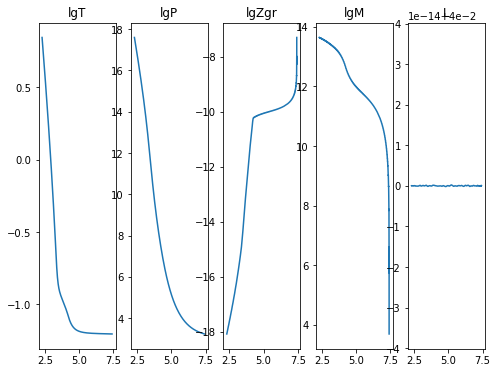

2020-11-16 03:03:53,390 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:03:55,737 __main__ 0/1 INFO :: Perturbation norm: 1.7403149473999104
2020-11-16 03:03:55,739 __main__ 0/1 INFO :: lgT iterate: 0.8449297904592006
2020-11-16 03:03:55,740 __main__ 0/1 INFO :: lgP iterate: 17.581557083998696
2020-11-16 03:03:55,741 __main__ 0/1 INFO :: lgM iterate: 13.641074744668977
2020-11-16 03:03:55,742 __main__ 0/1 INFO :: lgZgr iterate: -18.069925600247668
2020-11-16 03:03:55,743 __main__ 0/1 INFO :: m iterate: 5.504259761401897e-05
2020-11-16 03:03:55,744 __main__ 0/1 INFO :: L iterate: 0.04


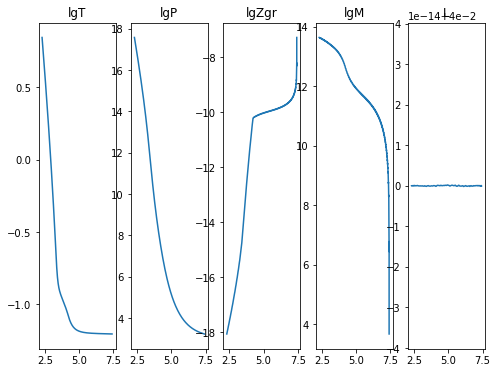

2020-11-16 03:04:00,728 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s
2020-11-16 03:04:03,026 __main__ 0/1 INFO :: Perturbation norm: 1.7403569921206943
2020-11-16 03:04:03,027 __main__ 0/1 INFO :: lgT iterate: 0.8455522979757769
2020-11-16 03:04:03,028 __main__ 0/1 INFO :: lgP iterate: 17.59681753951683
2020-11-16 03:04:03,029 __main__ 0/1 INFO :: lgM iterate: 13.64111572441304
2020-11-16 03:04:03,030 __main__ 0/1 INFO :: lgZgr iterate: -18.084284828494262
2020-11-16 03:04:03,031 __main__ 0/1 INFO :: m iterate: 5.5876443893154715e-05
2020-11-16 03:04:03,032 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


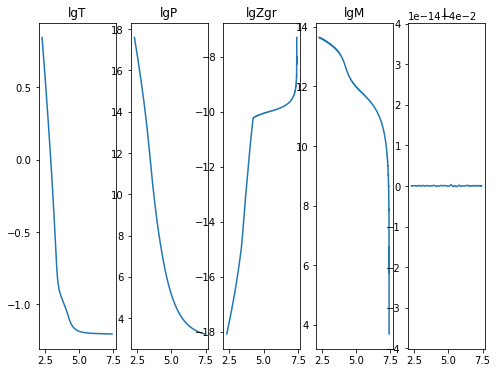

2020-11-16 03:04:10,021 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s
2020-11-16 03:04:12,052 __main__ 0/1 INFO :: Perturbation norm: 1.7404102997220998
2020-11-16 03:04:12,053 __main__ 0/1 INFO :: lgT iterate: 0.8449297741412605
2020-11-16 03:04:12,054 __main__ 0/1 INFO :: lgP iterate: 17.581556689353786
2020-11-16 03:04:12,055 __main__ 0/1 INFO :: lgM iterate: 13.641074701542642
2020-11-16 03:04:12,056 __main__ 0/1 INFO :: lgZgr iterate: -18.069925201131735
2020-11-16 03:04:12,058 __main__ 0/1 INFO :: m iterate: 5.5042575536567995e-05
2020-11-16 03:04:12,059 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


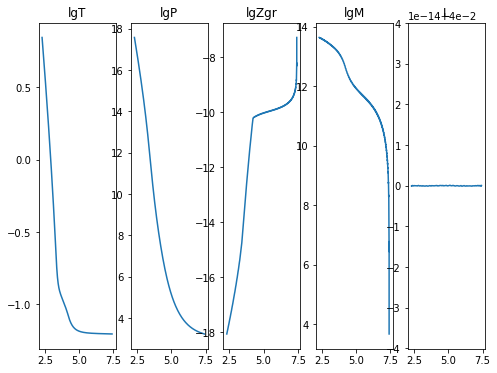

2020-11-16 03:04:18,872 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s
2020-11-16 03:04:20,758 __main__ 0/1 INFO :: Perturbation norm: 1.7404209808160978
2020-11-16 03:04:20,763 __main__ 0/1 INFO :: lgT iterate: 0.8455522991619071
2020-11-16 03:04:20,768 __main__ 0/1 INFO :: lgP iterate: 17.596817553376198
2020-11-16 03:04:20,771 __main__ 0/1 INFO :: lgM iterate: 13.641115617932009
2020-11-16 03:04:20,774 __main__ 0/1 INFO :: lgZgr iterate: -18.08428476951581
2020-11-16 03:04:20,775 __main__ 0/1 INFO :: m iterate: 5.587644276694448e-05
2020-11-16 03:04:20,776 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


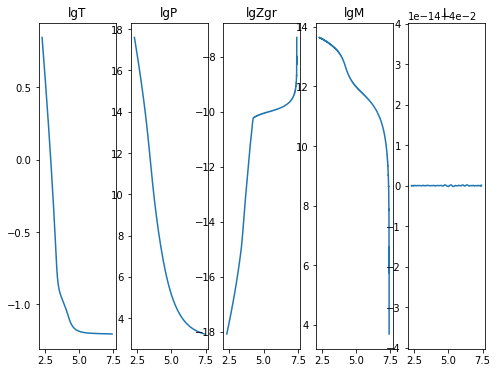

2020-11-16 03:04:27,601 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s
2020-11-16 03:04:29,710 __main__ 0/1 INFO :: Perturbation norm: 1.7404381811055183
2020-11-16 03:04:29,712 __main__ 0/1 INFO :: lgT iterate: 0.8449297698609508
2020-11-16 03:04:29,714 __main__ 0/1 INFO :: lgP iterate: 17.58155658241136
2020-11-16 03:04:29,715 __main__ 0/1 INFO :: lgM iterate: 13.641074696744086
2020-11-16 03:04:29,716 __main__ 0/1 INFO :: lgZgr iterate: -18.06992509736631
2020-11-16 03:04:29,718 __main__ 0/1 INFO :: m iterate: 5.504256954314002e-05
2020-11-16 03:04:29,719 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


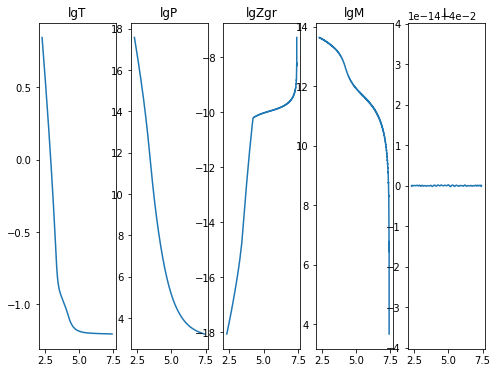

2020-11-16 03:04:36,330 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s
2020-11-16 03:04:38,463 __main__ 0/1 INFO :: Perturbation norm: 1.7404443097744187
2020-11-16 03:04:38,464 __main__ 0/1 INFO :: lgT iterate: 0.845552303309122
2020-11-16 03:04:38,466 __main__ 0/1 INFO :: lgP iterate: 17.596817655991718
2020-11-16 03:04:38,474 __main__ 0/1 INFO :: lgM iterate: 13.64111559778563
2020-11-16 03:04:38,480 __main__ 0/1 INFO :: lgZgr iterate: -18.084284852455752
2020-11-16 03:04:38,484 __main__ 0/1 INFO :: m iterate: 5.587644841575923e-05
2020-11-16 03:04:38,486 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


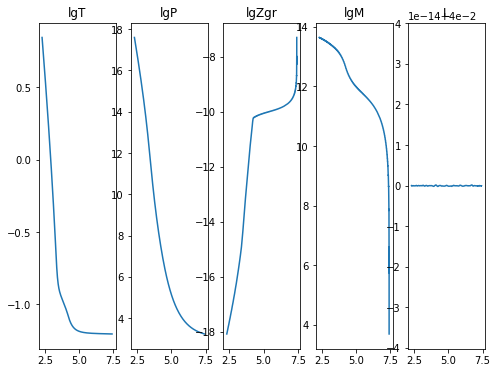

2020-11-16 03:04:45,044 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 03:04:46,442 __main__ 0/1 INFO :: Perturbation norm: 1.740451837528488
2020-11-16 03:04:46,443 __main__ 0/1 INFO :: lgT iterate: 0.8449297672170273
2020-11-16 03:04:46,446 __main__ 0/1 INFO :: lgP iterate: 17.58155651435449
2020-11-16 03:04:46,447 __main__ 0/1 INFO :: lgM iterate: 13.641074681641447
2020-11-16 03:04:46,449 __main__ 0/1 INFO :: lgZgr iterate: -18.069925023162547
2020-11-16 03:04:46,451 __main__ 0/1 INFO :: m iterate: 5.504256615296299e-05
2020-11-16 03:04:46,453 __main__ 0/1 INFO :: L iterate: 0.04


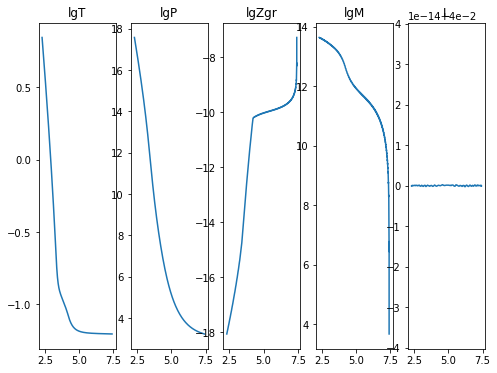

2020-11-16 03:04:53,251 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:04:55,231 __main__ 0/1 INFO :: Perturbation norm: 1.740455237489943
2020-11-16 03:04:55,232 __main__ 0/1 INFO :: lgT iterate: 0.8455523051108785
2020-11-16 03:04:55,233 __main__ 0/1 INFO :: lgP iterate: 17.596817699002997
2020-11-16 03:04:55,234 __main__ 0/1 INFO :: lgM iterate: 13.641115585040652
2020-11-16 03:04:55,235 __main__ 0/1 INFO :: lgZgr iterate: -18.084284884255364
2020-11-16 03:04:55,237 __main__ 0/1 INFO :: m iterate: 5.5876450721470405e-05
2020-11-16 03:04:55,238 __main__ 0/1 INFO :: L iterate: 0.04


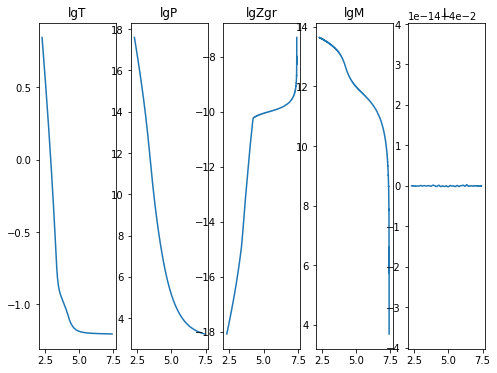

2020-11-16 03:05:01,917 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:05:03,813 __main__ 0/1 INFO :: Perturbation norm: 1.740459111327827
2020-11-16 03:05:03,818 __main__ 0/1 INFO :: lgT iterate: 0.8449297657883276
2020-11-16 03:05:03,819 __main__ 0/1 INFO :: lgP iterate: 17.581556478219426
2020-11-16 03:05:03,819 __main__ 0/1 INFO :: lgM iterate: 13.641074673565681
2020-11-16 03:05:03,821 __main__ 0/1 INFO :: lgZgr iterate: -18.069924983763094
2020-11-16 03:05:03,821 __main__ 0/1 INFO :: m iterate: 5.5042564317986375e-05
2020-11-16 03:05:03,822 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


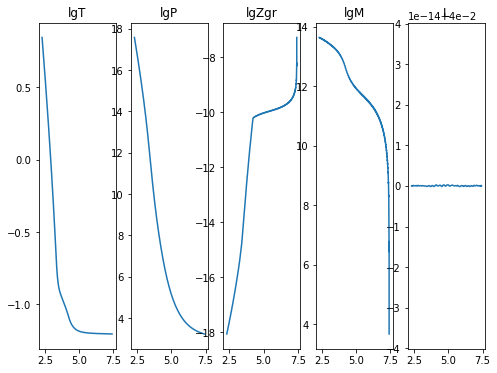

2020-11-16 03:05:10,660 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 03:05:13,127 __main__ 0/1 INFO :: Perturbation norm: 1.7404605162072966
2020-11-16 03:05:13,128 __main__ 0/1 INFO :: lgT iterate: 0.8455523056117715
2020-11-16 03:05:13,129 __main__ 0/1 INFO :: lgP iterate: 17.5968177101105
2020-11-16 03:05:13,130 __main__ 0/1 INFO :: lgM iterate: 13.641115577090499
2020-11-16 03:05:13,131 __main__ 0/1 INFO :: lgZgr iterate: -18.084284889305266
2020-11-16 03:05:13,132 __main__ 0/1 INFO :: m iterate: 5.587645122506757e-05
2020-11-16 03:05:13,133 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


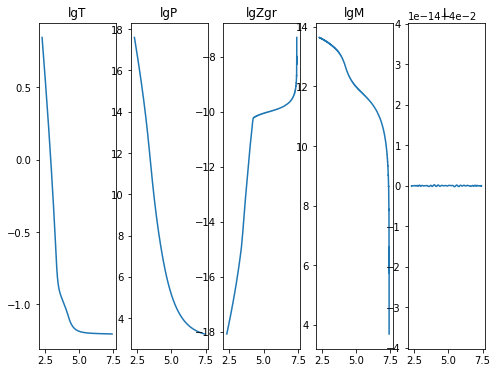

2020-11-16 03:05:20,026 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:05:22,316 __main__ 0/1 INFO :: Perturbation norm: 1.74046225263493
2020-11-16 03:05:22,321 __main__ 0/1 INFO :: lgT iterate: 0.8449297652117188
2020-11-16 03:05:22,325 __main__ 0/1 INFO :: lgP iterate: 17.58155646378919
2020-11-16 03:05:22,329 __main__ 0/1 INFO :: lgM iterate: 13.641074671030237
2020-11-16 03:05:22,335 __main__ 0/1 INFO :: lgZgr iterate: -18.069924968498977
2020-11-16 03:05:22,339 __main__ 0/1 INFO :: m iterate: 5.504256357369286e-05
2020-11-16 03:05:22,343 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


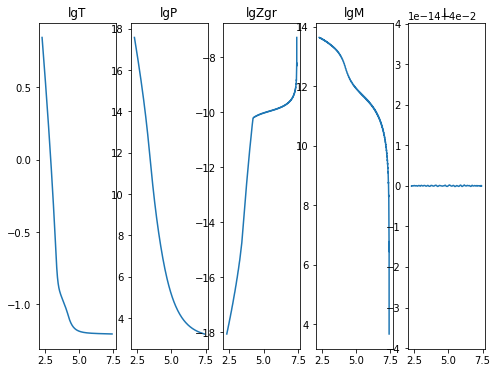

2020-11-16 03:05:29,206 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2020-11-16 03:05:31,086 __main__ 0/1 INFO :: Perturbation norm: 1.7404628189550793
2020-11-16 03:05:31,087 __main__ 0/1 INFO :: lgT iterate: 0.8455523058332107
2020-11-16 03:05:31,088 __main__ 0/1 INFO :: lgP iterate: 17.596817715139714
2020-11-16 03:05:31,089 __main__ 0/1 INFO :: lgM iterate: 13.641115573841574
2020-11-16 03:05:31,090 __main__ 0/1 INFO :: lgZgr iterate: -18.084284891833775
2020-11-16 03:05:31,091 __main__ 0/1 INFO :: m iterate: 5.587645147375753e-05
2020-11-16 03:05:31,091 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


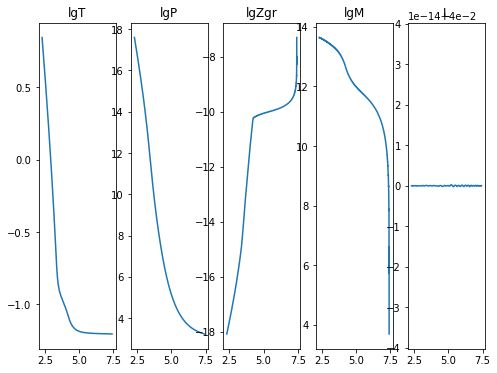

2020-11-16 03:05:39,305 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s
2020-11-16 03:05:44,784 __main__ 0/1 INFO :: Perturbation norm: 1.7404635463190525
2020-11-16 03:05:44,786 __main__ 0/1 INFO :: lgT iterate: 0.8449297649775465
2020-11-16 03:05:44,788 __main__ 0/1 INFO :: lgP iterate: 17.581556457893278
2020-11-16 03:05:44,789 __main__ 0/1 INFO :: lgM iterate: 13.641074670032449
2020-11-16 03:05:44,790 __main__ 0/1 INFO :: lgZgr iterate: -18.069924962285715
2020-11-16 03:05:44,792 __main__ 0/1 INFO :: m iterate: 5.504256326460677e-05
2020-11-16 03:05:44,794 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


2020-11-16 03:05:51,669 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 03:05:53,090 __main__ 0/1 INFO :: Perturbation norm: 1.7404638055751116
2020-11-16 03:05:53,091 __main__ 0/1 INFO :: lgT iterate: 0.8455523059561673
2020-11-16 03:05:53,092 __main__ 0/1 INFO :: lgP iterate: 17.59681771803263
2020-11-16 03:05:53,093 __main__ 0/1 INFO :: lgM iterate: 13.641115572591989
2020-11-16 03:05:53,094 __main__ 0/1 INFO :: lgZgr iterate: -18.084284893708087
2020-11-16 03:05:53,095 __main__ 0/1 INFO :: m iterate: 5.587645162563604e-05
2020-11-16 03:05:53,096 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


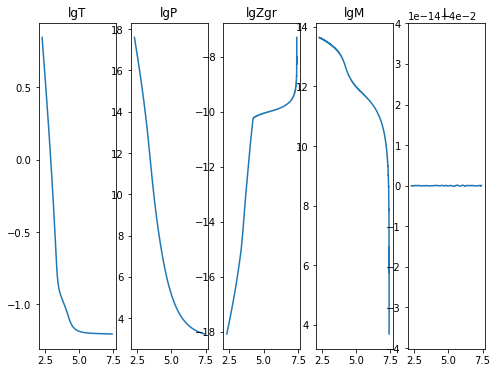

2020-11-16 03:05:58,816 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:05:59,886 __main__ 0/1 INFO :: Perturbation norm: 1.7404641265401417
2020-11-16 03:05:59,887 __main__ 0/1 INFO :: lgT iterate: 0.8449297648691272
2020-11-16 03:05:59,888 __main__ 0/1 INFO :: lgP iterate: 17.581556455149798
2020-11-16 03:05:59,889 __main__ 0/1 INFO :: lgM iterate: 13.641074669504626
2020-11-16 03:05:59,890 __main__ 0/1 INFO :: lgZgr iterate: -18.0699249593513
2020-11-16 03:05:59,891 __main__ 0/1 INFO :: m iterate: 5.504256311894551e-05
2020-11-16 03:05:59,892 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


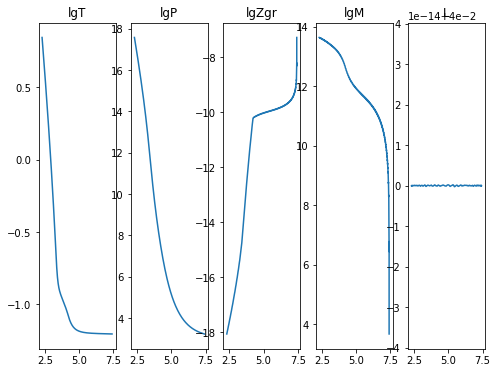

2020-11-16 03:06:05,479 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:06:06,503 __main__ 0/1 INFO :: Perturbation norm: 1.7404642464904883
2020-11-16 03:06:06,504 __main__ 0/1 INFO :: lgT iterate: 0.8455523060111847
2020-11-16 03:06:06,505 __main__ 0/1 INFO :: lgP iterate: 17.596817719318295
2020-11-16 03:06:06,506 __main__ 0/1 INFO :: lgM iterate: 13.641115572016684
2020-11-16 03:06:06,507 __main__ 0/1 INFO :: lgZgr iterate: -18.084284894527208
2020-11-16 03:06:06,508 __main__ 0/1 INFO :: m iterate: 5.587645168514399e-05
2020-11-16 03:06:06,509 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


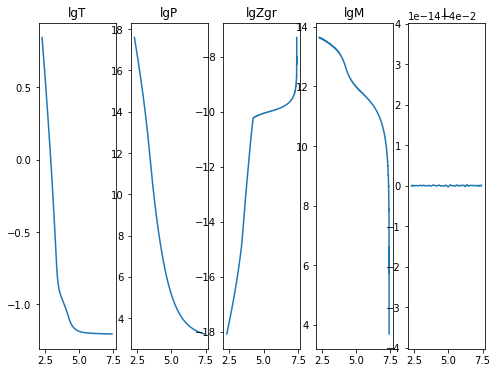

2020-11-16 03:06:11,566 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:06:12,767 __main__ 0/1 INFO :: Perturbation norm: 1.7404643925589764
2020-11-16 03:06:12,771 __main__ 0/1 INFO :: lgT iterate: 0.8449297648191264
2020-11-16 03:06:12,772 __main__ 0/1 INFO :: lgP iterate: 17.581556453887867
2020-11-16 03:06:12,773 __main__ 0/1 INFO :: lgM iterate: 13.641074669258472
2020-11-16 03:06:12,773 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495799949
2020-11-16 03:06:12,774 __main__ 0/1 INFO :: m iterate: 5.504256305588484e-05
2020-11-16 03:06:12,776 __main__ 0/1 INFO :: L iterate: 0.04


2020-11-16 03:06:18,144 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:06:19,171 __main__ 0/1 INFO :: Perturbation norm: 1.740464445240265
2020-11-16 03:06:19,177 __main__ 0/1 INFO :: lgT iterate: 0.845552306033589
2020-11-16 03:06:19,179 __main__ 0/1 INFO :: lgP iterate: 17.59681771983482
2020-11-16 03:06:19,180 __main__ 0/1 INFO :: lgM iterate: 13.641115571745102
2020-11-16 03:06:19,181 __main__ 0/1 INFO :: lgZgr iterate: -18.084284894828848
2020-11-16 03:06:19,182 __main__ 0/1 INFO :: m iterate: 5.587645170912481e-05
2020-11-16 03:06:19,182 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


2020-11-16 03:06:24,482 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:06:26,041 __main__ 0/1 INFO :: Perturbation norm: 1.740464510306222
2020-11-16 03:06:26,042 __main__ 0/1 INFO :: lgT iterate: 0.8449297647972724
2020-11-16 03:06:26,043 __main__ 0/1 INFO :: lgP iterate: 17.581556453337335
2020-11-16 03:06:26,044 __main__ 0/1 INFO :: lgM iterate: 13.641074669156046
2020-11-16 03:06:26,044 __main__ 0/1 INFO :: lgZgr iterate: -18.069924957413118
2020-11-16 03:06:26,046 __main__ 0/1 INFO :: m iterate: 5.5042563031015845e-05
2020-11-16 03:06:26,046 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


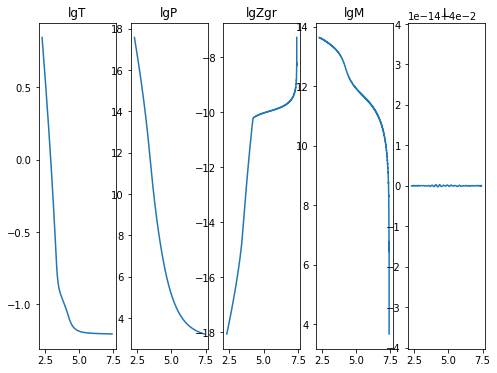

2020-11-16 03:06:30,520 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:06:31,988 __main__ 0/1 INFO :: Perturbation norm: 1.7404645332885973
2020-11-16 03:06:31,989 __main__ 0/1 INFO :: lgT iterate: 0.845552306043474
2020-11-16 03:06:31,990 __main__ 0/1 INFO :: lgP iterate: 17.596817720063243
2020-11-16 03:06:31,991 __main__ 0/1 INFO :: lgM iterate: 13.641115571625939
2020-11-16 03:06:31,992 __main__ 0/1 INFO :: lgZgr iterate: -18.084284894962888
2020-11-16 03:06:31,993 __main__ 0/1 INFO :: m iterate: 5.5876451721559306e-05
2020-11-16 03:06:31,994 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


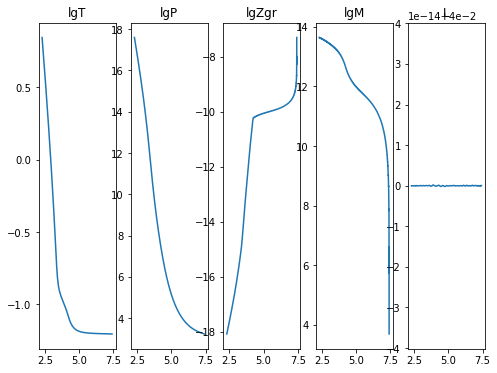

2020-11-16 03:06:36,936 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 03:06:39,312 __main__ 0/1 INFO :: Perturbation norm: 1.7404645618867378
2020-11-16 03:06:39,313 __main__ 0/1 INFO :: lgT iterate: 0.8449297647877233
2020-11-16 03:06:39,314 __main__ 0/1 INFO :: lgP iterate: 17.58155645309663
2020-11-16 03:06:39,315 __main__ 0/1 INFO :: lgM iterate: 13.64107466911167
2020-11-16 03:06:39,316 __main__ 0/1 INFO :: lgZgr iterate: -18.069924957157014
2020-11-16 03:06:39,317 __main__ 0/1 INFO :: m iterate: 5.504256301591681e-05
2020-11-16 03:06:39,317 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


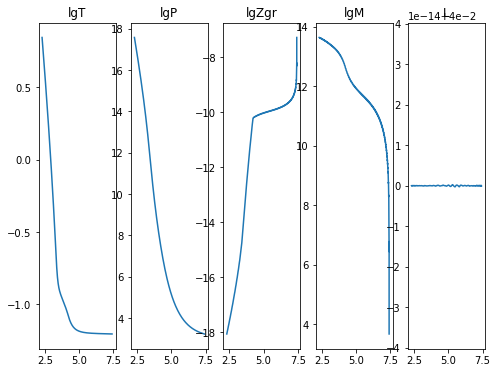

2020-11-16 03:06:43,724 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:06:44,579 __main__ 0/1 INFO :: Perturbation norm: 1.7404645721317413
2020-11-16 03:06:44,580 __main__ 0/1 INFO :: lgT iterate: 0.8455523060480251
2020-11-16 03:06:44,581 __main__ 0/1 INFO :: lgP iterate: 17.596817720169092
2020-11-16 03:06:44,582 __main__ 0/1 INFO :: lgM iterate: 13.641115571574469
2020-11-16 03:06:44,583 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895027565
2020-11-16 03:06:44,584 __main__ 0/1 INFO :: m iterate: 5.587645172422384e-05
2020-11-16 03:06:44,585 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


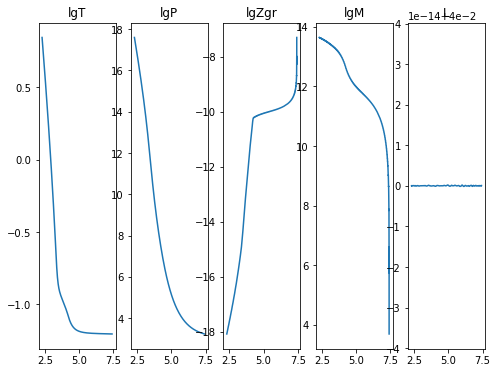

2020-11-16 03:06:48,752 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:06:50,169 __main__ 0/1 INFO :: Perturbation norm: 1.7404645848071465
2020-11-16 03:06:50,170 __main__ 0/1 INFO :: lgT iterate: 0.8449297647834609
2020-11-16 03:06:50,171 __main__ 0/1 INFO :: lgP iterate: 17.581556452989027
2020-11-16 03:06:50,171 __main__ 0/1 INFO :: lgM iterate: 13.641074669091386
2020-11-16 03:06:50,172 __main__ 0/1 INFO :: lgZgr iterate: -18.069924957042215
2020-11-16 03:06:50,173 __main__ 0/1 INFO :: m iterate: 5.504256301769317e-05
2020-11-16 03:06:50,174 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


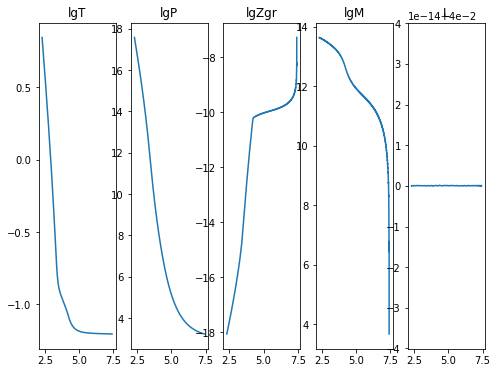

2020-11-16 03:06:54,492 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:06:55,477 __main__ 0/1 INFO :: Perturbation norm: 1.7404645893906174
2020-11-16 03:06:55,478 __main__ 0/1 INFO :: lgT iterate: 0.8455523060500538
2020-11-16 03:06:55,479 __main__ 0/1 INFO :: lgP iterate: 17.596817720216272
2020-11-16 03:06:55,480 __main__ 0/1 INFO :: lgM iterate: 13.64111557155146
2020-11-16 03:06:55,481 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895056335
2020-11-16 03:06:55,482 __main__ 0/1 INFO :: m iterate: 5.587645172511202e-05
2020-11-16 03:06:55,483 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


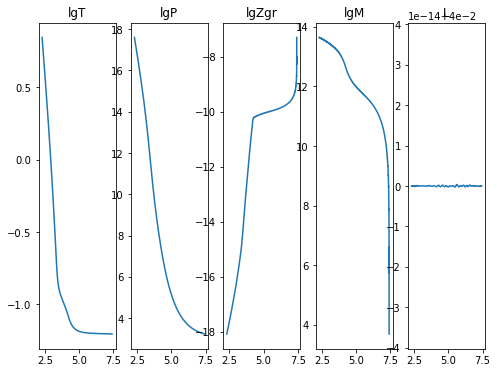

2020-11-16 03:07:00,680 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 03:07:02,475 __main__ 0/1 INFO :: Perturbation norm: 1.7404645950415754
2020-11-16 03:07:02,485 __main__ 0/1 INFO :: lgT iterate: 0.8449297647815533
2020-11-16 03:07:02,486 __main__ 0/1 INFO :: lgP iterate: 17.581556452940944
2020-11-16 03:07:02,487 __main__ 0/1 INFO :: lgM iterate: 13.641074669082329
2020-11-16 03:07:02,488 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956990928
2020-11-16 03:07:02,489 __main__ 0/1 INFO :: m iterate: 5.50425630123641e-05
2020-11-16 03:07:02,491 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


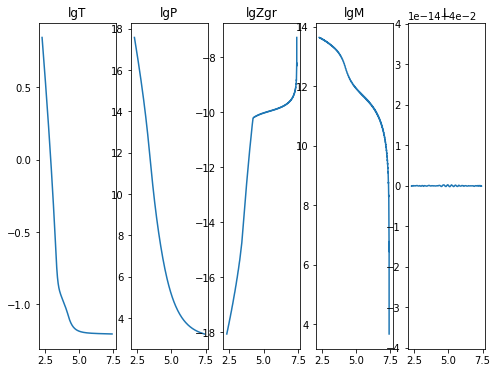

2020-11-16 03:07:06,636 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:07:07,993 __main__ 0/1 INFO :: Perturbation norm: 1.7404645970735468
2020-11-16 03:07:07,994 __main__ 0/1 INFO :: lgT iterate: 0.8455523060509443
2020-11-16 03:07:07,995 __main__ 0/1 INFO :: lgP iterate: 17.596817720236835
2020-11-16 03:07:07,996 __main__ 0/1 INFO :: lgM iterate: 13.641115571541201
2020-11-16 03:07:07,997 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489506872
2020-11-16 03:07:07,998 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:07:07,999 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


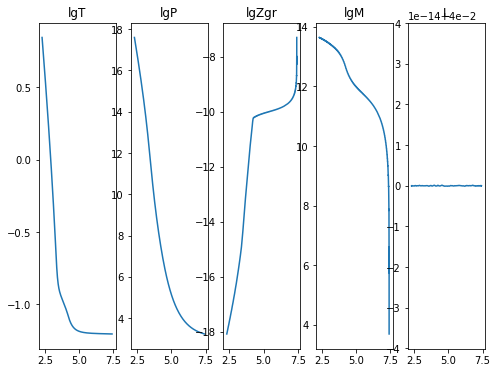

2020-11-16 03:07:12,899 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:07:14,271 __main__ 0/1 INFO :: Perturbation norm: 1.7404645995848285
2020-11-16 03:07:14,272 __main__ 0/1 INFO :: lgT iterate: 0.8449297647807101
2020-11-16 03:07:14,273 __main__ 0/1 INFO :: lgP iterate: 17.58155645291966
2020-11-16 03:07:14,274 __main__ 0/1 INFO :: lgM iterate: 13.641074669078323
2020-11-16 03:07:14,275 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956968233
2020-11-16 03:07:14,276 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:07:14,278 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


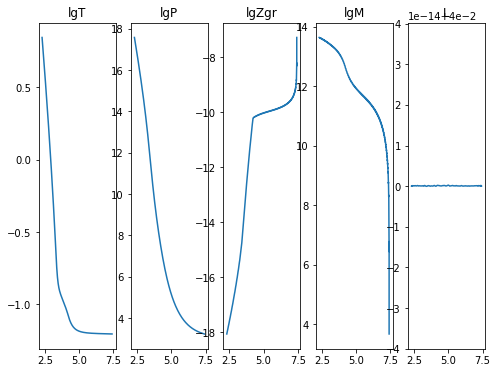

2020-11-16 03:07:18,532 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:07:20,286 __main__ 0/1 INFO :: Perturbation norm: 1.7404646004839035
2020-11-16 03:07:20,287 __main__ 0/1 INFO :: lgT iterate: 0.8455523060513355
2020-11-16 03:07:20,288 __main__ 0/1 INFO :: lgP iterate: 17.59681772024593
2020-11-16 03:07:20,291 __main__ 0/1 INFO :: lgM iterate: 13.641115571536567
2020-11-16 03:07:20,293 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895074134
2020-11-16 03:07:20,294 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:07:20,296 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


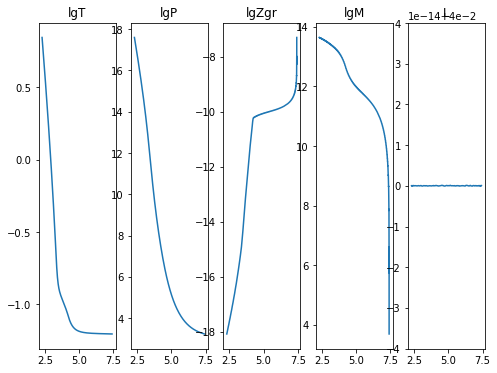

2020-11-16 03:07:26,697 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2020-11-16 03:07:27,972 __main__ 0/1 INFO :: Perturbation norm: 1.7404646015973984
2020-11-16 03:07:27,974 __main__ 0/1 INFO :: lgT iterate: 0.8449297647803361
2020-11-16 03:07:27,975 __main__ 0/1 INFO :: lgP iterate: 17.581556452910174
2020-11-16 03:07:27,976 __main__ 0/1 INFO :: lgM iterate: 13.641074669076529
2020-11-16 03:07:27,977 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956958104
2020-11-16 03:07:27,979 __main__ 0/1 INFO :: m iterate: 5.5042563007923206e-05
2020-11-16 03:07:27,980 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


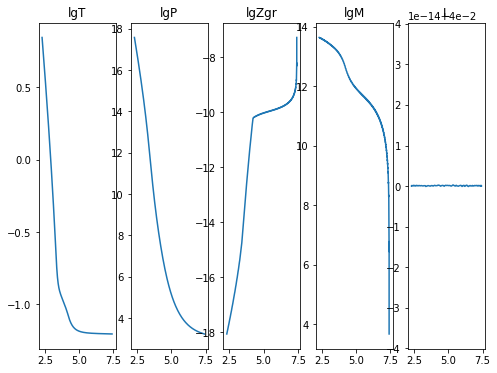

2020-11-16 03:07:34,050 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:07:37,060 __main__ 0/1 INFO :: Perturbation norm: 1.7404646019965875
2020-11-16 03:07:37,061 __main__ 0/1 INFO :: lgT iterate: 0.8455523060515107
2020-11-16 03:07:37,063 __main__ 0/1 INFO :: lgP iterate: 17.596817720249998
2020-11-16 03:07:37,064 __main__ 0/1 INFO :: lgM iterate: 13.641115571534543
2020-11-16 03:07:37,065 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895076586
2020-11-16 03:07:37,070 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:07:37,071 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


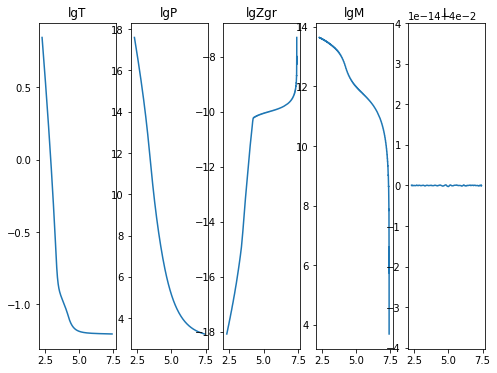

2020-11-16 03:07:43,392 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:07:45,663 __main__ 0/1 INFO :: Perturbation norm: 1.7404646024902375
2020-11-16 03:07:45,665 __main__ 0/1 INFO :: lgT iterate: 0.8449297647801697
2020-11-16 03:07:45,666 __main__ 0/1 INFO :: lgP iterate: 17.58155645290602
2020-11-16 03:07:45,667 __main__ 0/1 INFO :: lgM iterate: 13.641074669075746
2020-11-16 03:07:45,668 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956953674
2020-11-16 03:07:45,670 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:07:45,671 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


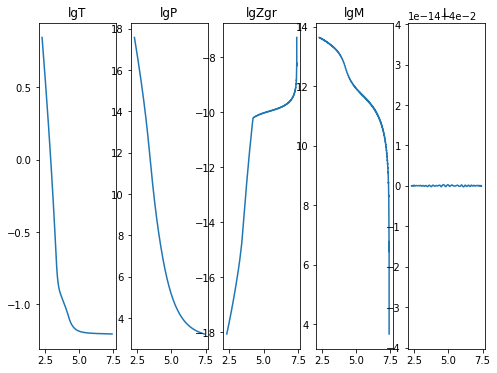

2020-11-16 03:07:51,471 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 03:07:53,051 __main__ 0/1 INFO :: Perturbation norm: 1.7404646026685042
2020-11-16 03:07:53,053 __main__ 0/1 INFO :: lgT iterate: 0.8455523060515903
2020-11-16 03:07:53,054 __main__ 0/1 INFO :: lgP iterate: 17.596817720251885
2020-11-16 03:07:53,055 __main__ 0/1 INFO :: lgM iterate: 13.641115571533701
2020-11-16 03:07:53,056 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507779
2020-11-16 03:07:53,057 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:07:53,063 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


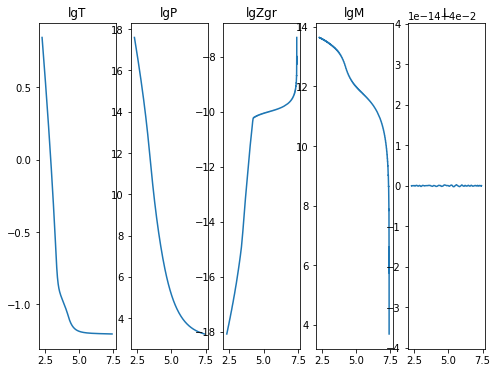

2020-11-16 03:07:59,054 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:08:00,907 __main__ 0/1 INFO :: Perturbation norm: 1.7404646028882067
2020-11-16 03:08:00,910 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800943
2020-11-16 03:08:00,914 __main__ 0/1 INFO :: lgP iterate: 17.581556452904135
2020-11-16 03:08:00,917 __main__ 0/1 INFO :: lgM iterate: 13.641074669075376
2020-11-16 03:08:00,920 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695166
2020-11-16 03:08:00,924 __main__ 0/1 INFO :: m iterate: 5.504256300525867e-05
2020-11-16 03:08:00,927 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


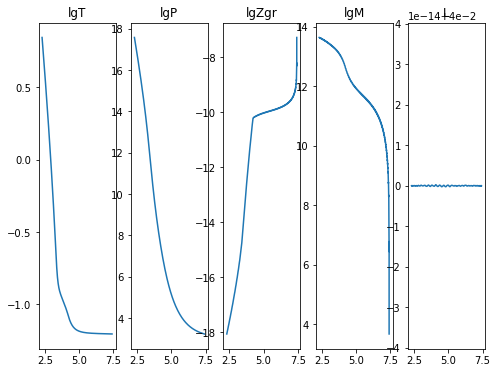

2020-11-16 03:08:06,667 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:08:07,970 __main__ 0/1 INFO :: Perturbation norm: 1.7404646029660746
2020-11-16 03:08:07,980 __main__ 0/1 INFO :: lgT iterate: 0.845552306051623
2020-11-16 03:08:07,981 __main__ 0/1 INFO :: lgP iterate: 17.596817720252623
2020-11-16 03:08:07,982 __main__ 0/1 INFO :: lgM iterate: 13.641115571533284
2020-11-16 03:08:07,983 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078206
2020-11-16 03:08:07,992 __main__ 0/1 INFO :: m iterate: 5.5876451727776555e-05
2020-11-16 03:08:07,993 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


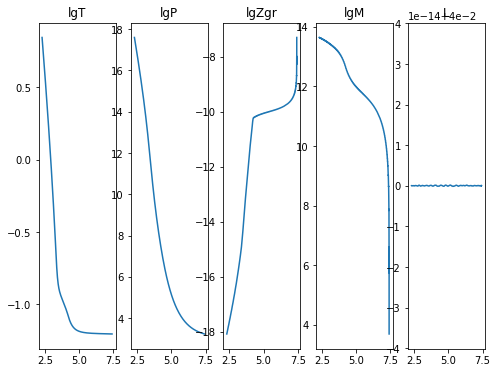

2020-11-16 03:08:13,864 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:08:15,425 __main__ 0/1 INFO :: Perturbation norm: 1.7404646030628736
2020-11-16 03:08:15,426 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800607
2020-11-16 03:08:15,427 __main__ 0/1 INFO :: lgP iterate: 17.581556452903364
2020-11-16 03:08:15,428 __main__ 0/1 INFO :: lgM iterate: 13.641074669075271
2020-11-16 03:08:15,429 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695086
2020-11-16 03:08:15,430 __main__ 0/1 INFO :: m iterate: 5.5042563014140455e-05
2020-11-16 03:08:15,433 __main__ 0/1 INFO :: L iterate: 0.04000000000000004


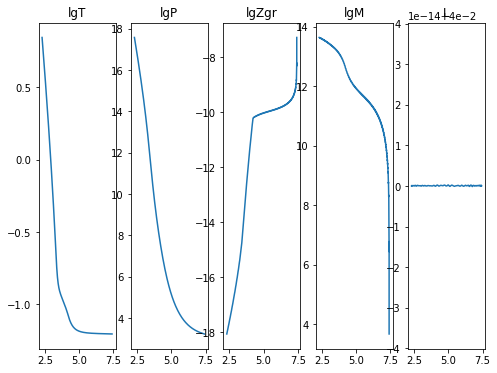

2020-11-16 03:08:21,257 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 03:08:22,717 __main__ 0/1 INFO :: Perturbation norm: 1.7404646030982376
2020-11-16 03:08:22,718 __main__ 0/1 INFO :: lgT iterate: 0.84555230605164
2020-11-16 03:08:22,720 __main__ 0/1 INFO :: lgP iterate: 17.59681772025299
2020-11-16 03:08:22,720 __main__ 0/1 INFO :: lgM iterate: 13.641115571533005
2020-11-16 03:08:22,721 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078355
2020-11-16 03:08:22,723 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:08:22,724 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


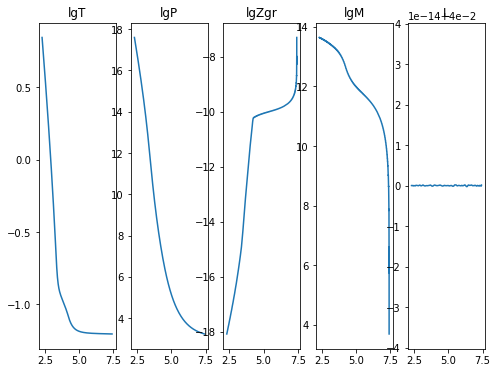

2020-11-16 03:08:28,921 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2020-11-16 03:08:30,733 __main__ 0/1 INFO :: Perturbation norm: 1.740464603141563
2020-11-16 03:08:30,737 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800519
2020-11-16 03:08:30,738 __main__ 0/1 INFO :: lgP iterate: 17.581556452902994
2020-11-16 03:08:30,742 __main__ 0/1 INFO :: lgM iterate: 13.641074669075282
2020-11-16 03:08:30,745 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695052
2020-11-16 03:08:30,748 __main__ 0/1 INFO :: m iterate: 5.5042563014140455e-05
2020-11-16 03:08:30,751 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


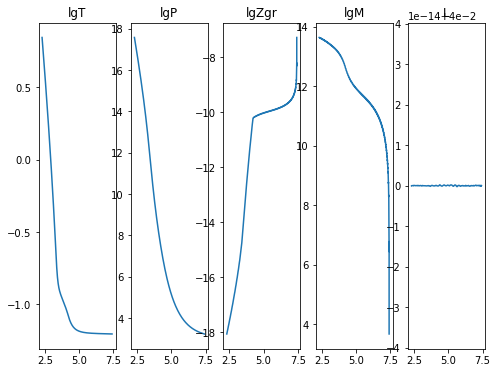

2020-11-16 03:08:35,243 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 03:08:36,787 __main__ 0/1 INFO :: Perturbation norm: 1.7404646031571374
2020-11-16 03:08:36,788 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516474
2020-11-16 03:08:36,789 __main__ 0/1 INFO :: lgP iterate: 17.596817720253135
2020-11-16 03:08:36,790 __main__ 0/1 INFO :: lgM iterate: 13.641115571533
2020-11-16 03:08:36,790 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507849
2020-11-16 03:08:36,792 __main__ 0/1 INFO :: m iterate: 5.587645173221745e-05
2020-11-16 03:08:36,792 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


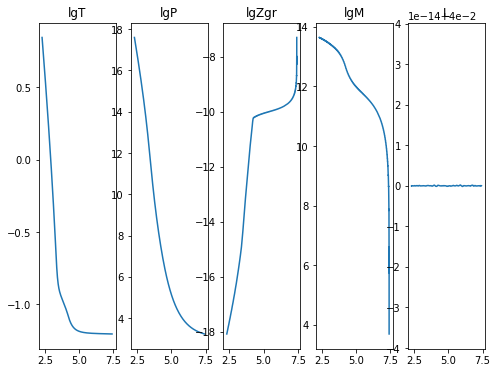

2020-11-16 03:08:41,190 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:08:42,393 __main__ 0/1 INFO :: Perturbation norm: 1.7404646031768192
2020-11-16 03:08:42,394 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800427
2020-11-16 03:08:42,395 __main__ 0/1 INFO :: lgP iterate: 17.581556452902788
2020-11-16 03:08:42,396 __main__ 0/1 INFO :: lgM iterate: 13.641074669075222
2020-11-16 03:08:42,397 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950288
2020-11-16 03:08:42,398 __main__ 0/1 INFO :: m iterate: 5.5042563008811385e-05
2020-11-16 03:08:42,398 __main__ 0/1 INFO :: L iterate: 0.04


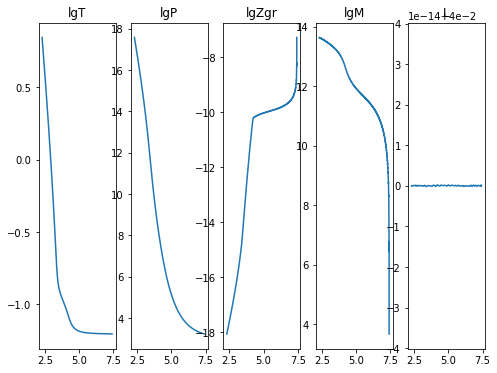

2020-11-16 03:08:46,592 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 03:08:47,707 __main__ 0/1 INFO :: Perturbation norm: 1.7404646031837707
2020-11-16 03:08:47,708 __main__ 0/1 INFO :: lgT iterate: 0.845552306051649
2020-11-16 03:08:47,709 __main__ 0/1 INFO :: lgP iterate: 17.596817720253192
2020-11-16 03:08:47,710 __main__ 0/1 INFO :: lgM iterate: 13.641115571532962
2020-11-16 03:08:47,711 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078515
2020-11-16 03:08:47,712 __main__ 0/1 INFO :: m iterate: 5.5876451733993804e-05
2020-11-16 03:08:47,713 __main__ 0/1 INFO :: L iterate: 0.04


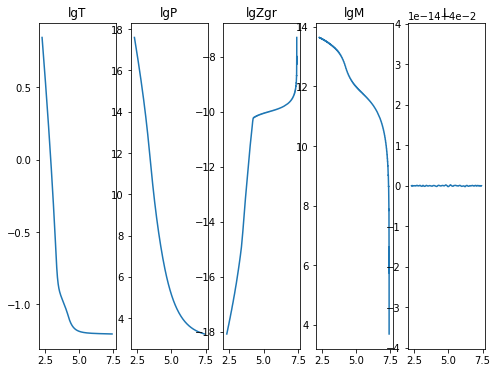

2020-11-16 03:08:51,628 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:08:52,596 __main__ 0/1 INFO :: Perturbation norm: 1.7404646031924358
2020-11-16 03:08:52,597 __main__ 0/1 INFO :: lgT iterate: 0.844929764780038
2020-11-16 03:08:52,598 __main__ 0/1 INFO :: lgP iterate: 17.58155645290273
2020-11-16 03:08:52,599 __main__ 0/1 INFO :: lgM iterate: 13.641074669075111
2020-11-16 03:08:52,600 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950153
2020-11-16 03:08:52,601 __main__ 0/1 INFO :: m iterate: 5.5042563008811385e-05
2020-11-16 03:08:52,602 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


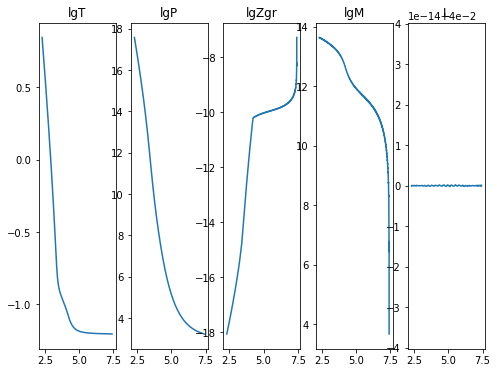

2020-11-16 03:08:56,920 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:08:58,175 __main__ 0/1 INFO :: Perturbation norm: 1.74046460319524
2020-11-16 03:08:58,177 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516479
2020-11-16 03:08:58,178 __main__ 0/1 INFO :: lgP iterate: 17.596817720253206
2020-11-16 03:08:58,179 __main__ 0/1 INFO :: lgM iterate: 13.64111557153295
2020-11-16 03:08:58,180 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078518
2020-11-16 03:08:58,181 __main__ 0/1 INFO :: m iterate: 5.587645173577016e-05
2020-11-16 03:08:58,182 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


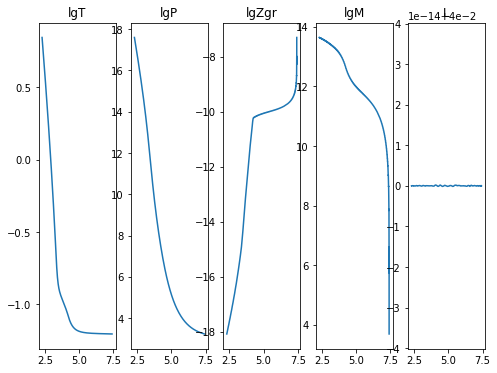

2020-11-16 03:09:02,952 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:09:03,998 __main__ 0/1 INFO :: Perturbation norm: 1.7404646031990183
2020-11-16 03:09:03,999 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800369
2020-11-16 03:09:04,000 __main__ 0/1 INFO :: lgP iterate: 17.581556452902714
2020-11-16 03:09:04,001 __main__ 0/1 INFO :: lgM iterate: 13.641074669075113
2020-11-16 03:09:04,002 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950132
2020-11-16 03:09:04,003 __main__ 0/1 INFO :: m iterate: 5.504256301325228e-05
2020-11-16 03:09:04,004 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


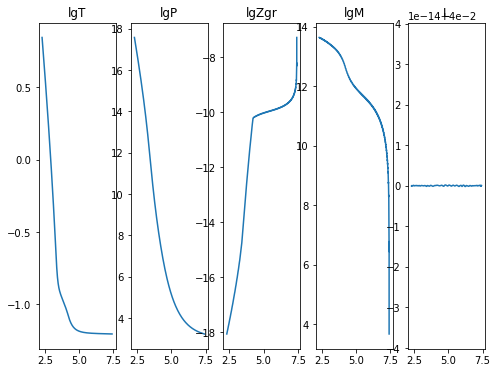

2020-11-16 03:09:08,008 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:09:08,838 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032009914
2020-11-16 03:09:08,838 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516523
2020-11-16 03:09:08,839 __main__ 0/1 INFO :: lgP iterate: 17.596817720253284
2020-11-16 03:09:08,840 __main__ 0/1 INFO :: lgM iterate: 13.641115571532913
2020-11-16 03:09:08,841 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507857
2020-11-16 03:09:08,842 __main__ 0/1 INFO :: m iterate: 5.5876451733105625e-05
2020-11-16 03:09:08,843 __main__ 0/1 INFO :: L iterate: 0.04


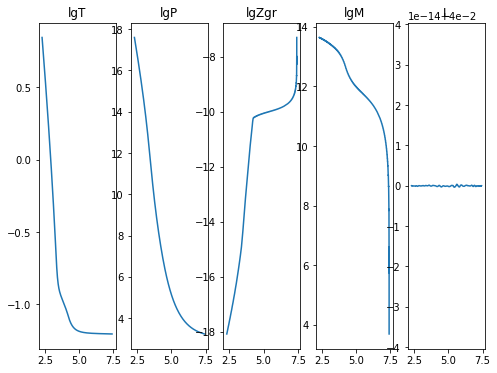

2020-11-16 03:09:12,467 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:09:13,488 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032027116
2020-11-16 03:09:13,489 __main__ 0/1 INFO :: lgT iterate: 0.844929764780038
2020-11-16 03:09:13,490 __main__ 0/1 INFO :: lgP iterate: 17.58155645290269
2020-11-16 03:09:13,491 __main__ 0/1 INFO :: lgM iterate: 13.641074669075104
2020-11-16 03:09:13,492 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950118
2020-11-16 03:09:13,492 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:09:13,493 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


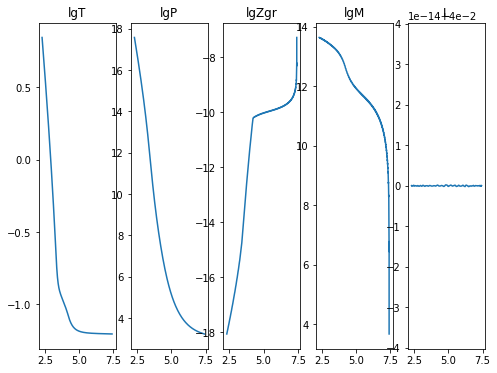

2020-11-16 03:09:17,320 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:09:18,243 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032033284
2020-11-16 03:09:18,244 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516521
2020-11-16 03:09:18,245 __main__ 0/1 INFO :: lgP iterate: 17.596817720253295
2020-11-16 03:09:18,246 __main__ 0/1 INFO :: lgM iterate: 13.641115571532982
2020-11-16 03:09:18,246 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507863
2020-11-16 03:09:18,247 __main__ 0/1 INFO :: m iterate: 5.587645172511202e-05
2020-11-16 03:09:18,248 __main__ 0/1 INFO :: L iterate: 0.04


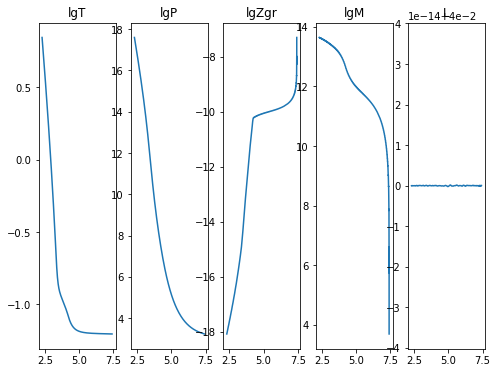

2020-11-16 03:09:22,147 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:09:23,611 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032041673
2020-11-16 03:09:23,613 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800348
2020-11-16 03:09:23,614 __main__ 0/1 INFO :: lgP iterate: 17.581556452902678
2020-11-16 03:09:23,615 __main__ 0/1 INFO :: lgM iterate: 13.641074669075081
2020-11-16 03:09:23,616 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950075
2020-11-16 03:09:23,617 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:09:23,618 __main__ 0/1 INFO :: L iterate: 0.04000000000000005


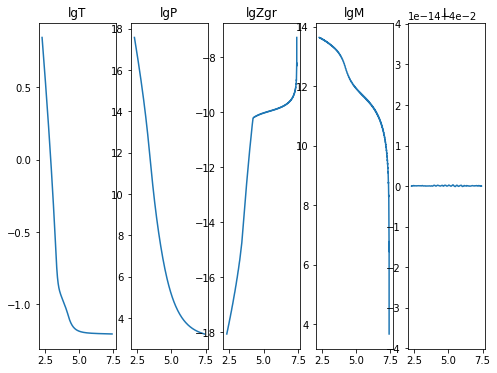

2020-11-16 03:09:28,517 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:09:29,465 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032045217
2020-11-16 03:09:29,466 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516517
2020-11-16 03:09:29,472 __main__ 0/1 INFO :: lgP iterate: 17.596817720253306
2020-11-16 03:09:29,473 __main__ 0/1 INFO :: lgM iterate: 13.641115571532943
2020-11-16 03:09:29,478 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078618
2020-11-16 03:09:29,479 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:09:29,482 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


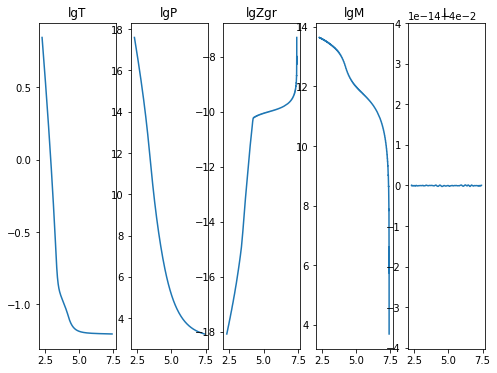

2020-11-16 03:09:34,254 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s
2020-11-16 03:09:35,349 __main__ 0/1 INFO :: Perturbation norm: 1.740464603204972
2020-11-16 03:09:35,351 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800338
2020-11-16 03:09:35,351 __main__ 0/1 INFO :: lgP iterate: 17.581556452902653
2020-11-16 03:09:35,352 __main__ 0/1 INFO :: lgM iterate: 13.641074669075099
2020-11-16 03:09:35,353 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950075
2020-11-16 03:09:35,354 __main__ 0/1 INFO :: m iterate: 5.5042563008811385e-05
2020-11-16 03:09:35,355 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


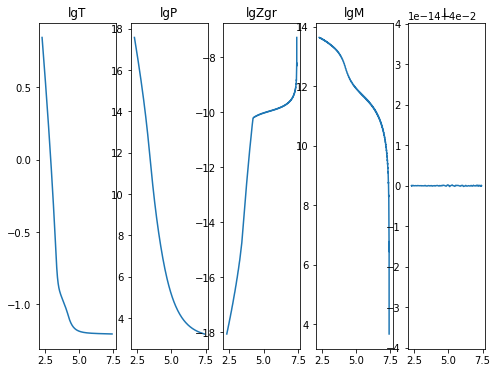

2020-11-16 03:09:40,166 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:09:41,093 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046696
2020-11-16 03:09:41,094 __main__ 0/1 INFO :: lgT iterate: 0.845552306051653
2020-11-16 03:09:41,095 __main__ 0/1 INFO :: lgP iterate: 17.596817720253306
2020-11-16 03:09:41,095 __main__ 0/1 INFO :: lgM iterate: 13.641115571532929
2020-11-16 03:09:41,096 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507861
2020-11-16 03:09:41,097 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:09:41,098 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


2020-11-16 03:09:46,720 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:09:48,378 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032041917
2020-11-16 03:09:48,379 __main__ 0/1 INFO :: lgT iterate: 0.844929764780039
2020-11-16 03:09:48,380 __main__ 0/1 INFO :: lgP iterate: 17.581556452902674
2020-11-16 03:09:48,381 __main__ 0/1 INFO :: lgM iterate: 13.64107466907511
2020-11-16 03:09:48,382 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950093
2020-11-16 03:09:48,383 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:09:48,384 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


2020-11-16 03:09:54,150 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:09:55,278 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044178
2020-11-16 03:09:55,279 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516529
2020-11-16 03:09:55,280 __main__ 0/1 INFO :: lgP iterate: 17.59681772025333
2020-11-16 03:09:55,281 __main__ 0/1 INFO :: lgM iterate: 13.64111557153291
2020-11-16 03:09:55,282 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078614
2020-11-16 03:09:55,283 __main__ 0/1 INFO :: m iterate: 5.5876451726888376e-05
2020-11-16 03:09:55,285 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


2020-11-16 03:09:59,737 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:10:00,701 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032047602
2020-11-16 03:10:00,703 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800338
2020-11-16 03:10:00,703 __main__ 0/1 INFO :: lgP iterate: 17.581556452902642
2020-11-16 03:10:00,704 __main__ 0/1 INFO :: lgM iterate: 13.641074669075078
2020-11-16 03:10:00,705 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950043
2020-11-16 03:10:00,706 __main__ 0/1 INFO :: m iterate: 5.5042563014140455e-05
2020-11-16 03:10:00,706 __main__ 0/1 INFO :: L iterate: 0.04


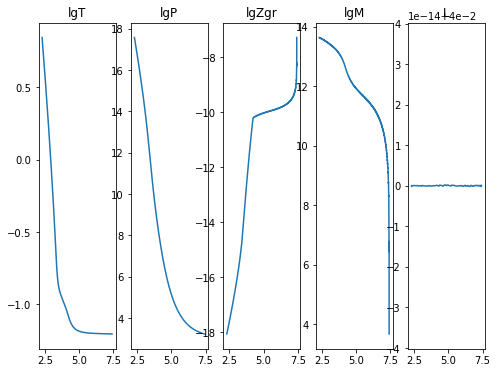

2020-11-16 03:10:04,396 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:10:05,187 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046251
2020-11-16 03:10:05,189 __main__ 0/1 INFO :: lgT iterate: 0.845552306051653
2020-11-16 03:10:05,189 __main__ 0/1 INFO :: lgP iterate: 17.596817720253313
2020-11-16 03:10:05,190 __main__ 0/1 INFO :: lgM iterate: 13.641115571532954
2020-11-16 03:10:05,191 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078625
2020-11-16 03:10:05,192 __main__ 0/1 INFO :: m iterate: 5.587645172511202e-05
2020-11-16 03:10:05,192 __main__ 0/1 INFO :: L iterate: 0.03999999999999996


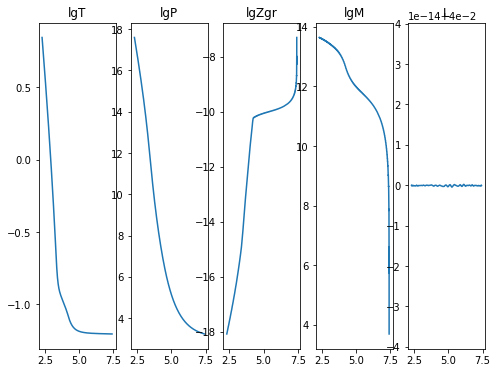

2020-11-16 03:10:08,931 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:10:10,019 __main__ 0/1 INFO :: Perturbation norm: 1.740464603204558
2020-11-16 03:10:10,021 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800363
2020-11-16 03:10:10,021 __main__ 0/1 INFO :: lgP iterate: 17.581556452902685
2020-11-16 03:10:10,022 __main__ 0/1 INFO :: lgM iterate: 13.641074669075056
2020-11-16 03:10:10,023 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950064
2020-11-16 03:10:10,024 __main__ 0/1 INFO :: m iterate: 5.504256301325228e-05
2020-11-16 03:10:10,024 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


2020-11-16 03:10:13,656 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:10:14,425 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046323
2020-11-16 03:10:14,426 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516524
2020-11-16 03:10:14,427 __main__ 0/1 INFO :: lgP iterate: 17.596817720253302
2020-11-16 03:10:14,428 __main__ 0/1 INFO :: lgM iterate: 13.641115571532943
2020-11-16 03:10:14,428 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078614
2020-11-16 03:10:14,429 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:10:14,430 __main__ 0/1 INFO :: L iterate: 0.03999999999999996


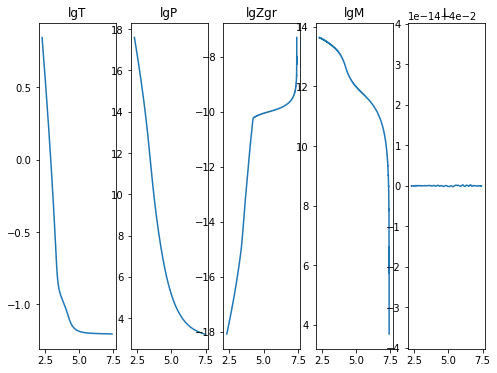

2020-11-16 03:10:18,091 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:10:19,049 __main__ 0/1 INFO :: Perturbation norm: 1.740464603204576
2020-11-16 03:10:19,050 __main__ 0/1 INFO :: lgT iterate: 0.844929764780036
2020-11-16 03:10:19,051 __main__ 0/1 INFO :: lgP iterate: 17.581556452902703
2020-11-16 03:10:19,052 __main__ 0/1 INFO :: lgM iterate: 13.641074669075115
2020-11-16 03:10:19,053 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950125
2020-11-16 03:10:19,054 __main__ 0/1 INFO :: m iterate: 5.504256300437049e-05
2020-11-16 03:10:19,055 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


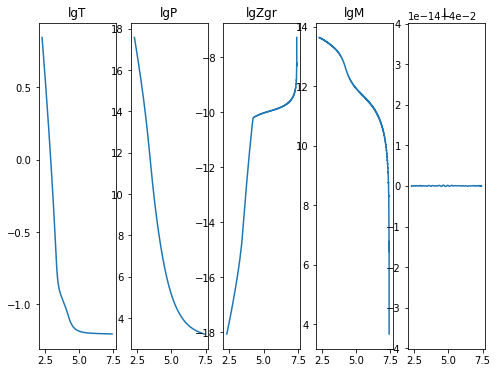

2020-11-16 03:10:22,671 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:10:23,491 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032047346
2020-11-16 03:10:23,493 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516537
2020-11-16 03:10:23,494 __main__ 0/1 INFO :: lgP iterate: 17.596817720253327
2020-11-16 03:10:23,494 __main__ 0/1 INFO :: lgM iterate: 13.641115571532996
2020-11-16 03:10:23,495 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078667
2020-11-16 03:10:23,496 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:10:23,497 __main__ 0/1 INFO :: L iterate: 0.04


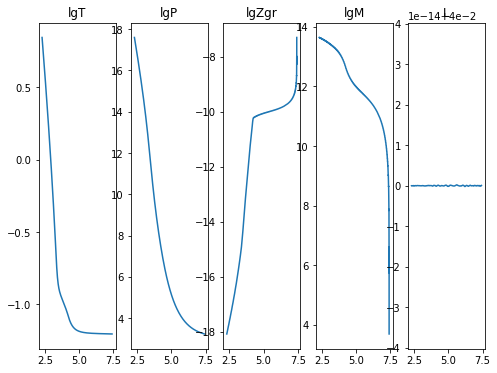

2020-11-16 03:10:27,672 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:10:28,627 __main__ 0/1 INFO :: Perturbation norm: 1.740464603205341
2020-11-16 03:10:28,628 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800348
2020-11-16 03:10:28,629 __main__ 0/1 INFO :: lgP iterate: 17.58155645290264
2020-11-16 03:10:28,630 __main__ 0/1 INFO :: lgM iterate: 13.641074669075078
2020-11-16 03:10:28,631 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950043
2020-11-16 03:10:28,632 __main__ 0/1 INFO :: m iterate: 5.504256301325228e-05
2020-11-16 03:10:28,633 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


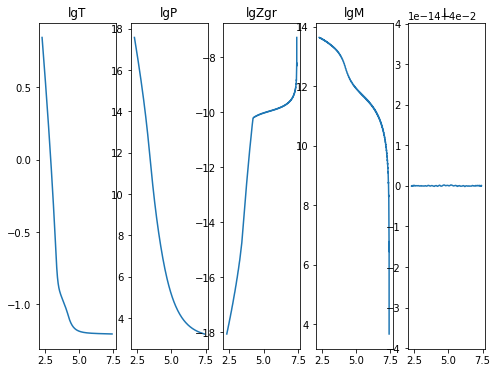

2020-11-16 03:10:32,226 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:10:33,027 __main__ 0/1 INFO :: Perturbation norm: 1.740464603205009
2020-11-16 03:10:33,028 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516523
2020-11-16 03:10:33,029 __main__ 0/1 INFO :: lgP iterate: 17.596817720253277
2020-11-16 03:10:33,030 __main__ 0/1 INFO :: lgM iterate: 13.641115571532918
2020-11-16 03:10:33,031 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078575
2020-11-16 03:10:33,032 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:10:33,033 __main__ 0/1 INFO :: L iterate: 0.03999999999999995


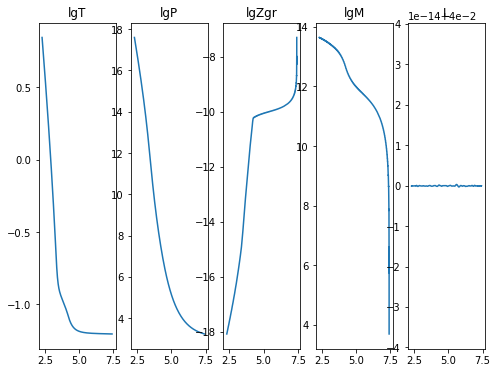

2020-11-16 03:10:37,735 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:10:38,941 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032049862
2020-11-16 03:10:38,942 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800367
2020-11-16 03:10:38,943 __main__ 0/1 INFO :: lgP iterate: 17.581556452902657
2020-11-16 03:10:38,944 __main__ 0/1 INFO :: lgM iterate: 13.641074669075117
2020-11-16 03:10:38,946 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695009
2020-11-16 03:10:38,948 __main__ 0/1 INFO :: m iterate: 5.5042563007923206e-05
2020-11-16 03:10:38,949 __main__ 0/1 INFO :: L iterate: 0.04


2020-11-16 03:10:43,661 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:10:44,486 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032047206
2020-11-16 03:10:44,487 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516523
2020-11-16 03:10:44,488 __main__ 0/1 INFO :: lgP iterate: 17.596817720253313
2020-11-16 03:10:44,489 __main__ 0/1 INFO :: lgM iterate: 13.641115571532962
2020-11-16 03:10:44,489 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507863
2020-11-16 03:10:44,490 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:10:44,491 __main__ 0/1 INFO :: L iterate: 0.04


2020-11-16 03:10:48,304 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:10:49,425 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032040334
2020-11-16 03:10:49,426 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800359
2020-11-16 03:10:49,427 __main__ 0/1 INFO :: lgP iterate: 17.58155645290264
2020-11-16 03:10:49,428 __main__ 0/1 INFO :: lgM iterate: 13.64107466907507
2020-11-16 03:10:49,429 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950047
2020-11-16 03:10:49,430 __main__ 0/1 INFO :: m iterate: 5.504256300703503e-05
2020-11-16 03:10:49,431 __main__ 0/1 INFO :: L iterate: 0.04


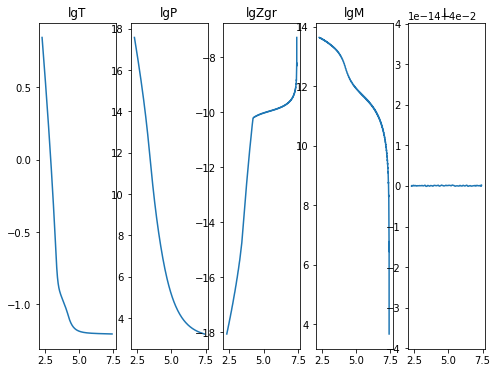

2020-11-16 03:10:53,821 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:10:54,746 __main__ 0/1 INFO :: Perturbation norm: 1.740464603203888
2020-11-16 03:10:54,747 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516531
2020-11-16 03:10:54,748 __main__ 0/1 INFO :: lgP iterate: 17.596817720253313
2020-11-16 03:10:54,749 __main__ 0/1 INFO :: lgM iterate: 13.641115571533
2020-11-16 03:10:54,750 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507866
2020-11-16 03:10:54,751 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:10:54,752 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


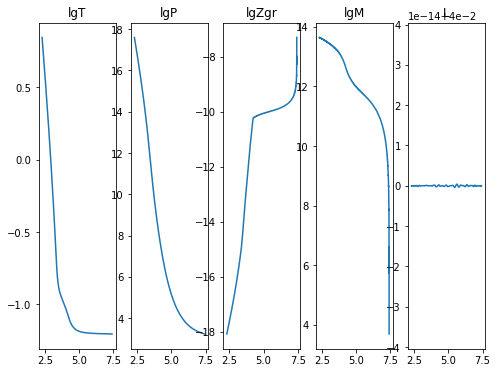

2020-11-16 03:10:58,918 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:10:59,944 __main__ 0/1 INFO :: Perturbation norm: 1.740464603203498
2020-11-16 03:10:59,945 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800349
2020-11-16 03:10:59,946 __main__ 0/1 INFO :: lgP iterate: 17.58155645290269
2020-11-16 03:10:59,947 __main__ 0/1 INFO :: lgM iterate: 13.641074669075113
2020-11-16 03:10:59,948 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695011
2020-11-16 03:10:59,948 __main__ 0/1 INFO :: m iterate: 5.504256300703503e-05
2020-11-16 03:10:59,949 __main__ 0/1 INFO :: L iterate: 0.04


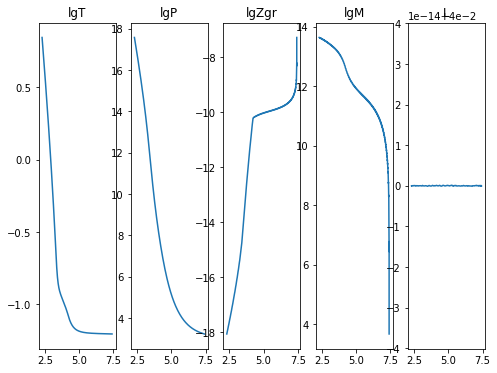

2020-11-16 03:11:03,503 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:11:04,330 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032038338
2020-11-16 03:11:04,331 __main__ 0/1 INFO :: lgT iterate: 0.845552306051653
2020-11-16 03:11:04,332 __main__ 0/1 INFO :: lgP iterate: 17.596817720253284
2020-11-16 03:11:04,333 __main__ 0/1 INFO :: lgM iterate: 13.641115571532904
2020-11-16 03:11:04,333 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078568
2020-11-16 03:11:04,334 __main__ 0/1 INFO :: m iterate: 5.5876451726888376e-05
2020-11-16 03:11:04,335 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


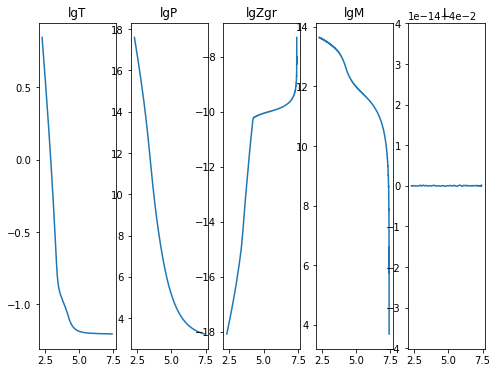

2020-11-16 03:11:07,924 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:11:08,968 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032045632
2020-11-16 03:11:08,970 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800367
2020-11-16 03:11:08,971 __main__ 0/1 INFO :: lgP iterate: 17.581556452902642
2020-11-16 03:11:08,972 __main__ 0/1 INFO :: lgM iterate: 13.641074669075067
2020-11-16 03:11:08,973 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695004
2020-11-16 03:11:08,974 __main__ 0/1 INFO :: m iterate: 5.504256301325228e-05
2020-11-16 03:11:08,975 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


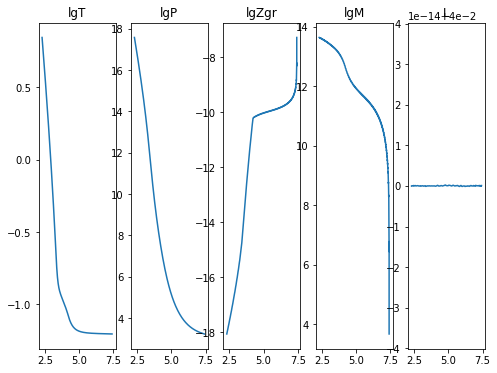

2020-11-16 03:11:13,691 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 03:11:14,617 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046553
2020-11-16 03:11:14,618 __main__ 0/1 INFO :: lgT iterate: 0.845552306051653
2020-11-16 03:11:14,622 __main__ 0/1 INFO :: lgP iterate: 17.596817720253316
2020-11-16 03:11:14,625 __main__ 0/1 INFO :: lgM iterate: 13.64111557153291
2020-11-16 03:11:14,628 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078607
2020-11-16 03:11:14,632 __main__ 0/1 INFO :: m iterate: 5.58764517260002e-05
2020-11-16 03:11:14,635 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


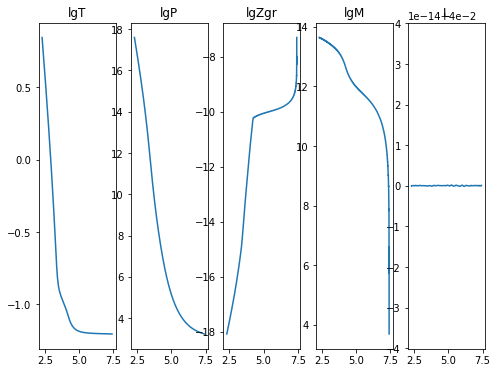

2020-11-16 03:11:19,098 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:11:20,221 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044526
2020-11-16 03:11:20,222 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800369
2020-11-16 03:11:20,223 __main__ 0/1 INFO :: lgP iterate: 17.58155645290266
2020-11-16 03:11:20,224 __main__ 0/1 INFO :: lgM iterate: 13.641074669075106
2020-11-16 03:11:20,225 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695008
2020-11-16 03:11:20,226 __main__ 0/1 INFO :: m iterate: 5.50425630123641e-05
2020-11-16 03:11:20,227 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


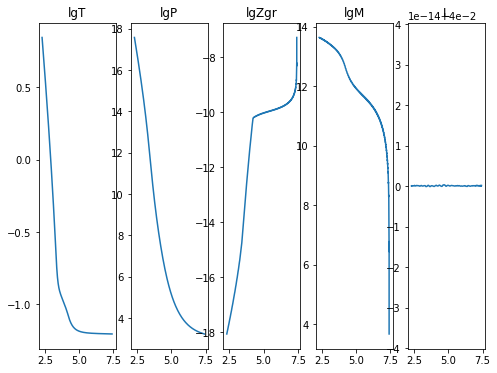

2020-11-16 03:11:25,391 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 03:11:26,343 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032037325
2020-11-16 03:11:26,344 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516531
2020-11-16 03:11:26,345 __main__ 0/1 INFO :: lgP iterate: 17.596817720253284
2020-11-16 03:11:26,346 __main__ 0/1 INFO :: lgM iterate: 13.641115571532897
2020-11-16 03:11:26,347 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507856
2020-11-16 03:11:26,348 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:11:26,349 __main__ 0/1 INFO :: L iterate: 0.04


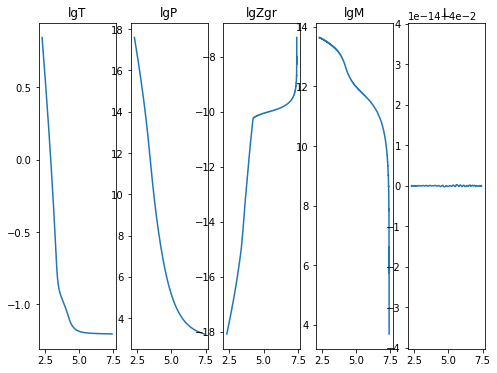

2020-11-16 03:11:30,774 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:11:32,390 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032031956
2020-11-16 03:11:32,392 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800362
2020-11-16 03:11:32,394 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:11:32,395 __main__ 0/1 INFO :: lgM iterate: 13.641074669075063
2020-11-16 03:11:32,396 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950054
2020-11-16 03:11:32,398 __main__ 0/1 INFO :: m iterate: 5.504256301147592e-05
2020-11-16 03:11:32,399 __main__ 0/1 INFO :: L iterate: 0.04


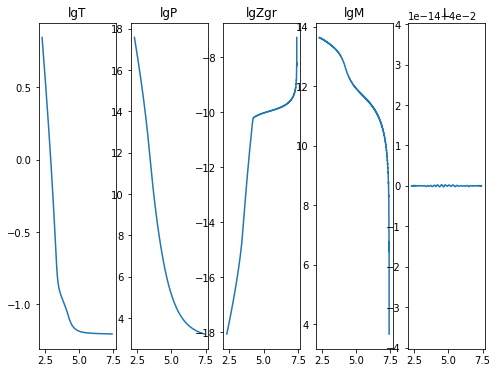

2020-11-16 03:11:36,682 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2020-11-16 03:11:37,549 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032036037
2020-11-16 03:11:37,550 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516525
2020-11-16 03:11:37,551 __main__ 0/1 INFO :: lgP iterate: 17.596817720253306
2020-11-16 03:11:37,552 __main__ 0/1 INFO :: lgM iterate: 13.641115571532966
2020-11-16 03:11:37,552 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078625
2020-11-16 03:11:37,553 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:11:37,554 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


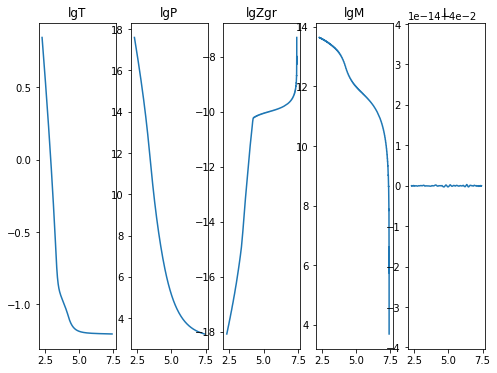

2020-11-16 03:11:41,744 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:11:42,907 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032037365
2020-11-16 03:11:42,908 __main__ 0/1 INFO :: lgT iterate: 0.844929764780038
2020-11-16 03:11:42,909 __main__ 0/1 INFO :: lgP iterate: 17.581556452902703
2020-11-16 03:11:42,910 __main__ 0/1 INFO :: lgM iterate: 13.641074669075136
2020-11-16 03:11:42,911 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695014
2020-11-16 03:11:42,912 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:11:42,913 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


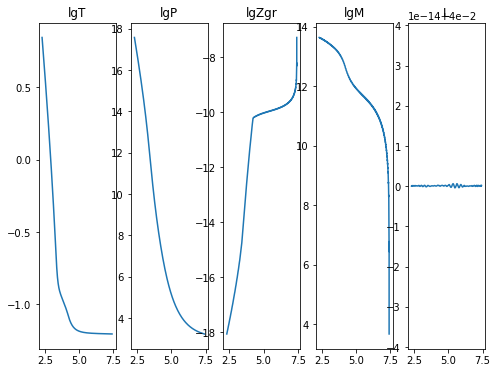

2020-11-16 03:11:46,868 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:11:47,786 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032037445
2020-11-16 03:11:47,788 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516525
2020-11-16 03:11:47,789 __main__ 0/1 INFO :: lgP iterate: 17.5968177202533
2020-11-16 03:11:47,789 __main__ 0/1 INFO :: lgM iterate: 13.641115571532932
2020-11-16 03:11:47,790 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078596
2020-11-16 03:11:47,791 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:11:47,792 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


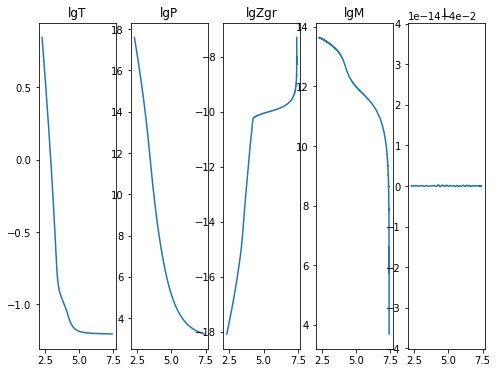

2020-11-16 03:11:51,668 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:11:53,036 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032039
2020-11-16 03:11:53,037 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800349
2020-11-16 03:11:53,038 __main__ 0/1 INFO :: lgP iterate: 17.58155645290267
2020-11-16 03:11:53,039 __main__ 0/1 INFO :: lgM iterate: 13.641074669075074
2020-11-16 03:11:53,040 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695007
2020-11-16 03:11:53,041 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:11:53,041 __main__ 0/1 INFO :: L iterate: 0.04


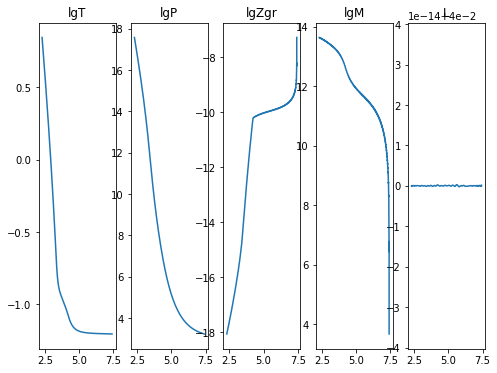

2020-11-16 03:11:57,088 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:11:58,093 __main__ 0/1 INFO :: Perturbation norm: 1.74046460320451
2020-11-16 03:11:58,095 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516533
2020-11-16 03:11:58,096 __main__ 0/1 INFO :: lgP iterate: 17.596817720253334
2020-11-16 03:11:58,097 __main__ 0/1 INFO :: lgM iterate: 13.641115571532938
2020-11-16 03:11:58,098 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507864
2020-11-16 03:11:58,099 __main__ 0/1 INFO :: m iterate: 5.5876451733105625e-05
2020-11-16 03:11:58,100 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


2020-11-16 03:12:02,440 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:12:03,538 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032048094
2020-11-16 03:12:03,539 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800355
2020-11-16 03:12:03,540 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:12:03,541 __main__ 0/1 INFO :: lgM iterate: 13.641074669075076
2020-11-16 03:12:03,542 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950068
2020-11-16 03:12:03,543 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:12:03,544 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


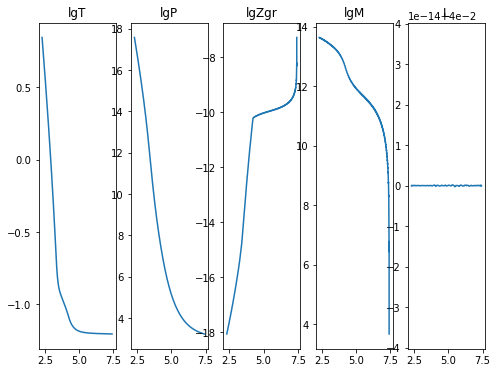

2020-11-16 03:12:08,514 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2020-11-16 03:12:10,409 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032045739
2020-11-16 03:12:10,410 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516523
2020-11-16 03:12:10,411 __main__ 0/1 INFO :: lgP iterate: 17.5968177202533
2020-11-16 03:12:10,412 __main__ 0/1 INFO :: lgM iterate: 13.641115571532946
2020-11-16 03:12:10,413 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078603
2020-11-16 03:12:10,414 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:12:10,415 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


2020-11-16 03:12:16,146 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:12:17,641 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046605
2020-11-16 03:12:17,642 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800373
2020-11-16 03:12:17,644 __main__ 0/1 INFO :: lgP iterate: 17.581556452902696
2020-11-16 03:12:17,645 __main__ 0/1 INFO :: lgM iterate: 13.64107466907512
2020-11-16 03:12:17,646 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950125
2020-11-16 03:12:17,647 __main__ 0/1 INFO :: m iterate: 5.504256300703503e-05
2020-11-16 03:12:17,647 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


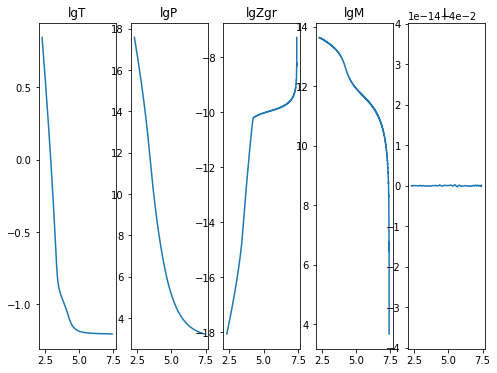

2020-11-16 03:12:22,624 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 03:12:25,153 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032047035
2020-11-16 03:12:25,155 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516523
2020-11-16 03:12:25,156 __main__ 0/1 INFO :: lgP iterate: 17.59681772025329
2020-11-16 03:12:25,157 __main__ 0/1 INFO :: lgM iterate: 13.641115571532906
2020-11-16 03:12:25,158 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078582
2020-11-16 03:12:25,160 __main__ 0/1 INFO :: m iterate: 5.58764517260002e-05
2020-11-16 03:12:25,161 __main__ 0/1 INFO :: L iterate: 0.04


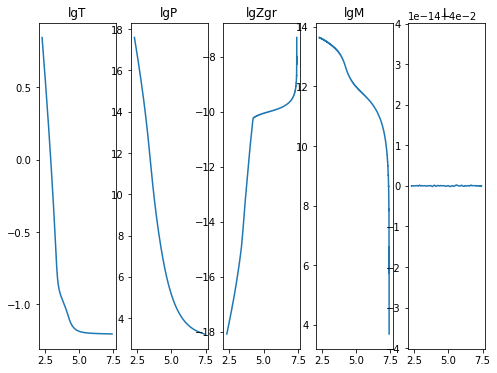

2020-11-16 03:12:29,992 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 03:12:31,111 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032049502
2020-11-16 03:12:31,112 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800333
2020-11-16 03:12:31,113 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:12:31,113 __main__ 0/1 INFO :: lgM iterate: 13.641074669075145
2020-11-16 03:12:31,114 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695012
2020-11-16 03:12:31,115 __main__ 0/1 INFO :: m iterate: 5.50425630123641e-05
2020-11-16 03:12:31,115 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


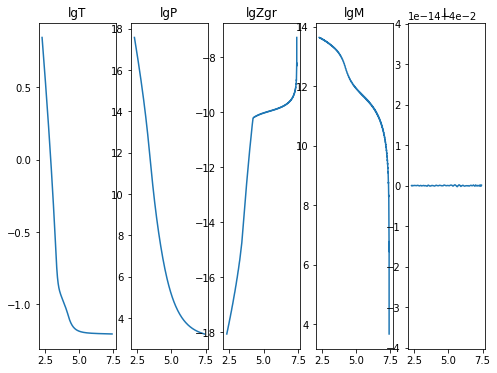

2020-11-16 03:12:34,712 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:12:35,474 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032047197
2020-11-16 03:12:35,475 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516529
2020-11-16 03:12:35,476 __main__ 0/1 INFO :: lgP iterate: 17.596817720253302
2020-11-16 03:12:35,477 __main__ 0/1 INFO :: lgM iterate: 13.641115571532927
2020-11-16 03:12:35,478 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078596
2020-11-16 03:12:35,479 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:12:35,480 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


2020-11-16 03:12:39,391 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:12:40,373 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032045967
2020-11-16 03:12:40,374 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800352
2020-11-16 03:12:40,375 __main__ 0/1 INFO :: lgP iterate: 17.581556452902646
2020-11-16 03:12:40,376 __main__ 0/1 INFO :: lgM iterate: 13.641074669075124
2020-11-16 03:12:40,376 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950082
2020-11-16 03:12:40,377 __main__ 0/1 INFO :: m iterate: 5.5042563008811385e-05
2020-11-16 03:12:40,378 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


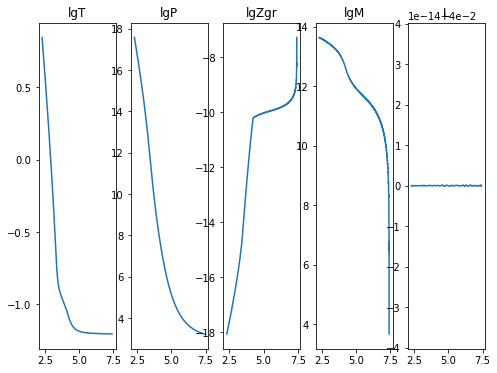

2020-11-16 03:12:43,974 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:12:44,797 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044877
2020-11-16 03:12:44,798 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516525
2020-11-16 03:12:44,799 __main__ 0/1 INFO :: lgP iterate: 17.59681772025332
2020-11-16 03:12:44,800 __main__ 0/1 INFO :: lgM iterate: 13.641115571532943
2020-11-16 03:12:44,801 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078632
2020-11-16 03:12:44,802 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:12:44,803 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


2020-11-16 03:12:48,829 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:12:49,858 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032038058
2020-11-16 03:12:49,859 __main__ 0/1 INFO :: lgT iterate: 0.844929764780036
2020-11-16 03:12:49,860 __main__ 0/1 INFO :: lgP iterate: 17.581556452902692
2020-11-16 03:12:49,861 __main__ 0/1 INFO :: lgM iterate: 13.64107466907512
2020-11-16 03:12:49,862 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695011
2020-11-16 03:12:49,863 __main__ 0/1 INFO :: m iterate: 5.504256300525867e-05
2020-11-16 03:12:49,864 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


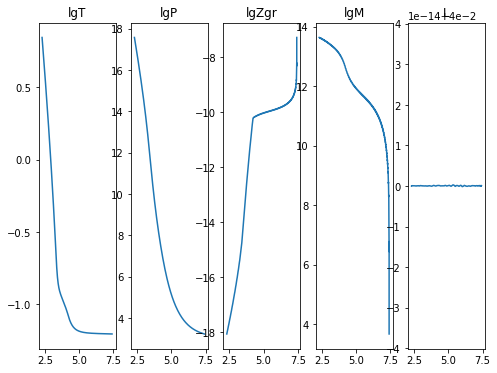

2020-11-16 03:12:53,643 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:12:54,504 __main__ 0/1 INFO :: Perturbation norm: 1.740464603204028
2020-11-16 03:12:54,505 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516537
2020-11-16 03:12:54,506 __main__ 0/1 INFO :: lgP iterate: 17.5968177202533
2020-11-16 03:12:54,507 __main__ 0/1 INFO :: lgM iterate: 13.641115571532982
2020-11-16 03:12:54,507 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078635
2020-11-16 03:12:54,508 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:12:54,509 __main__ 0/1 INFO :: L iterate: 0.04


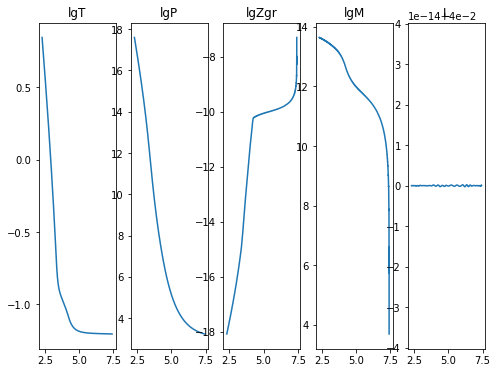

2020-11-16 03:12:58,423 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:12:59,968 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046296
2020-11-16 03:12:59,969 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800368
2020-11-16 03:12:59,970 __main__ 0/1 INFO :: lgP iterate: 17.581556452902674
2020-11-16 03:12:59,971 __main__ 0/1 INFO :: lgM iterate: 13.641074669075113
2020-11-16 03:12:59,972 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950096
2020-11-16 03:12:59,973 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:12:59,973 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


2020-11-16 03:13:03,734 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:13:04,545 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032047637
2020-11-16 03:13:04,546 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516522
2020-11-16 03:13:04,547 __main__ 0/1 INFO :: lgP iterate: 17.5968177202533
2020-11-16 03:13:04,548 __main__ 0/1 INFO :: lgM iterate: 13.641115571532957
2020-11-16 03:13:04,549 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078618
2020-11-16 03:13:04,550 __main__ 0/1 INFO :: m iterate: 5.587645172511202e-05
2020-11-16 03:13:04,551 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


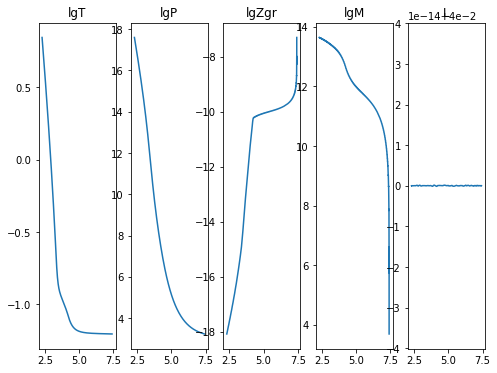

2020-11-16 03:13:08,475 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:13:09,647 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032049151
2020-11-16 03:13:09,649 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800362
2020-11-16 03:13:09,650 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:13:09,651 __main__ 0/1 INFO :: lgM iterate: 13.641074669075122
2020-11-16 03:13:09,652 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950107
2020-11-16 03:13:09,653 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:13:09,654 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


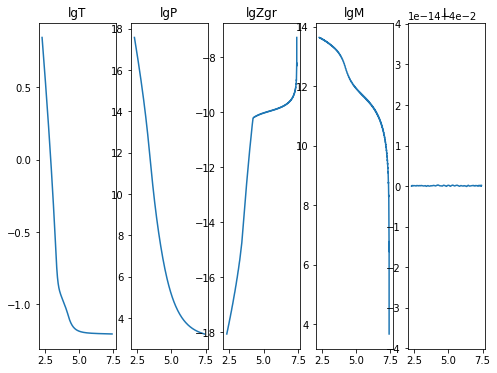

2020-11-16 03:13:14,137 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:13:15,072 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044695
2020-11-16 03:13:15,073 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516531
2020-11-16 03:13:15,074 __main__ 0/1 INFO :: lgP iterate: 17.59681772025328
2020-11-16 03:13:15,075 __main__ 0/1 INFO :: lgM iterate: 13.641115571532957
2020-11-16 03:13:15,076 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078596
2020-11-16 03:13:15,077 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:13:15,078 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


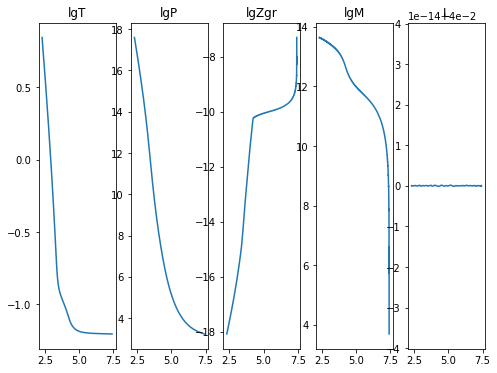

2020-11-16 03:13:19,708 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:13:20,827 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032045057
2020-11-16 03:13:20,828 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800358
2020-11-16 03:13:20,829 __main__ 0/1 INFO :: lgP iterate: 17.58155645290265
2020-11-16 03:13:20,830 __main__ 0/1 INFO :: lgM iterate: 13.641074669075127
2020-11-16 03:13:20,831 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950082
2020-11-16 03:13:20,832 __main__ 0/1 INFO :: m iterate: 5.504256300703503e-05
2020-11-16 03:13:20,833 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


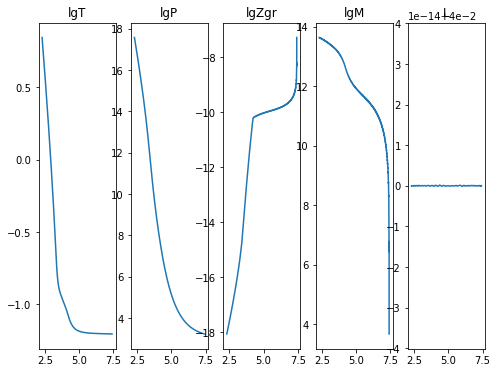

2020-11-16 03:13:25,236 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:13:25,982 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044697
2020-11-16 03:13:25,983 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516523
2020-11-16 03:13:25,984 __main__ 0/1 INFO :: lgP iterate: 17.5968177202533
2020-11-16 03:13:25,985 __main__ 0/1 INFO :: lgM iterate: 13.641115571532895
2020-11-16 03:13:25,985 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078582
2020-11-16 03:13:25,986 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:13:25,987 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


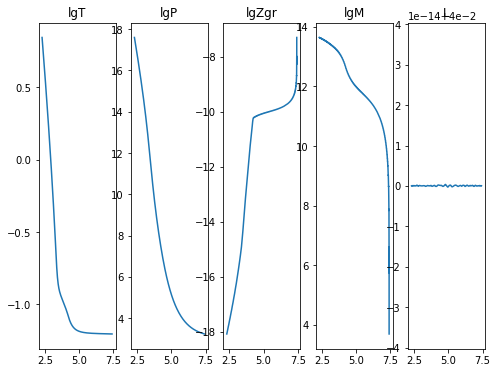

2020-11-16 03:13:29,625 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:13:31,144 __main__ 0/1 INFO :: Perturbation norm: 1.740464603203557
2020-11-16 03:13:31,145 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800369
2020-11-16 03:13:31,146 __main__ 0/1 INFO :: lgP iterate: 17.581556452902717
2020-11-16 03:13:31,146 __main__ 0/1 INFO :: lgM iterate: 13.641074669075177
2020-11-16 03:13:31,147 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950175
2020-11-16 03:13:31,148 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:13:31,149 __main__ 0/1 INFO :: L iterate: 0.04


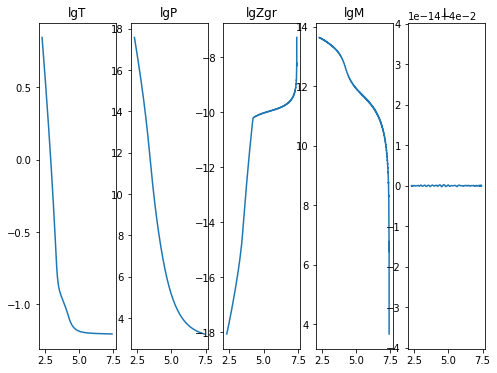

2020-11-16 03:13:35,549 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:13:36,758 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032034903
2020-11-16 03:13:36,759 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516528
2020-11-16 03:13:36,760 __main__ 0/1 INFO :: lgP iterate: 17.596817720253306
2020-11-16 03:13:36,761 __main__ 0/1 INFO :: lgM iterate: 13.641115571532904
2020-11-16 03:13:36,762 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078593
2020-11-16 03:13:36,763 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:13:36,764 __main__ 0/1 INFO :: L iterate: 0.04


2020-11-16 03:13:41,100 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:13:42,080 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032034936
2020-11-16 03:13:42,081 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800367
2020-11-16 03:13:42,082 __main__ 0/1 INFO :: lgP iterate: 17.58155645290269
2020-11-16 03:13:42,083 __main__ 0/1 INFO :: lgM iterate: 13.6410746690751
2020-11-16 03:13:42,084 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950103
2020-11-16 03:13:42,085 __main__ 0/1 INFO :: m iterate: 5.504256300703503e-05
2020-11-16 03:13:42,086 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


2020-11-16 03:13:46,147 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 03:13:47,570 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032037614
2020-11-16 03:13:47,572 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516525
2020-11-16 03:13:47,574 __main__ 0/1 INFO :: lgP iterate: 17.59681772025332
2020-11-16 03:13:47,576 __main__ 0/1 INFO :: lgM iterate: 13.64111557153295
2020-11-16 03:13:47,577 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078635
2020-11-16 03:13:47,578 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:13:47,579 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


2020-11-16 03:13:52,008 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:13:53,025 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032040663
2020-11-16 03:13:53,026 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800369
2020-11-16 03:13:53,027 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:13:53,028 __main__ 0/1 INFO :: lgM iterate: 13.641074669075122
2020-11-16 03:13:53,029 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950096
2020-11-16 03:13:53,030 __main__ 0/1 INFO :: m iterate: 5.504256301147592e-05
2020-11-16 03:13:53,030 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


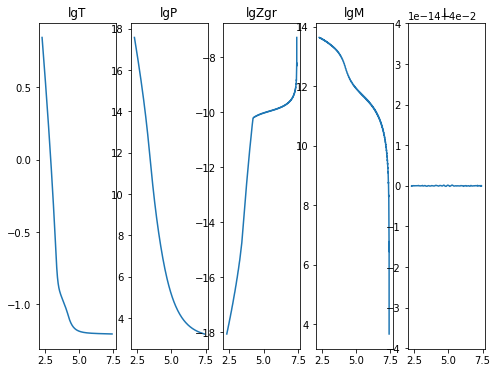

2020-11-16 03:13:57,978 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2020-11-16 03:13:58,911 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032040927
2020-11-16 03:13:58,914 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516545
2020-11-16 03:13:58,915 __main__ 0/1 INFO :: lgP iterate: 17.596817720253334
2020-11-16 03:13:58,915 __main__ 0/1 INFO :: lgM iterate: 13.641115571532954
2020-11-16 03:13:58,916 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078646
2020-11-16 03:13:58,917 __main__ 0/1 INFO :: m iterate: 5.5876451727776555e-05
2020-11-16 03:13:58,917 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


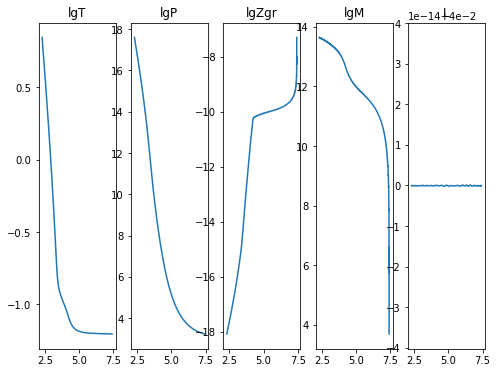

2020-11-16 03:14:04,585 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 03:14:05,965 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032043536
2020-11-16 03:14:05,967 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800372
2020-11-16 03:14:05,967 __main__ 0/1 INFO :: lgP iterate: 17.58155645290266
2020-11-16 03:14:05,968 __main__ 0/1 INFO :: lgM iterate: 13.641074669075111
2020-11-16 03:14:05,969 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695009
2020-11-16 03:14:05,970 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:14:05,971 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


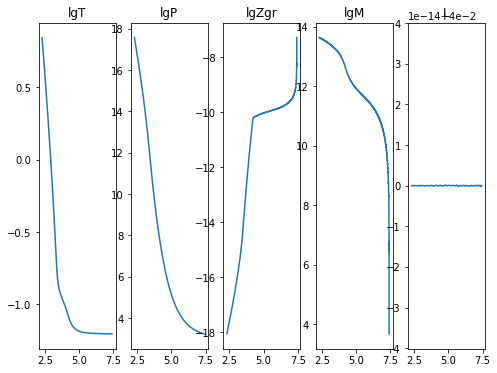

2020-11-16 03:14:10,794 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:14:11,630 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046567
2020-11-16 03:14:11,631 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516524
2020-11-16 03:14:11,632 __main__ 0/1 INFO :: lgP iterate: 17.5968177202533
2020-11-16 03:14:11,632 __main__ 0/1 INFO :: lgM iterate: 13.641115571532941
2020-11-16 03:14:11,633 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078603
2020-11-16 03:14:11,634 __main__ 0/1 INFO :: m iterate: 5.5876451726888376e-05
2020-11-16 03:14:11,635 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


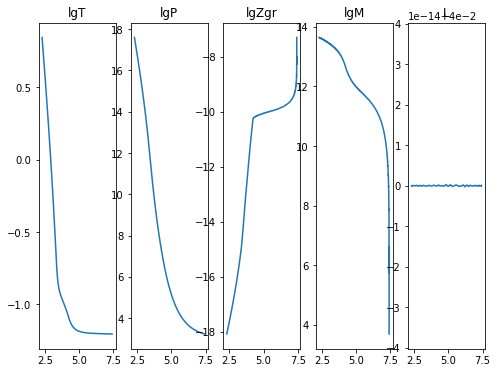

2020-11-16 03:14:16,696 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 03:14:17,806 __main__ 0/1 INFO :: Perturbation norm: 1.740464603205121
2020-11-16 03:14:17,807 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800348
2020-11-16 03:14:17,808 __main__ 0/1 INFO :: lgP iterate: 17.58155645290267
2020-11-16 03:14:17,809 __main__ 0/1 INFO :: lgM iterate: 13.641074669075135
2020-11-16 03:14:17,809 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950107
2020-11-16 03:14:17,810 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:14:17,811 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


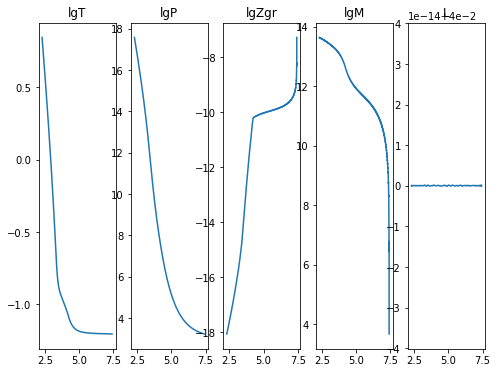

2020-11-16 03:14:22,854 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:14:23,594 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032053512
2020-11-16 03:14:23,595 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516528
2020-11-16 03:14:23,596 __main__ 0/1 INFO :: lgP iterate: 17.596817720253313
2020-11-16 03:14:23,596 __main__ 0/1 INFO :: lgM iterate: 13.64111557153294
2020-11-16 03:14:23,597 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078618
2020-11-16 03:14:23,598 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:14:23,599 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


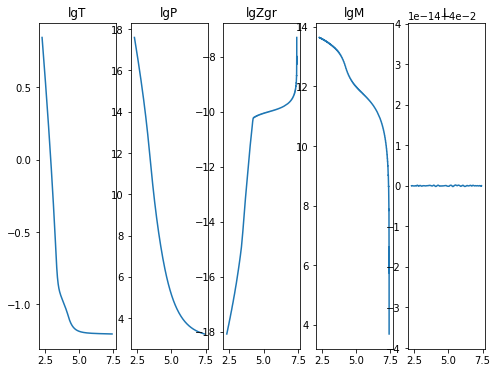

2020-11-16 03:14:29,068 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:14:30,254 __main__ 0/1 INFO :: Perturbation norm: 1.74046460320544
2020-11-16 03:14:30,255 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800353
2020-11-16 03:14:30,256 __main__ 0/1 INFO :: lgP iterate: 17.581556452902653
2020-11-16 03:14:30,257 __main__ 0/1 INFO :: lgM iterate: 13.641074669075083
2020-11-16 03:14:30,258 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950057
2020-11-16 03:14:30,259 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:14:30,260 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


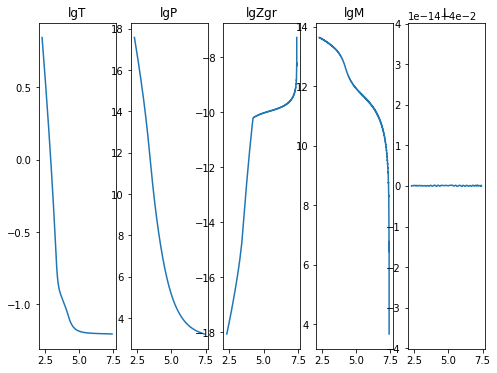

2020-11-16 03:14:35,053 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:14:36,250 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032051512
2020-11-16 03:14:36,251 __main__ 0/1 INFO :: lgT iterate: 0.845552306051653
2020-11-16 03:14:36,251 __main__ 0/1 INFO :: lgP iterate: 17.596817720253306
2020-11-16 03:14:36,252 __main__ 0/1 INFO :: lgM iterate: 13.641115571532891
2020-11-16 03:14:36,253 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507858
2020-11-16 03:14:36,254 __main__ 0/1 INFO :: m iterate: 5.5876451733993804e-05
2020-11-16 03:14:36,255 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


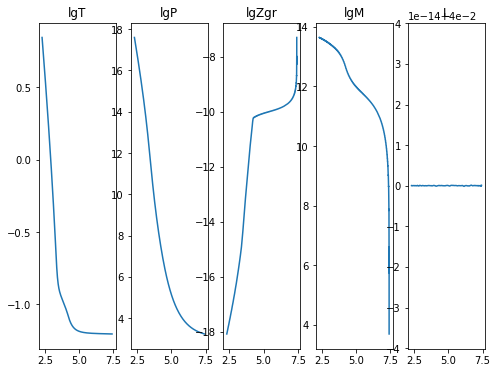

2020-11-16 03:14:40,575 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:14:41,947 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032047641
2020-11-16 03:14:41,949 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800353
2020-11-16 03:14:41,949 __main__ 0/1 INFO :: lgP iterate: 17.58155645290268
2020-11-16 03:14:41,951 __main__ 0/1 INFO :: lgM iterate: 13.641074669075103
2020-11-16 03:14:41,953 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950114
2020-11-16 03:14:41,954 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:14:41,955 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


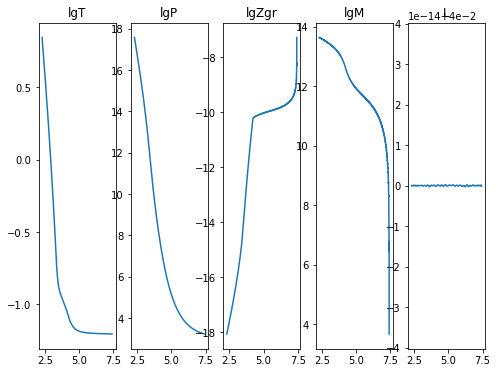

2020-11-16 03:14:46,130 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2020-11-16 03:14:47,151 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032048665
2020-11-16 03:14:47,152 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516528
2020-11-16 03:14:47,153 __main__ 0/1 INFO :: lgP iterate: 17.59681772025331
2020-11-16 03:14:47,154 __main__ 0/1 INFO :: lgM iterate: 13.641115571532975
2020-11-16 03:14:47,155 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507864
2020-11-16 03:14:47,156 __main__ 0/1 INFO :: m iterate: 5.587645173132927e-05
2020-11-16 03:14:47,156 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


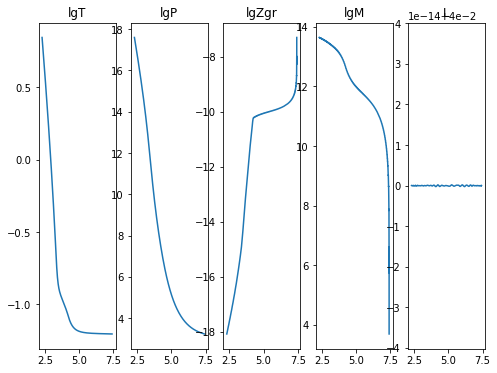

2020-11-16 03:14:50,760 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
2020-11-16 03:14:51,719 __main__ 0/1 INFO :: Perturbation norm: 1.74046460320495
2020-11-16 03:14:51,720 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800376
2020-11-16 03:14:51,721 __main__ 0/1 INFO :: lgP iterate: 17.581556452902696
2020-11-16 03:14:51,722 __main__ 0/1 INFO :: lgM iterate: 13.641074669075193
2020-11-16 03:14:51,723 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950175
2020-11-16 03:14:51,724 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:14:51,725 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


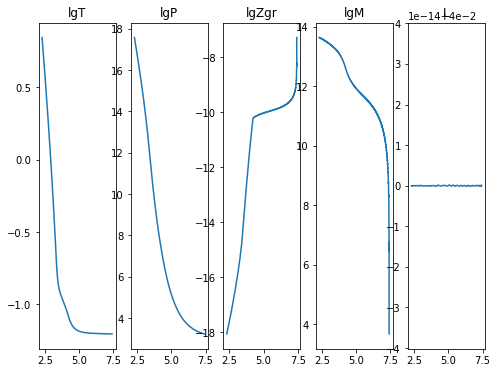

2020-11-16 03:14:55,284 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:14:56,051 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032052253
2020-11-16 03:14:56,052 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516545
2020-11-16 03:14:56,053 __main__ 0/1 INFO :: lgP iterate: 17.59681772025333
2020-11-16 03:14:56,054 __main__ 0/1 INFO :: lgM iterate: 13.641115571532954
2020-11-16 03:14:56,055 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078635
2020-11-16 03:14:56,056 __main__ 0/1 INFO :: m iterate: 5.5876451733993804e-05
2020-11-16 03:14:56,057 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


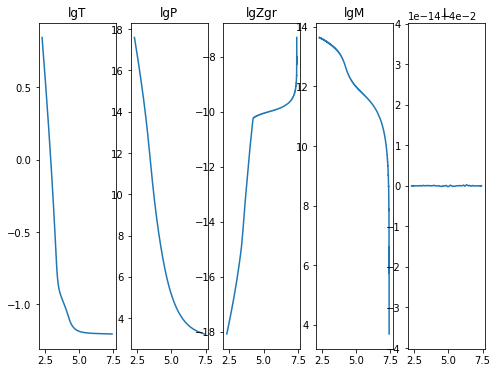

2020-11-16 03:14:59,615 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:15:00,564 __main__ 0/1 INFO :: Perturbation norm: 1.74046460320577
2020-11-16 03:15:00,565 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800376
2020-11-16 03:15:00,566 __main__ 0/1 INFO :: lgP iterate: 17.581556452902646
2020-11-16 03:15:00,567 __main__ 0/1 INFO :: lgM iterate: 13.641074669075131
2020-11-16 03:15:00,568 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950086
2020-11-16 03:15:00,569 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:15:00,570 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


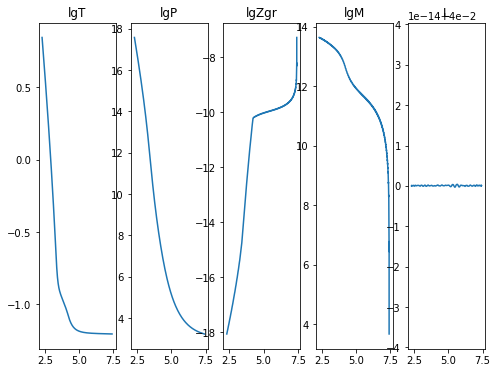

2020-11-16 03:15:04,102 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
2020-11-16 03:15:04,880 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032051032
2020-11-16 03:15:04,881 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516528
2020-11-16 03:15:04,881 __main__ 0/1 INFO :: lgP iterate: 17.5968177202533
2020-11-16 03:15:04,882 __main__ 0/1 INFO :: lgM iterate: 13.64111557153295
2020-11-16 03:15:04,883 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507861
2020-11-16 03:15:04,884 __main__ 0/1 INFO :: m iterate: 5.58764517260002e-05
2020-11-16 03:15:04,884 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


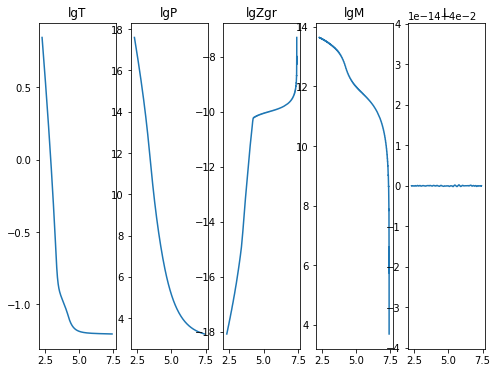

2020-11-16 03:15:08,764 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:15:10,064 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044735
2020-11-16 03:15:10,066 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800345
2020-11-16 03:15:10,066 __main__ 0/1 INFO :: lgP iterate: 17.581556452902664
2020-11-16 03:15:10,067 __main__ 0/1 INFO :: lgM iterate: 13.64107466907506
2020-11-16 03:15:10,069 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950054
2020-11-16 03:15:10,070 __main__ 0/1 INFO :: m iterate: 5.5042563007923206e-05
2020-11-16 03:15:10,071 __main__ 0/1 INFO :: L iterate: 0.04


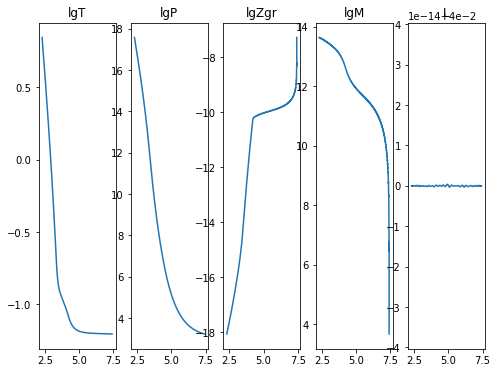

2020-11-16 03:15:14,515 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:15:15,369 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032049125
2020-11-16 03:15:15,370 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516541
2020-11-16 03:15:15,371 __main__ 0/1 INFO :: lgP iterate: 17.596817720253316
2020-11-16 03:15:15,372 __main__ 0/1 INFO :: lgM iterate: 13.641115571532954
2020-11-16 03:15:15,373 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507864
2020-11-16 03:15:15,374 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:15:15,375 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


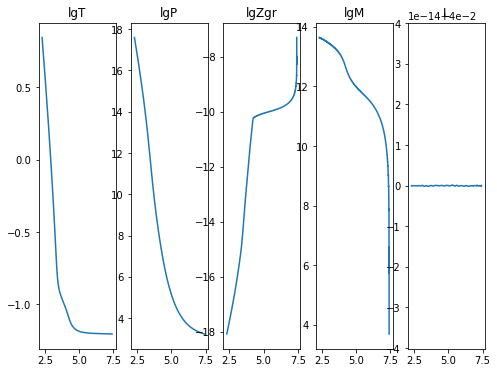

2020-11-16 03:15:19,800 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:15:21,021 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032050137
2020-11-16 03:15:21,022 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800375
2020-11-16 03:15:21,023 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:15:21,023 __main__ 0/1 INFO :: lgM iterate: 13.641074669075078
2020-11-16 03:15:21,024 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695008
2020-11-16 03:15:21,025 __main__ 0/1 INFO :: m iterate: 5.504256301325228e-05
2020-11-16 03:15:21,026 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


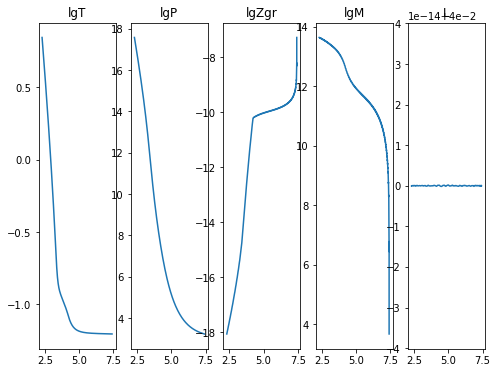

2020-11-16 03:15:25,435 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:15:26,590 __main__ 0/1 INFO :: Perturbation norm: 1.740464603204856
2020-11-16 03:15:26,591 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516528
2020-11-16 03:15:26,592 __main__ 0/1 INFO :: lgP iterate: 17.59681772025329
2020-11-16 03:15:26,593 __main__ 0/1 INFO :: lgM iterate: 13.641115571532895
2020-11-16 03:15:26,594 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078568
2020-11-16 03:15:26,595 __main__ 0/1 INFO :: m iterate: 5.587645173132927e-05
2020-11-16 03:15:26,596 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


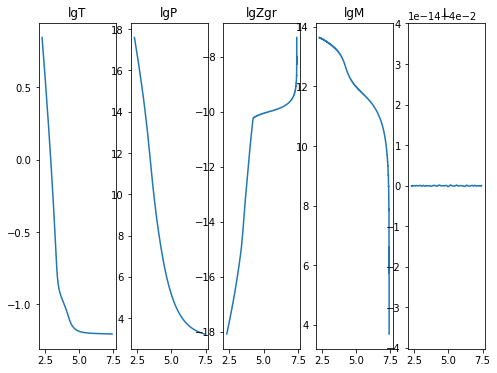

2020-11-16 03:15:30,774 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:15:31,874 __main__ 0/1 INFO :: Perturbation norm: 1.74046460320499
2020-11-16 03:15:31,875 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800371
2020-11-16 03:15:31,876 __main__ 0/1 INFO :: lgP iterate: 17.581556452902674
2020-11-16 03:15:31,878 __main__ 0/1 INFO :: lgM iterate: 13.641074669075092
2020-11-16 03:15:31,879 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950086
2020-11-16 03:15:31,880 __main__ 0/1 INFO :: m iterate: 5.5042563007923206e-05
2020-11-16 03:15:31,881 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


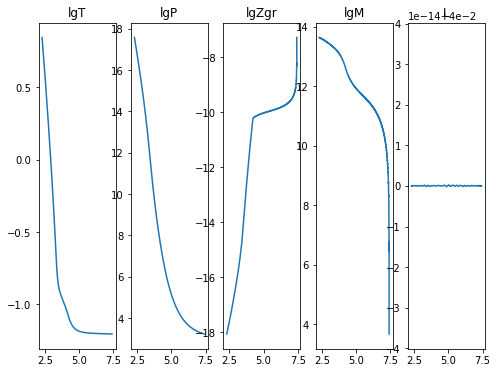

2020-11-16 03:15:36,218 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:15:37,279 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046505
2020-11-16 03:15:37,280 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516525
2020-11-16 03:15:37,281 __main__ 0/1 INFO :: lgP iterate: 17.596817720253284
2020-11-16 03:15:37,282 __main__ 0/1 INFO :: lgM iterate: 13.641115571532895
2020-11-16 03:15:37,283 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078564
2020-11-16 03:15:37,285 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:15:37,286 __main__ 0/1 INFO :: L iterate: 0.04


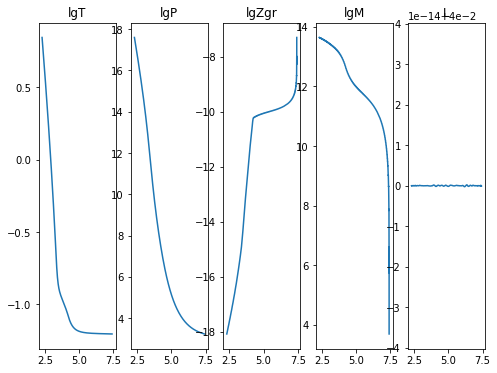

2020-11-16 03:15:41,340 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:15:42,517 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044782
2020-11-16 03:15:42,518 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800348
2020-11-16 03:15:42,519 __main__ 0/1 INFO :: lgP iterate: 17.581556452902657
2020-11-16 03:15:42,520 __main__ 0/1 INFO :: lgM iterate: 13.64107466907508
2020-11-16 03:15:42,521 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950068
2020-11-16 03:15:42,522 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:15:42,523 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


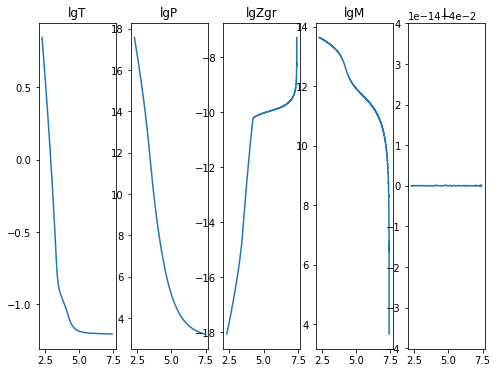

2020-11-16 03:15:46,449 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:15:47,384 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032042548
2020-11-16 03:15:47,385 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516542
2020-11-16 03:15:47,386 __main__ 0/1 INFO :: lgP iterate: 17.59681772025331
2020-11-16 03:15:47,387 __main__ 0/1 INFO :: lgM iterate: 13.641115571532957
2020-11-16 03:15:47,388 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078632
2020-11-16 03:15:47,389 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:15:47,389 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


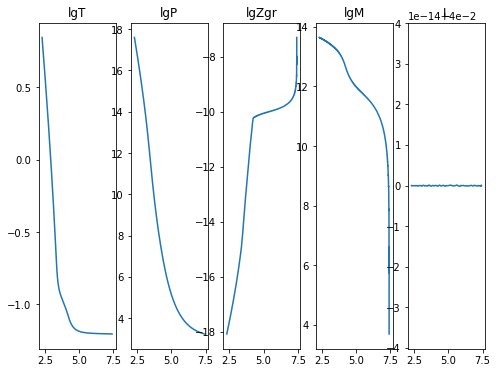

2020-11-16 03:15:51,269 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:15:52,300 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032036755
2020-11-16 03:15:52,301 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800375
2020-11-16 03:15:52,302 __main__ 0/1 INFO :: lgP iterate: 17.58155645290269
2020-11-16 03:15:52,303 __main__ 0/1 INFO :: lgM iterate: 13.641074669075092
2020-11-16 03:15:52,304 __main__ 0/1 INFO :: lgZgr iterate: -18.0699249569501
2020-11-16 03:15:52,305 __main__ 0/1 INFO :: m iterate: 5.504256300437049e-05
2020-11-16 03:15:52,306 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


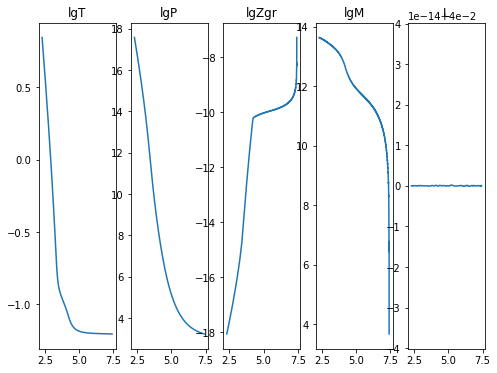

2020-11-16 03:15:56,131 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:15:56,955 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032041653
2020-11-16 03:15:56,957 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516533
2020-11-16 03:15:56,958 __main__ 0/1 INFO :: lgP iterate: 17.596817720253316
2020-11-16 03:15:56,958 __main__ 0/1 INFO :: lgM iterate: 13.64111557153298
2020-11-16 03:15:56,959 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078646
2020-11-16 03:15:56,960 __main__ 0/1 INFO :: m iterate: 5.587645173488198e-05
2020-11-16 03:15:56,961 __main__ 0/1 INFO :: L iterate: 0.04


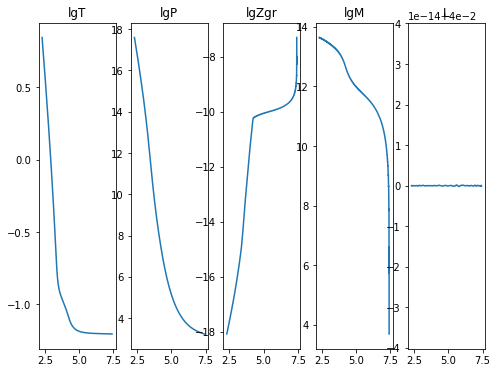

2020-11-16 03:16:01,401 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 03:16:02,774 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046796
2020-11-16 03:16:02,776 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800361
2020-11-16 03:16:02,778 __main__ 0/1 INFO :: lgP iterate: 17.581556452902674
2020-11-16 03:16:02,779 __main__ 0/1 INFO :: lgM iterate: 13.641074669075056
2020-11-16 03:16:02,780 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695006
2020-11-16 03:16:02,781 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:16:02,782 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


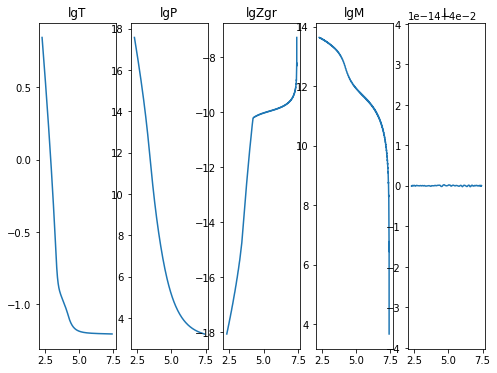

2020-11-16 03:16:06,639 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:16:07,649 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032051114
2020-11-16 03:16:07,650 __main__ 0/1 INFO :: lgT iterate: 0.845552306051653
2020-11-16 03:16:07,651 __main__ 0/1 INFO :: lgP iterate: 17.596817720253302
2020-11-16 03:16:07,652 __main__ 0/1 INFO :: lgM iterate: 13.641115571532968
2020-11-16 03:16:07,652 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078635
2020-11-16 03:16:07,653 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:16:07,654 __main__ 0/1 INFO :: L iterate: 0.04


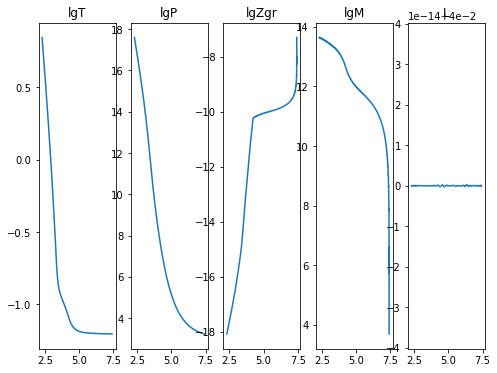

2020-11-16 03:16:11,397 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:16:12,347 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032060722
2020-11-16 03:16:12,348 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800333
2020-11-16 03:16:12,349 __main__ 0/1 INFO :: lgP iterate: 17.581556452902653
2020-11-16 03:16:12,350 __main__ 0/1 INFO :: lgM iterate: 13.641074669075095
2020-11-16 03:16:12,351 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695006
2020-11-16 03:16:12,351 __main__ 0/1 INFO :: m iterate: 5.504256300703503e-05
2020-11-16 03:16:12,352 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


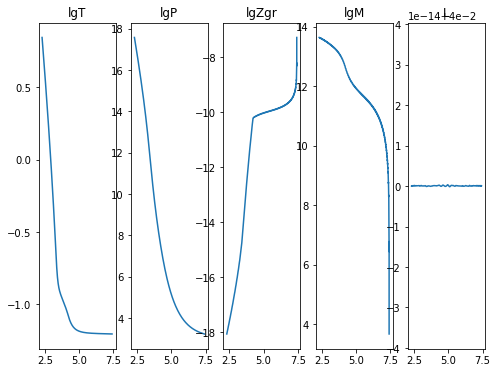

2020-11-16 03:16:15,948 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:16:16,765 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032059685
2020-11-16 03:16:16,766 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516519
2020-11-16 03:16:16,766 __main__ 0/1 INFO :: lgP iterate: 17.596817720253306
2020-11-16 03:16:16,767 __main__ 0/1 INFO :: lgM iterate: 13.641115571532971
2020-11-16 03:16:16,768 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507864
2020-11-16 03:16:16,769 __main__ 0/1 INFO :: m iterate: 5.5876451733105625e-05
2020-11-16 03:16:16,769 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


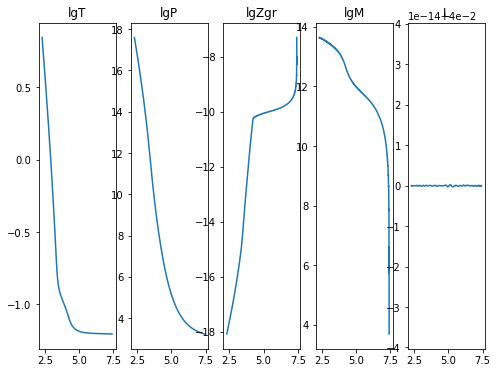

2020-11-16 03:16:20,371 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:16:21,336 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032056785
2020-11-16 03:16:21,337 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800367
2020-11-16 03:16:21,338 __main__ 0/1 INFO :: lgP iterate: 17.58155645290266
2020-11-16 03:16:21,339 __main__ 0/1 INFO :: lgM iterate: 13.641074669075088
2020-11-16 03:16:21,340 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950068
2020-11-16 03:16:21,340 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:16:21,341 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


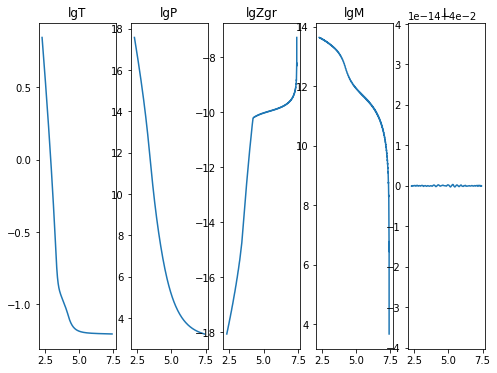

2020-11-16 03:16:24,907 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:16:25,679 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032050914
2020-11-16 03:16:25,680 __main__ 0/1 INFO :: lgT iterate: 0.845552306051652
2020-11-16 03:16:25,681 __main__ 0/1 INFO :: lgP iterate: 17.596817720253306
2020-11-16 03:16:25,682 __main__ 0/1 INFO :: lgM iterate: 13.641115571532948
2020-11-16 03:16:25,682 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507861
2020-11-16 03:16:25,683 __main__ 0/1 INFO :: m iterate: 5.587645173132927e-05
2020-11-16 03:16:25,684 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


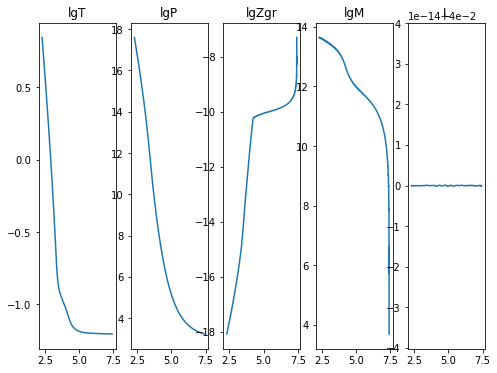

2020-11-16 03:16:29,327 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:16:30,272 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032045434
2020-11-16 03:16:30,274 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800373
2020-11-16 03:16:30,274 __main__ 0/1 INFO :: lgP iterate: 17.58155645290268
2020-11-16 03:16:30,275 __main__ 0/1 INFO :: lgM iterate: 13.64107466907513
2020-11-16 03:16:30,276 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950125
2020-11-16 03:16:30,277 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:16:30,278 __main__ 0/1 INFO :: L iterate: 0.04


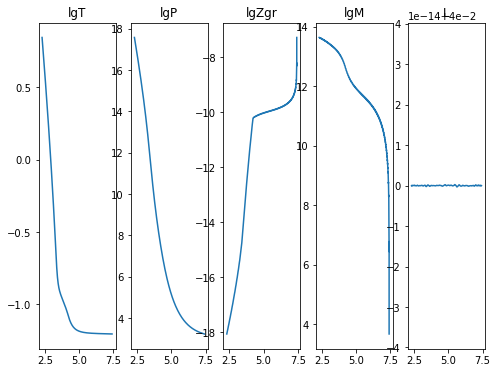

2020-11-16 03:16:34,334 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:16:35,110 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044078
2020-11-16 03:16:35,111 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516508
2020-11-16 03:16:35,112 __main__ 0/1 INFO :: lgP iterate: 17.596817720253295
2020-11-16 03:16:35,113 __main__ 0/1 INFO :: lgM iterate: 13.641115571532945
2020-11-16 03:16:35,114 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507861
2020-11-16 03:16:35,115 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:16:35,116 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


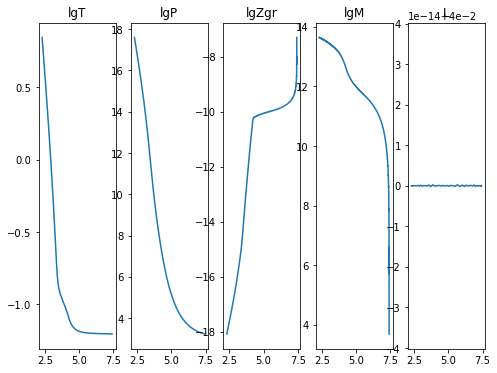

2020-11-16 03:16:38,707 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:16:39,702 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032043734
2020-11-16 03:16:39,705 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800368
2020-11-16 03:16:39,707 __main__ 0/1 INFO :: lgP iterate: 17.581556452902685
2020-11-16 03:16:39,710 __main__ 0/1 INFO :: lgM iterate: 13.641074669075127
2020-11-16 03:16:39,712 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950118
2020-11-16 03:16:39,715 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:16:39,718 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


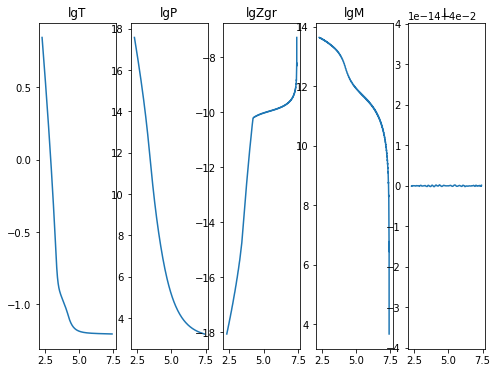

2020-11-16 03:16:43,302 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:16:44,091 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032040967
2020-11-16 03:16:44,092 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516525
2020-11-16 03:16:44,093 __main__ 0/1 INFO :: lgP iterate: 17.59681772025329
2020-11-16 03:16:44,094 __main__ 0/1 INFO :: lgM iterate: 13.64111557153296
2020-11-16 03:16:44,095 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507861
2020-11-16 03:16:44,096 __main__ 0/1 INFO :: m iterate: 5.5876451727776555e-05
2020-11-16 03:16:44,096 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


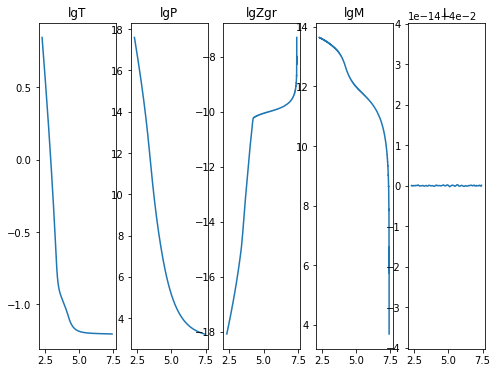

2020-11-16 03:16:47,762 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:16:48,701 __main__ 0/1 INFO :: Perturbation norm: 1.740464603203858
2020-11-16 03:16:48,702 __main__ 0/1 INFO :: lgT iterate: 0.844929764780035
2020-11-16 03:16:48,703 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:16:48,703 __main__ 0/1 INFO :: lgM iterate: 13.641074669075135
2020-11-16 03:16:48,704 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695011
2020-11-16 03:16:48,705 __main__ 0/1 INFO :: m iterate: 5.504256301147592e-05
2020-11-16 03:16:48,706 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


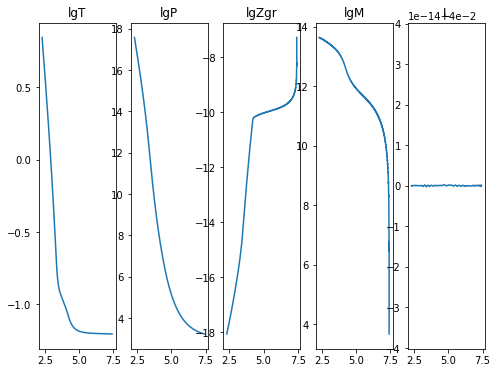

2020-11-16 03:16:52,336 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:16:53,108 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032038031
2020-11-16 03:16:53,109 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516541
2020-11-16 03:16:53,110 __main__ 0/1 INFO :: lgP iterate: 17.596817720253306
2020-11-16 03:16:53,111 __main__ 0/1 INFO :: lgM iterate: 13.641115571532985
2020-11-16 03:16:53,112 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078643
2020-11-16 03:16:53,113 __main__ 0/1 INFO :: m iterate: 5.587645173577016e-05
2020-11-16 03:16:53,114 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


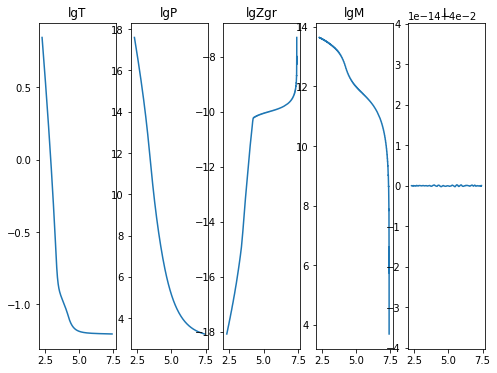

2020-11-16 03:16:56,645 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:16:57,581 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032035418
2020-11-16 03:16:57,582 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800347
2020-11-16 03:16:57,583 __main__ 0/1 INFO :: lgP iterate: 17.581556452902657
2020-11-16 03:16:57,584 __main__ 0/1 INFO :: lgM iterate: 13.64107466907505
2020-11-16 03:16:57,584 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695005
2020-11-16 03:16:57,585 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:16:57,586 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


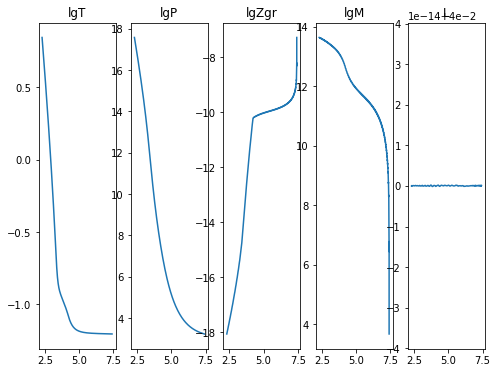

2020-11-16 03:17:01,137 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:17:01,866 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032039235
2020-11-16 03:17:01,867 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516532
2020-11-16 03:17:01,868 __main__ 0/1 INFO :: lgP iterate: 17.596817720253323
2020-11-16 03:17:01,869 __main__ 0/1 INFO :: lgM iterate: 13.641115571532954
2020-11-16 03:17:01,869 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507864
2020-11-16 03:17:01,870 __main__ 0/1 INFO :: m iterate: 5.5876451726888376e-05
2020-11-16 03:17:01,871 __main__ 0/1 INFO :: L iterate: 0.04


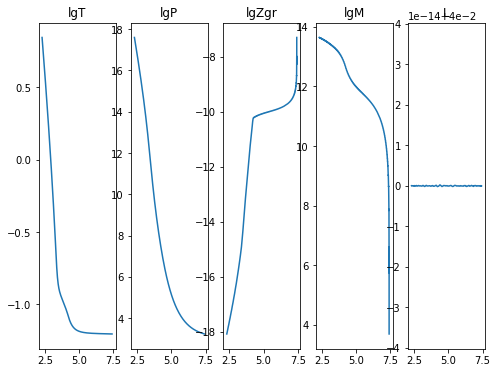

2020-11-16 03:17:05,487 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:17:06,421 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032043707
2020-11-16 03:17:06,422 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800351
2020-11-16 03:17:06,423 __main__ 0/1 INFO :: lgP iterate: 17.581556452902653
2020-11-16 03:17:06,424 __main__ 0/1 INFO :: lgM iterate: 13.641074669075076
2020-11-16 03:17:06,425 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950047
2020-11-16 03:17:06,426 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:17:06,427 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


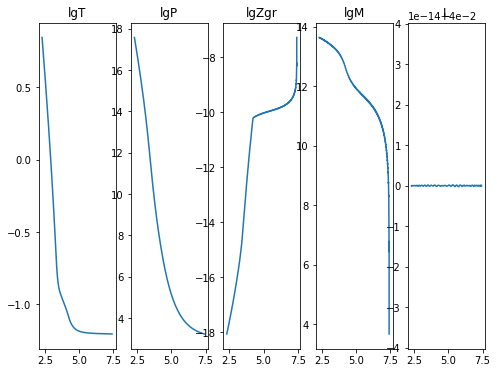

2020-11-16 03:17:09,952 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:17:10,727 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044773
2020-11-16 03:17:10,728 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516532
2020-11-16 03:17:10,729 __main__ 0/1 INFO :: lgP iterate: 17.596817720253323
2020-11-16 03:17:10,730 __main__ 0/1 INFO :: lgM iterate: 13.641115571532936
2020-11-16 03:17:10,731 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507863
2020-11-16 03:17:10,732 __main__ 0/1 INFO :: m iterate: 5.587645173132927e-05
2020-11-16 03:17:10,733 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


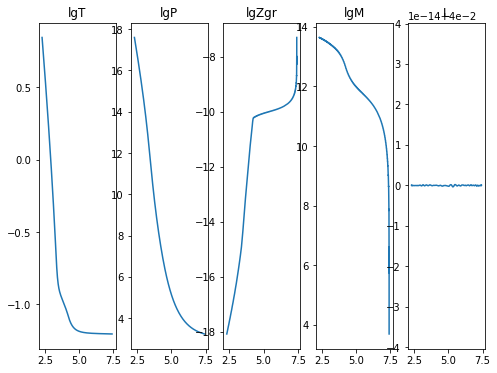

2020-11-16 03:17:14,261 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:17:15,195 __main__ 0/1 INFO :: Perturbation norm: 1.74046460320456
2020-11-16 03:17:15,196 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800362
2020-11-16 03:17:15,197 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:17:15,198 __main__ 0/1 INFO :: lgM iterate: 13.641074669075108
2020-11-16 03:17:15,199 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950086
2020-11-16 03:17:15,200 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:17:15,200 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


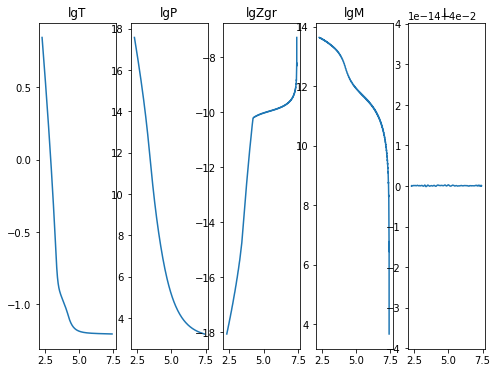

2020-11-16 03:17:18,719 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
2020-11-16 03:17:19,520 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032040259
2020-11-16 03:17:19,521 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516527
2020-11-16 03:17:19,522 __main__ 0/1 INFO :: lgP iterate: 17.596817720253306
2020-11-16 03:17:19,523 __main__ 0/1 INFO :: lgM iterate: 13.641115571532946
2020-11-16 03:17:19,524 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507861
2020-11-16 03:17:19,525 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:17:19,525 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


2020-11-16 03:17:23,136 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:17:24,068 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032034632
2020-11-16 03:17:24,069 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800356
2020-11-16 03:17:24,070 __main__ 0/1 INFO :: lgP iterate: 17.581556452902692
2020-11-16 03:17:24,071 __main__ 0/1 INFO :: lgM iterate: 13.641074669075127
2020-11-16 03:17:24,072 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950125
2020-11-16 03:17:24,073 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:17:24,074 __main__ 0/1 INFO :: L iterate: 0.04


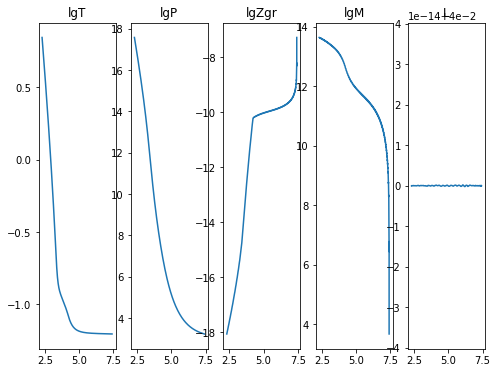

2020-11-16 03:17:27,605 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
2020-11-16 03:17:28,419 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032036695
2020-11-16 03:17:28,420 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516525
2020-11-16 03:17:28,421 __main__ 0/1 INFO :: lgP iterate: 17.596817720253302
2020-11-16 03:17:28,422 __main__ 0/1 INFO :: lgM iterate: 13.641115571533
2020-11-16 03:17:28,423 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078653
2020-11-16 03:17:28,424 __main__ 0/1 INFO :: m iterate: 5.587645173221745e-05
2020-11-16 03:17:28,425 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


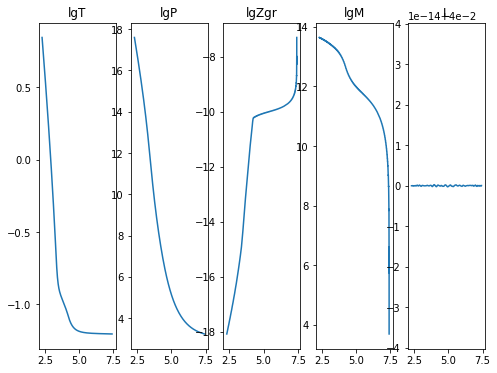

2020-11-16 03:17:31,960 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
2020-11-16 03:17:32,887 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032039632
2020-11-16 03:17:32,888 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800369
2020-11-16 03:17:32,889 __main__ 0/1 INFO :: lgP iterate: 17.581556452902696
2020-11-16 03:17:32,890 __main__ 0/1 INFO :: lgM iterate: 13.64107466907512
2020-11-16 03:17:32,891 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950132
2020-11-16 03:17:32,892 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:17:32,893 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


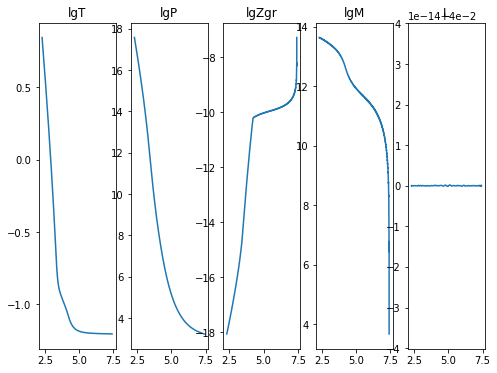

2020-11-16 03:17:36,444 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:17:37,215 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032043802
2020-11-16 03:17:37,216 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516534
2020-11-16 03:17:37,217 __main__ 0/1 INFO :: lgP iterate: 17.59681772025331
2020-11-16 03:17:37,218 __main__ 0/1 INFO :: lgM iterate: 13.641115571533
2020-11-16 03:17:37,219 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507866
2020-11-16 03:17:37,220 __main__ 0/1 INFO :: m iterate: 5.5876451726888376e-05
2020-11-16 03:17:37,221 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


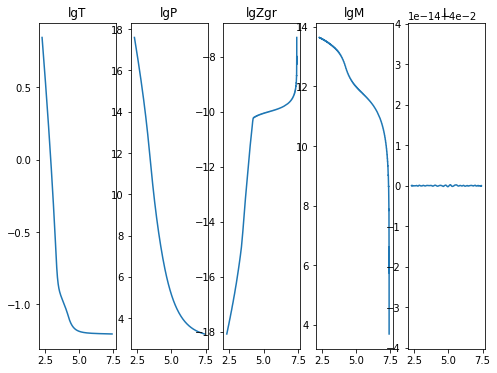

2020-11-16 03:17:40,827 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
2020-11-16 03:17:41,778 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032049298
2020-11-16 03:17:41,779 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800349
2020-11-16 03:17:41,780 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:17:41,781 __main__ 0/1 INFO :: lgM iterate: 13.64107466907512
2020-11-16 03:17:41,782 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950103
2020-11-16 03:17:41,783 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:17:41,784 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


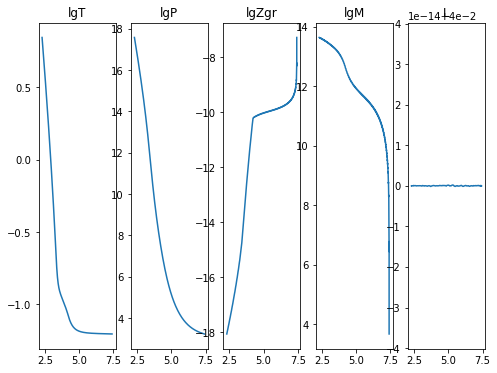

2020-11-16 03:17:45,414 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 03:17:46,259 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032050362
2020-11-16 03:17:46,260 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516519
2020-11-16 03:17:46,261 __main__ 0/1 INFO :: lgP iterate: 17.596817720253288
2020-11-16 03:17:46,262 __main__ 0/1 INFO :: lgM iterate: 13.641115571532985
2020-11-16 03:17:46,263 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507862
2020-11-16 03:17:46,264 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:17:46,264 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


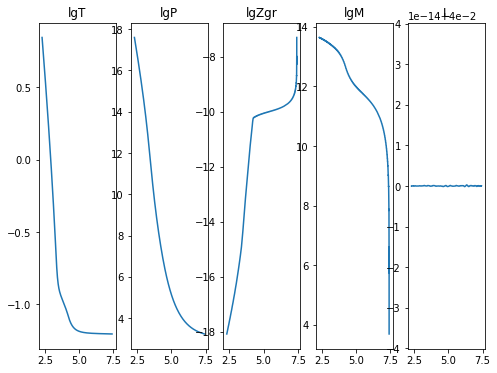

2020-11-16 03:17:49,871 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:17:50,810 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032053028
2020-11-16 03:17:50,811 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800376
2020-11-16 03:17:50,812 __main__ 0/1 INFO :: lgP iterate: 17.581556452902653
2020-11-16 03:17:50,813 __main__ 0/1 INFO :: lgM iterate: 13.64107466907506
2020-11-16 03:17:50,814 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950047
2020-11-16 03:17:50,815 __main__ 0/1 INFO :: m iterate: 5.504256301147592e-05
2020-11-16 03:17:50,816 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


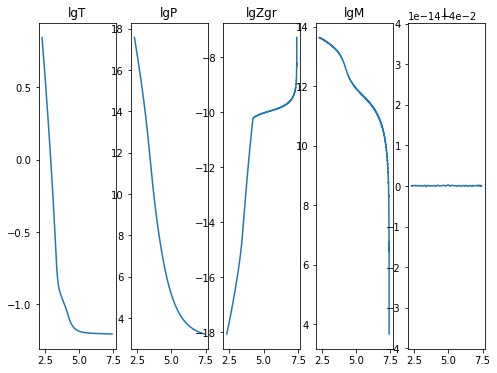

2020-11-16 03:17:55,252 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:17:56,330 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032049242
2020-11-16 03:17:56,331 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516523
2020-11-16 03:17:56,332 __main__ 0/1 INFO :: lgP iterate: 17.596817720253284
2020-11-16 03:17:56,333 __main__ 0/1 INFO :: lgM iterate: 13.641115571532968
2020-11-16 03:17:56,334 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078618
2020-11-16 03:17:56,335 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:17:56,336 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


2020-11-16 03:18:00,407 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:18:01,397 __main__ 0/1 INFO :: Perturbation norm: 1.740464603204243
2020-11-16 03:18:01,398 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800383
2020-11-16 03:18:01,399 __main__ 0/1 INFO :: lgP iterate: 17.58155645290269
2020-11-16 03:18:01,400 __main__ 0/1 INFO :: lgM iterate: 13.64107466907514
2020-11-16 03:18:01,401 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695013
2020-11-16 03:18:01,402 __main__ 0/1 INFO :: m iterate: 5.5042563002594136e-05
2020-11-16 03:18:01,403 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


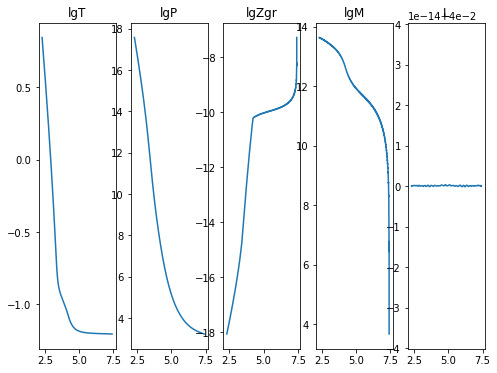

2020-11-16 03:18:05,068 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:18:05,942 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044857
2020-11-16 03:18:05,943 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516535
2020-11-16 03:18:05,944 __main__ 0/1 INFO :: lgP iterate: 17.596817720253313
2020-11-16 03:18:05,945 __main__ 0/1 INFO :: lgM iterate: 13.641115571532994
2020-11-16 03:18:05,946 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078664
2020-11-16 03:18:05,947 __main__ 0/1 INFO :: m iterate: 5.587645173221745e-05
2020-11-16 03:18:05,948 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


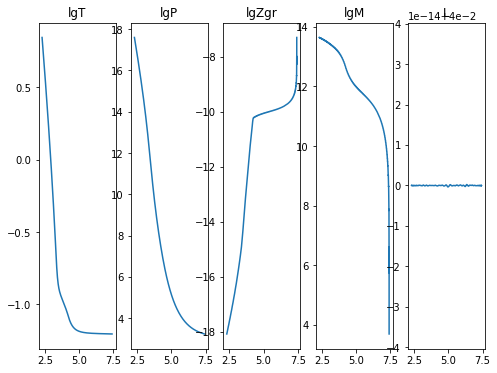

2020-11-16 03:18:09,668 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:18:10,633 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046245
2020-11-16 03:18:10,633 __main__ 0/1 INFO :: lgT iterate: 0.844929764780036
2020-11-16 03:18:10,634 __main__ 0/1 INFO :: lgP iterate: 17.58155645290268
2020-11-16 03:18:10,635 __main__ 0/1 INFO :: lgM iterate: 13.641074669075097
2020-11-16 03:18:10,636 __main__ 0/1 INFO :: lgZgr iterate: -18.0699249569501
2020-11-16 03:18:10,637 __main__ 0/1 INFO :: m iterate: 5.504256301325228e-05
2020-11-16 03:18:10,638 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


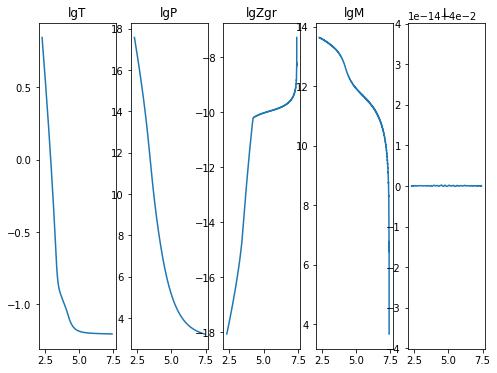

2020-11-16 03:18:14,271 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:18:15,049 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032045927
2020-11-16 03:18:15,050 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516521
2020-11-16 03:18:15,051 __main__ 0/1 INFO :: lgP iterate: 17.596817720253313
2020-11-16 03:18:15,052 __main__ 0/1 INFO :: lgM iterate: 13.641115571532964
2020-11-16 03:18:15,053 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507864
2020-11-16 03:18:15,054 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:18:15,055 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


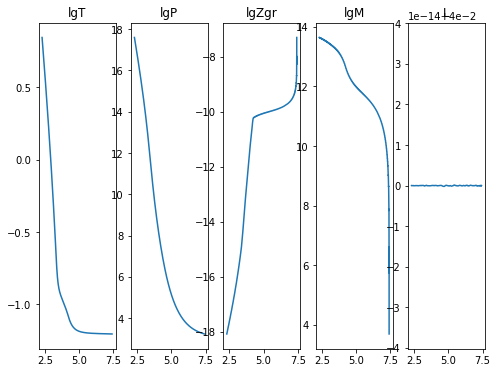

2020-11-16 03:18:18,784 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:18:19,772 __main__ 0/1 INFO :: Perturbation norm: 1.740464603204806
2020-11-16 03:18:19,773 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800368
2020-11-16 03:18:19,774 __main__ 0/1 INFO :: lgP iterate: 17.58155645290267
2020-11-16 03:18:19,775 __main__ 0/1 INFO :: lgM iterate: 13.64107466907515
2020-11-16 03:18:19,775 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950125
2020-11-16 03:18:19,777 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:18:19,777 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


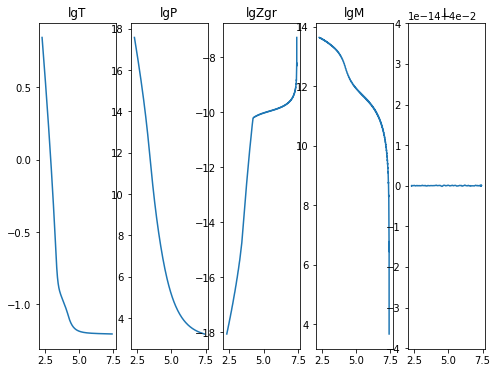

2020-11-16 03:18:23,440 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:18:24,207 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044444
2020-11-16 03:18:24,209 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516521
2020-11-16 03:18:24,210 __main__ 0/1 INFO :: lgP iterate: 17.59681772025329
2020-11-16 03:18:24,210 __main__ 0/1 INFO :: lgM iterate: 13.641115571532964
2020-11-16 03:18:24,211 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078603
2020-11-16 03:18:24,212 __main__ 0/1 INFO :: m iterate: 5.587645172866473e-05
2020-11-16 03:18:24,213 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


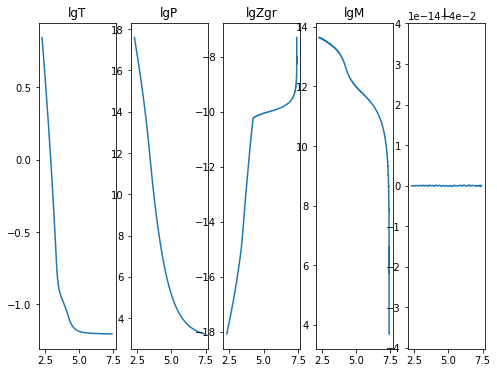

2020-11-16 03:18:27,898 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:18:29,352 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032039937
2020-11-16 03:18:29,357 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800336
2020-11-16 03:18:29,360 __main__ 0/1 INFO :: lgP iterate: 17.58155645290268
2020-11-16 03:18:29,363 __main__ 0/1 INFO :: lgM iterate: 13.641074669075065
2020-11-16 03:18:29,367 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950082
2020-11-16 03:18:29,370 __main__ 0/1 INFO :: m iterate: 5.50425630123641e-05
2020-11-16 03:18:29,374 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


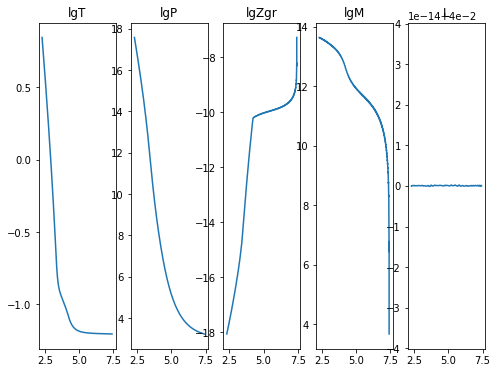

2020-11-16 03:18:33,006 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 03:18:34,036 __main__ 0/1 INFO :: Perturbation norm: 1.740464603204488
2020-11-16 03:18:34,038 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516514
2020-11-16 03:18:34,039 __main__ 0/1 INFO :: lgP iterate: 17.596817720253284
2020-11-16 03:18:34,039 __main__ 0/1 INFO :: lgM iterate: 13.641115571532922
2020-11-16 03:18:34,040 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078575
2020-11-16 03:18:34,041 __main__ 0/1 INFO :: m iterate: 5.587645173221745e-05
2020-11-16 03:18:34,042 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


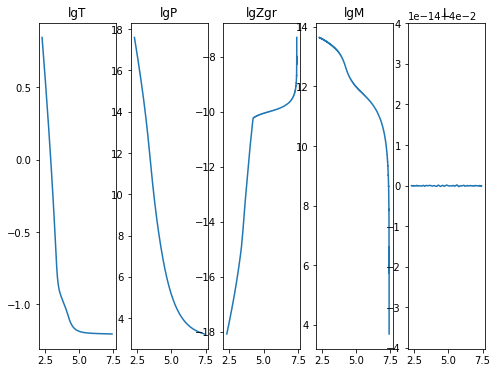

2020-11-16 03:18:37,827 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:18:38,833 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032055175
2020-11-16 03:18:38,834 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800338
2020-11-16 03:18:38,835 __main__ 0/1 INFO :: lgP iterate: 17.581556452902625
2020-11-16 03:18:38,836 __main__ 0/1 INFO :: lgM iterate: 13.641074669075103
2020-11-16 03:18:38,837 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695006
2020-11-16 03:18:38,838 __main__ 0/1 INFO :: m iterate: 5.504256300969956e-05
2020-11-16 03:18:38,839 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


2020-11-16 03:18:42,710 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:18:43,550 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032052253
2020-11-16 03:18:43,551 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516514
2020-11-16 03:18:43,552 __main__ 0/1 INFO :: lgP iterate: 17.596817720253284
2020-11-16 03:18:43,552 __main__ 0/1 INFO :: lgM iterate: 13.641115571532945
2020-11-16 03:18:43,553 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507859
2020-11-16 03:18:43,554 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:18:43,555 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


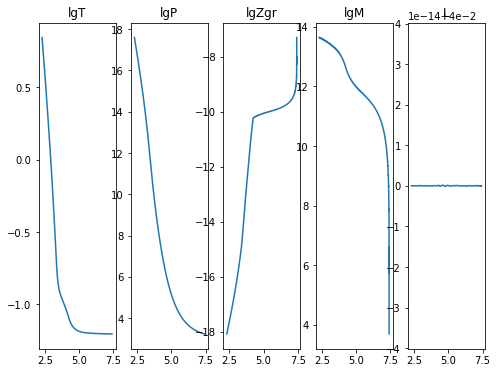

2020-11-16 03:18:47,684 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 03:18:49,368 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046545
2020-11-16 03:18:49,369 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800377
2020-11-16 03:18:49,370 __main__ 0/1 INFO :: lgP iterate: 17.58155645290268
2020-11-16 03:18:49,371 __main__ 0/1 INFO :: lgM iterate: 13.641074669075131
2020-11-16 03:18:49,372 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695012
2020-11-16 03:18:49,373 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:18:49,373 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


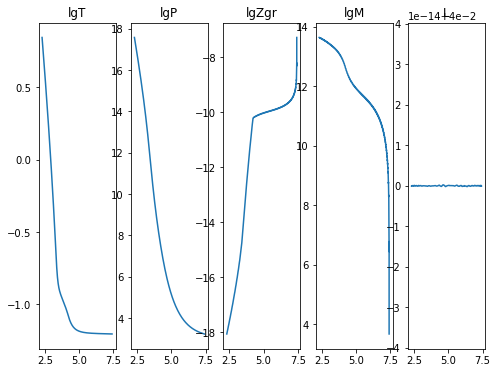

2020-11-16 03:18:54,307 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 03:18:55,169 __main__ 0/1 INFO :: Perturbation norm: 1.740464603205423
2020-11-16 03:18:55,170 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516537
2020-11-16 03:18:55,171 __main__ 0/1 INFO :: lgP iterate: 17.596817720253323
2020-11-16 03:18:55,172 __main__ 0/1 INFO :: lgM iterate: 13.641115571532929
2020-11-16 03:18:55,172 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078625
2020-11-16 03:18:55,174 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:18:55,174 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


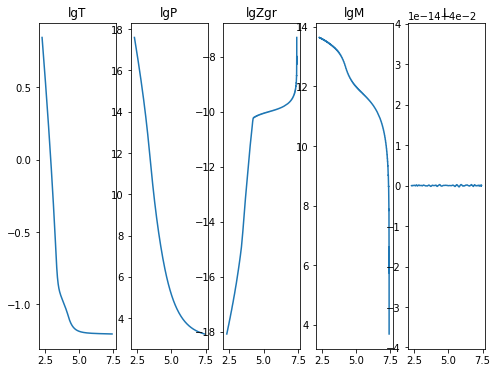

2020-11-16 03:18:59,168 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:19:00,251 __main__ 0/1 INFO :: Perturbation norm: 1.740464603206145
2020-11-16 03:19:00,252 __main__ 0/1 INFO :: lgT iterate: 0.844929764780035
2020-11-16 03:19:00,253 __main__ 0/1 INFO :: lgP iterate: 17.581556452902642
2020-11-16 03:19:00,254 __main__ 0/1 INFO :: lgM iterate: 13.641074669075081
2020-11-16 03:19:00,254 __main__ 0/1 INFO :: lgZgr iterate: -18.06992495695005
2020-11-16 03:19:00,256 __main__ 0/1 INFO :: m iterate: 5.5042563008811385e-05
2020-11-16 03:19:00,256 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


2020-11-16 03:19:04,248 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:19:05,018 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032056026
2020-11-16 03:19:05,019 __main__ 0/1 INFO :: lgT iterate: 0.845552306051652
2020-11-16 03:19:05,020 __main__ 0/1 INFO :: lgP iterate: 17.5968177202533
2020-11-16 03:19:05,021 __main__ 0/1 INFO :: lgM iterate: 13.641115571532918
2020-11-16 03:19:05,022 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078596
2020-11-16 03:19:05,023 __main__ 0/1 INFO :: m iterate: 5.587645172955291e-05
2020-11-16 03:19:05,024 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


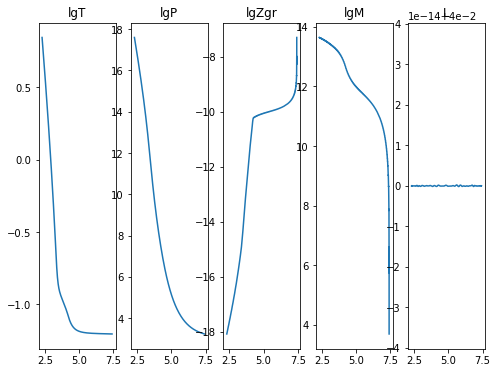

2020-11-16 03:19:08,922 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:19:09,937 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032051276
2020-11-16 03:19:09,938 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800362
2020-11-16 03:19:09,939 __main__ 0/1 INFO :: lgP iterate: 17.581556452902674
2020-11-16 03:19:09,939 __main__ 0/1 INFO :: lgM iterate: 13.641074669075131
2020-11-16 03:19:09,940 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950103
2020-11-16 03:19:09,941 __main__ 0/1 INFO :: m iterate: 5.504256301147592e-05
2020-11-16 03:19:09,942 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


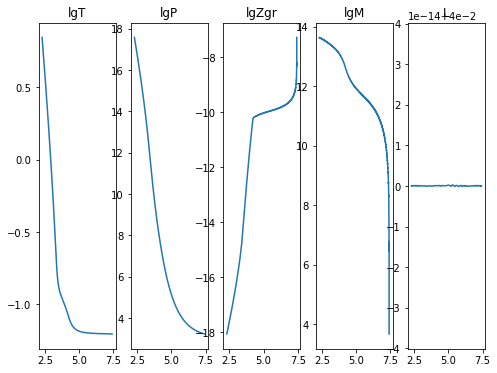

2020-11-16 03:19:13,988 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:19:14,966 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032050322
2020-11-16 03:19:14,967 __main__ 0/1 INFO :: lgT iterate: 0.845552306051653
2020-11-16 03:19:14,968 __main__ 0/1 INFO :: lgP iterate: 17.596817720253295
2020-11-16 03:19:14,969 __main__ 0/1 INFO :: lgM iterate: 13.64111557153291
2020-11-16 03:19:14,969 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507858
2020-11-16 03:19:14,970 __main__ 0/1 INFO :: m iterate: 5.587645173044109e-05
2020-11-16 03:19:14,971 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


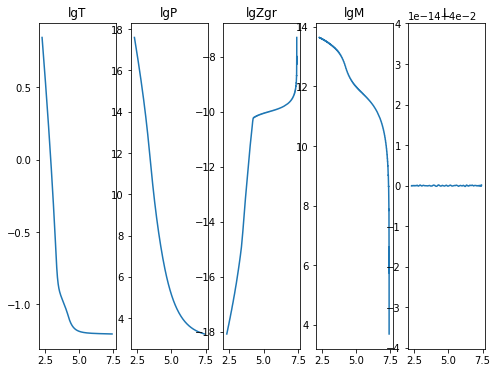

2020-11-16 03:19:19,075 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:19:20,302 __main__ 0/1 INFO :: Perturbation norm: 1.740464603204887
2020-11-16 03:19:20,304 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800346
2020-11-16 03:19:20,305 __main__ 0/1 INFO :: lgP iterate: 17.581556452902653
2020-11-16 03:19:20,307 __main__ 0/1 INFO :: lgM iterate: 13.64107466907504
2020-11-16 03:19:20,309 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950036
2020-11-16 03:19:20,311 __main__ 0/1 INFO :: m iterate: 5.504256301147592e-05
2020-11-16 03:19:20,312 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


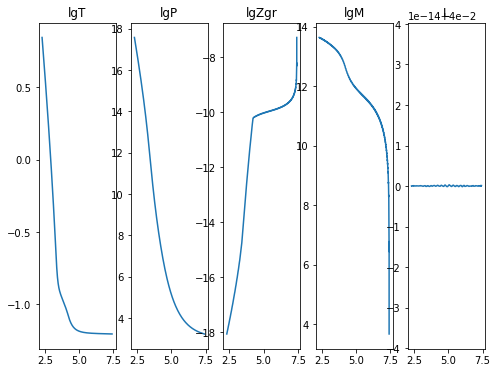

2020-11-16 03:19:25,630 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 03:19:26,873 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046225
2020-11-16 03:19:26,874 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516533
2020-11-16 03:19:26,875 __main__ 0/1 INFO :: lgP iterate: 17.596817720253313
2020-11-16 03:19:26,878 __main__ 0/1 INFO :: lgM iterate: 13.64111557153298
2020-11-16 03:19:26,880 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078646
2020-11-16 03:19:26,881 __main__ 0/1 INFO :: m iterate: 5.587645173221745e-05
2020-11-16 03:19:26,882 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


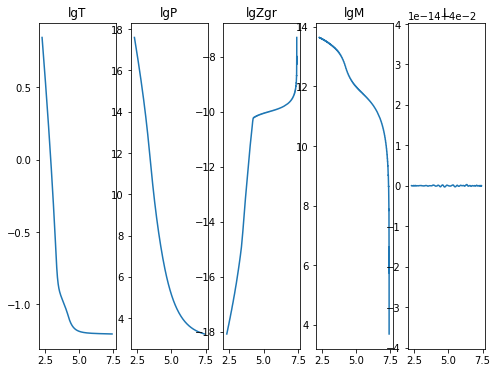

2020-11-16 03:19:31,245 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:19:32,421 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032041238
2020-11-16 03:19:32,422 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800347
2020-11-16 03:19:32,423 __main__ 0/1 INFO :: lgP iterate: 17.58155645290267
2020-11-16 03:19:32,424 __main__ 0/1 INFO :: lgM iterate: 13.641074669075078
2020-11-16 03:19:32,425 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950075
2020-11-16 03:19:32,426 __main__ 0/1 INFO :: m iterate: 5.504256301147592e-05
2020-11-16 03:19:32,427 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


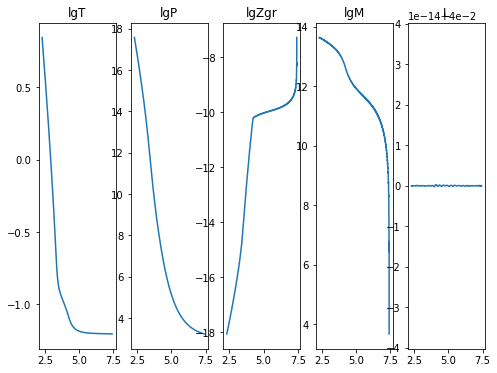

2020-11-16 03:19:36,274 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:19:37,049 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032043827
2020-11-16 03:19:37,051 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516531
2020-11-16 03:19:37,052 __main__ 0/1 INFO :: lgP iterate: 17.596817720253327
2020-11-16 03:19:37,052 __main__ 0/1 INFO :: lgM iterate: 13.641115571532945
2020-11-16 03:19:37,053 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078635
2020-11-16 03:19:37,054 __main__ 0/1 INFO :: m iterate: 5.58764517260002e-05
2020-11-16 03:19:37,055 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


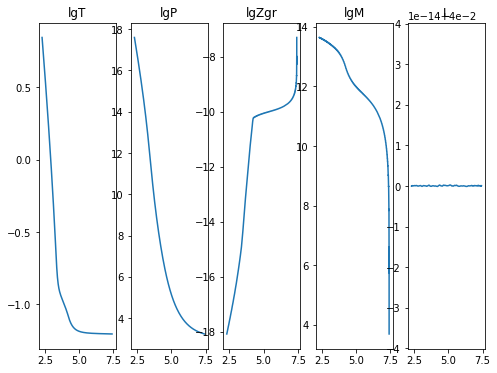

2020-11-16 03:19:40,938 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:19:41,925 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032044697
2020-11-16 03:19:41,926 __main__ 0/1 INFO :: lgT iterate: 0.844929764780037
2020-11-16 03:19:41,927 __main__ 0/1 INFO :: lgP iterate: 17.581556452902674
2020-11-16 03:19:41,928 __main__ 0/1 INFO :: lgM iterate: 13.641074669075106
2020-11-16 03:19:41,929 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950093
2020-11-16 03:19:41,930 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:19:41,931 __main__ 0/1 INFO :: L iterate: 0.04


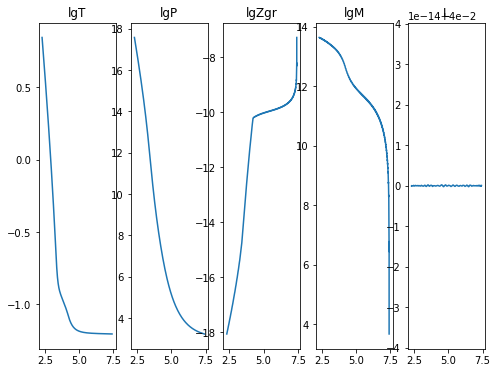

2020-11-16 03:19:45,773 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:19:46,614 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032041784
2020-11-16 03:19:46,615 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516528
2020-11-16 03:19:46,616 __main__ 0/1 INFO :: lgP iterate: 17.596817720253316
2020-11-16 03:19:46,617 __main__ 0/1 INFO :: lgM iterate: 13.641115571532968
2020-11-16 03:19:46,618 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078646
2020-11-16 03:19:46,619 __main__ 0/1 INFO :: m iterate: 5.587645173221745e-05
2020-11-16 03:19:46,620 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


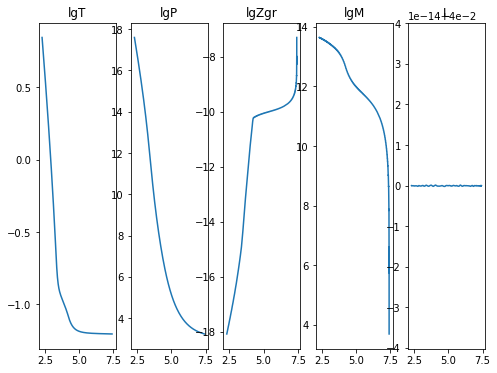

2020-11-16 03:19:50,483 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 03:19:51,536 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032039601
2020-11-16 03:19:51,537 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800353
2020-11-16 03:19:51,538 __main__ 0/1 INFO :: lgP iterate: 17.581556452902696
2020-11-16 03:19:51,539 __main__ 0/1 INFO :: lgM iterate: 13.641074669075085
2020-11-16 03:19:51,540 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950096
2020-11-16 03:19:51,541 __main__ 0/1 INFO :: m iterate: 5.5042563008811385e-05
2020-11-16 03:19:51,542 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


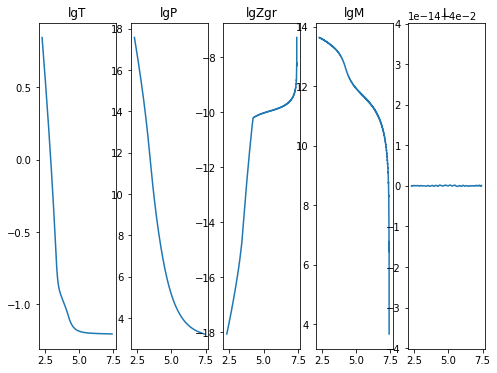

2020-11-16 03:19:55,354 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:19:56,193 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032039826
2020-11-16 03:19:56,194 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516542
2020-11-16 03:19:56,195 __main__ 0/1 INFO :: lgP iterate: 17.5968177202533
2020-11-16 03:19:56,196 __main__ 0/1 INFO :: lgM iterate: 13.641115571532966
2020-11-16 03:19:56,197 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507863
2020-11-16 03:19:56,198 __main__ 0/1 INFO :: m iterate: 5.5876451727776555e-05
2020-11-16 03:19:56,199 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


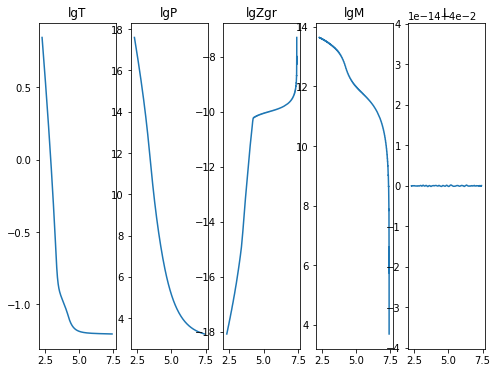

2020-11-16 03:20:00,167 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:20:01,125 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046593
2020-11-16 03:20:01,126 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800338
2020-11-16 03:20:01,127 __main__ 0/1 INFO :: lgP iterate: 17.58155645290266
2020-11-16 03:20:01,128 __main__ 0/1 INFO :: lgM iterate: 13.641074669075156
2020-11-16 03:20:01,129 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950114
2020-11-16 03:20:01,130 __main__ 0/1 INFO :: m iterate: 5.504256300614685e-05
2020-11-16 03:20:01,131 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


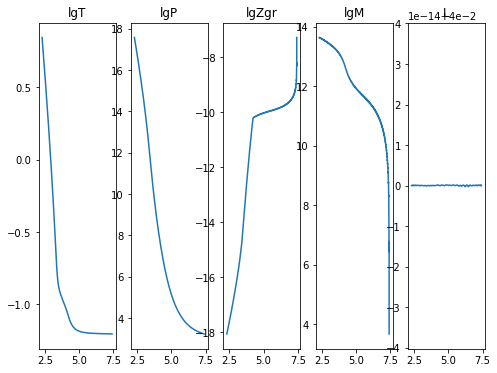

2020-11-16 03:20:05,002 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 03:20:05,908 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032048614
2020-11-16 03:20:05,909 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516543
2020-11-16 03:20:05,910 __main__ 0/1 INFO :: lgP iterate: 17.596817720253323
2020-11-16 03:20:05,911 __main__ 0/1 INFO :: lgM iterate: 13.641115571532971
2020-11-16 03:20:05,912 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078653
2020-11-16 03:20:05,913 __main__ 0/1 INFO :: m iterate: 5.587645173221745e-05
2020-11-16 03:20:05,914 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


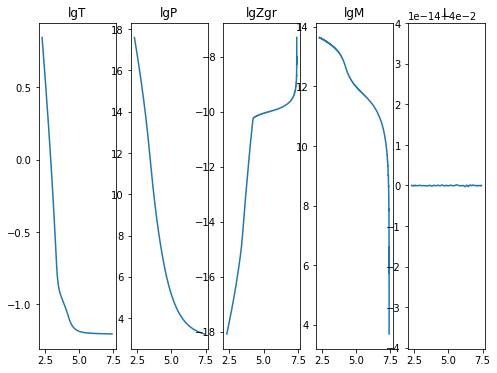

2020-11-16 03:20:09,650 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:20:10,634 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032046478
2020-11-16 03:20:10,635 __main__ 0/1 INFO :: lgT iterate: 0.844929764780036
2020-11-16 03:20:10,636 __main__ 0/1 INFO :: lgP iterate: 17.581556452902667
2020-11-16 03:20:10,636 __main__ 0/1 INFO :: lgM iterate: 13.641074669075072
2020-11-16 03:20:10,637 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950064
2020-11-16 03:20:10,638 __main__ 0/1 INFO :: m iterate: 5.5042563007923206e-05
2020-11-16 03:20:10,639 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


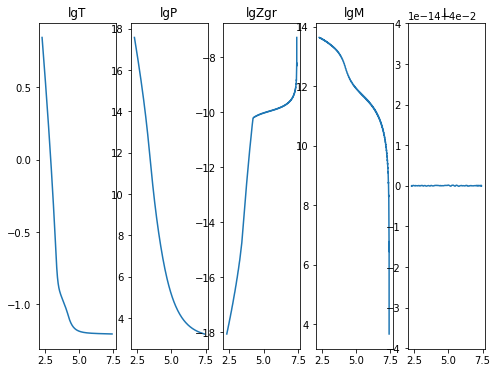

2020-11-16 03:20:14,384 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:20:15,199 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032038573
2020-11-16 03:20:15,200 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516533
2020-11-16 03:20:15,200 __main__ 0/1 INFO :: lgP iterate: 17.596817720253277
2020-11-16 03:20:15,201 __main__ 0/1 INFO :: lgM iterate: 13.641115571532923
2020-11-16 03:20:15,202 __main__ 0/1 INFO :: lgZgr iterate: -18.08428489507858
2020-11-16 03:20:15,203 __main__ 0/1 INFO :: m iterate: 5.5876451722447484e-05
2020-11-16 03:20:15,204 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


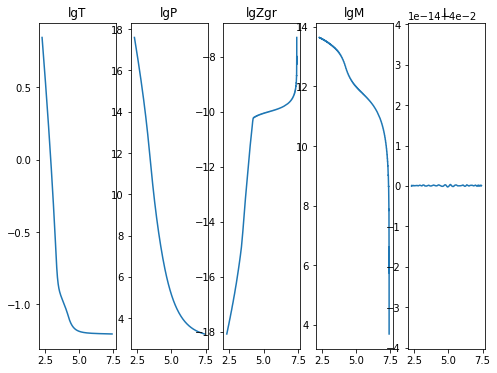

2020-11-16 03:20:19,055 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 03:20:20,164 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032033388
2020-11-16 03:20:20,166 __main__ 0/1 INFO :: lgT iterate: 0.8449297647800358
2020-11-16 03:20:20,166 __main__ 0/1 INFO :: lgP iterate: 17.581556452902674
2020-11-16 03:20:20,167 __main__ 0/1 INFO :: lgM iterate: 13.641074669075117
2020-11-16 03:20:20,168 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950103
2020-11-16 03:20:20,169 __main__ 0/1 INFO :: m iterate: 5.504256301058774e-05
2020-11-16 03:20:20,170 __main__ 0/1 INFO :: L iterate: 0.04


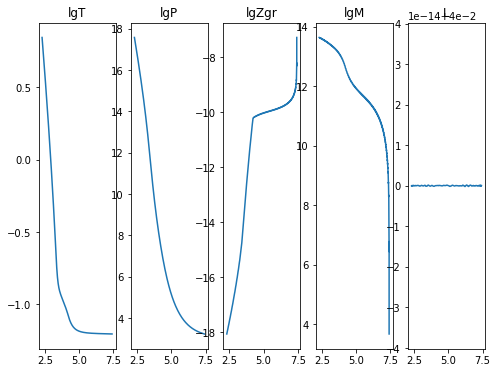

2020-11-16 03:20:24,382 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 03:20:25,512 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032039564
2020-11-16 03:20:25,514 __main__ 0/1 INFO :: lgT iterate: 0.8455523060516532
2020-11-16 03:20:25,515 __main__ 0/1 INFO :: lgP iterate: 17.596817720253323
2020-11-16 03:20:25,515 __main__ 0/1 INFO :: lgM iterate: 13.641115571532923
2020-11-16 03:20:25,516 __main__ 0/1 INFO :: lgZgr iterate: -18.084284895078614
2020-11-16 03:20:25,517 __main__ 0/1 INFO :: m iterate: 5.587645173221745e-05
2020-11-16 03:20:25,518 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


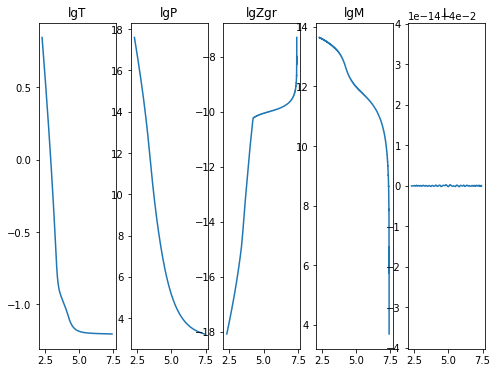

2020-11-16 03:20:29,923 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 03:20:31,280 __main__ 0/1 INFO :: Perturbation norm: 1.7404646032042346
2020-11-16 03:20:31,281 __main__ 0/1 INFO :: lgT iterate: 0.844929764780037
2020-11-16 03:20:31,282 __main__ 0/1 INFO :: lgP iterate: 17.58155645290267
2020-11-16 03:20:31,283 __main__ 0/1 INFO :: lgM iterate: 13.64107466907515
2020-11-16 03:20:31,284 __main__ 0/1 INFO :: lgZgr iterate: -18.069924956950132
2020-11-16 03:20:31,285 __main__ 0/1 INFO :: m iterate: 5.5042563014140455e-05
2020-11-16 03:20:31,286 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


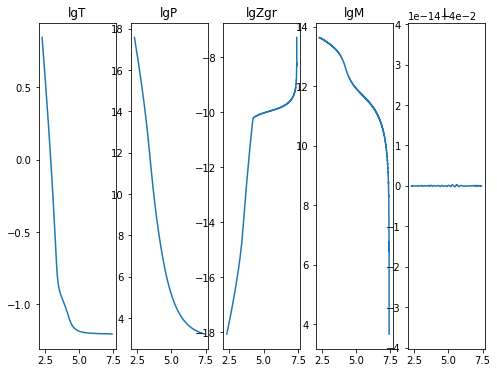

KeyboardInterrupt: 

In [19]:
# Iterations

i = 0

pert = solver.perturbations.data
pert.fill(1+tolerance)
start_time = time.time()
while np.sum(np.abs(pert)) > tolerance:
    solver.newton_iteration()
    lgT_list.append(np.copy(lgT1['g'])) # save
    lgP_list.append(np.copy(lgP1['g']))
    lgZgr_list.append(np.copy(lgZgr1['g'])) 
    lgM_list.append(np.copy(lgM1['g'])) 
    L_list.append(np.copy(L1['g']))
    m_list.append(np.copy(m['g']))
    logger.info('Perturbation norm: {}'.format(np.sum(np.abs(pert))))
    logger.info('lgT iterate: {}'.format(lgT1['g'][0]))
    logger.info('lgP iterate: {}'.format(lgP1['g'][0]))
    logger.info('lgM iterate: {}'.format(lgM1['g'][0]))
    logger.info('lgZgr iterate: {}'.format(lgZgr1['g'][0]))
    logger.info('m iterate: {}'.format(m1['g'][0]))
    logger.info('L iterate: {}'.format(L1['g'][0]))
    
    plt.figure(figsize=(8,6))
    plt.subplot(1,5,1)
    plt.plot(domain.grid(0),lgT1['g'])
    plt.title("lgT")
    plt.subplot(1,5,2)
    plt.plot(domain.grid(0), lgP1['g'])
    plt.title("lgP")
    plt.subplot(1,5,3)
    plt.plot(domain.grid(0),lgZgr1['g'])
    plt.title("lgZgr")
    plt.subplot(1,5,4)
    plt.plot(domain.grid(0), lgM1['g'])
    plt.title("lgM")
    plt.subplot(1,5,5)
    plt.plot(domain.grid(0), L1['g'])
    plt.title("L")
    plt.show()
    
end_time = time.time()

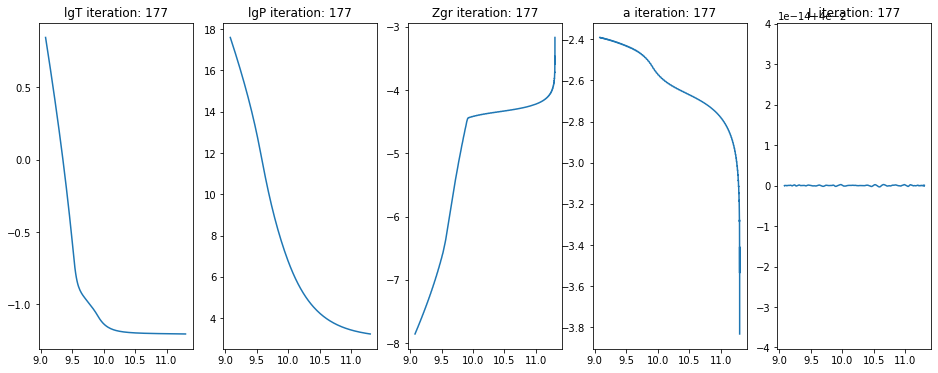

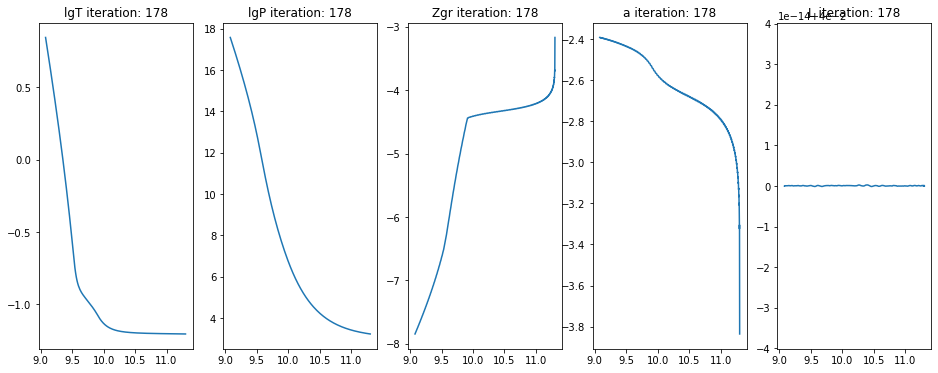

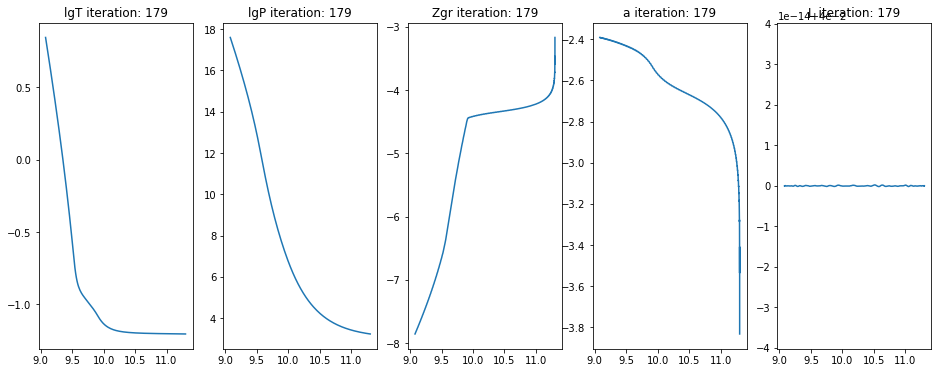

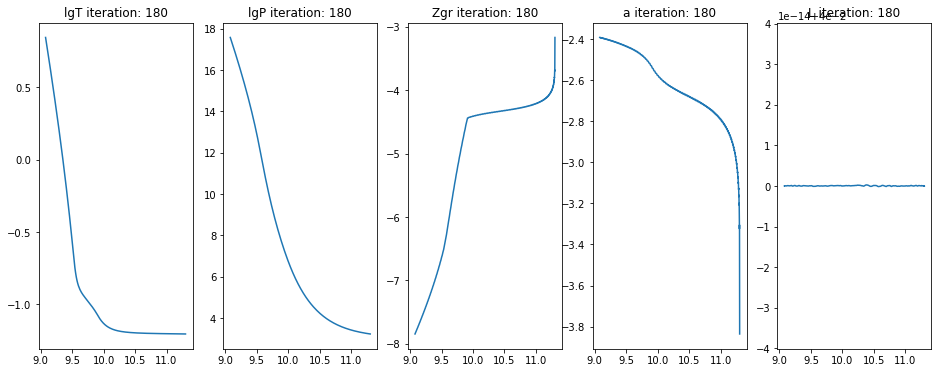

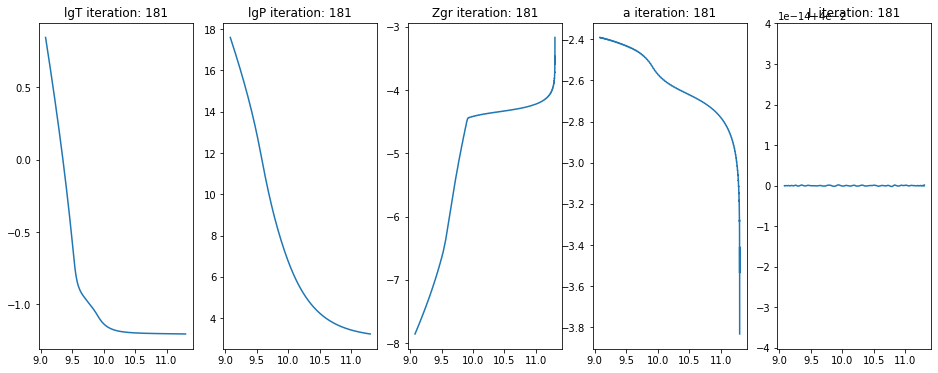

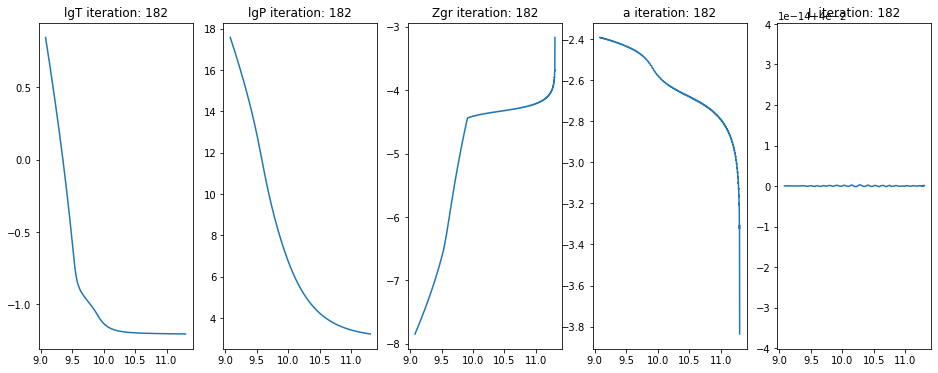

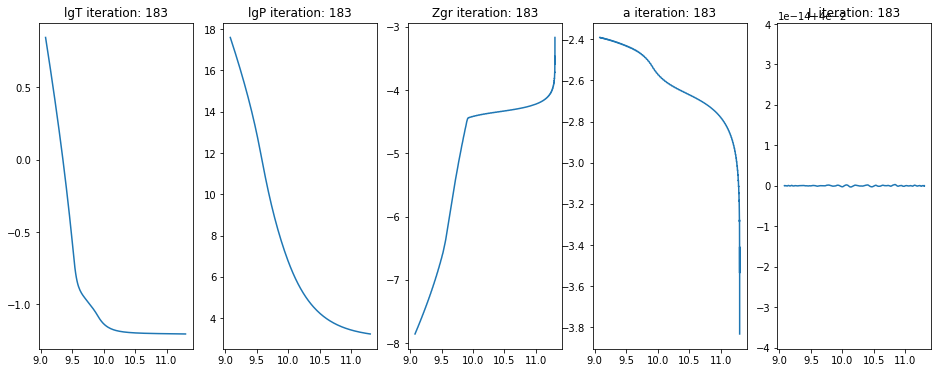

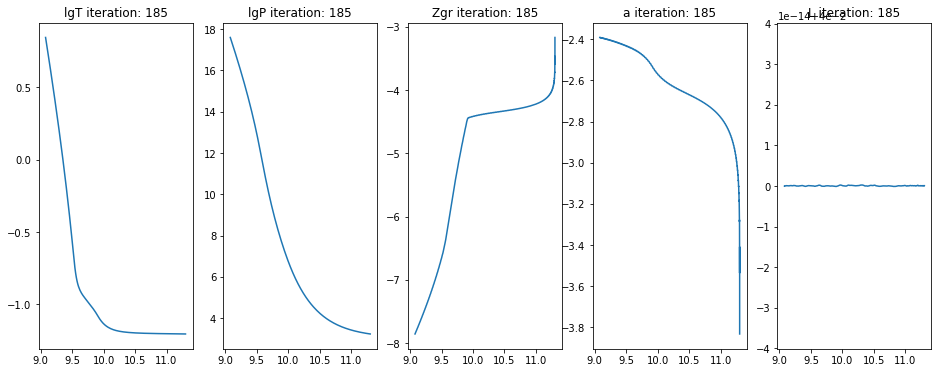

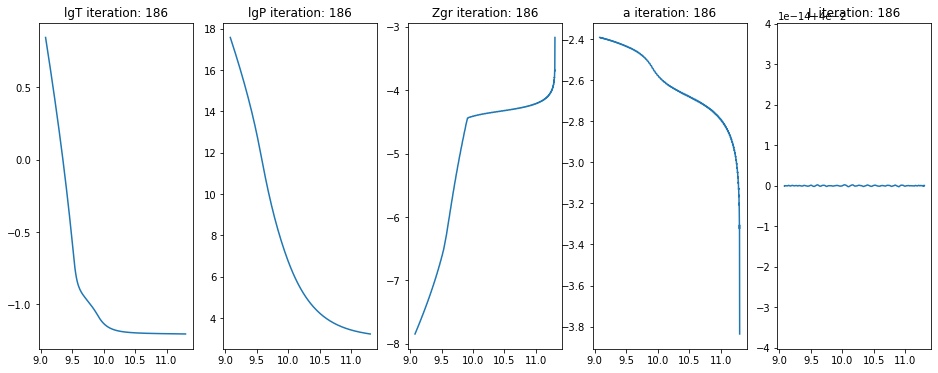

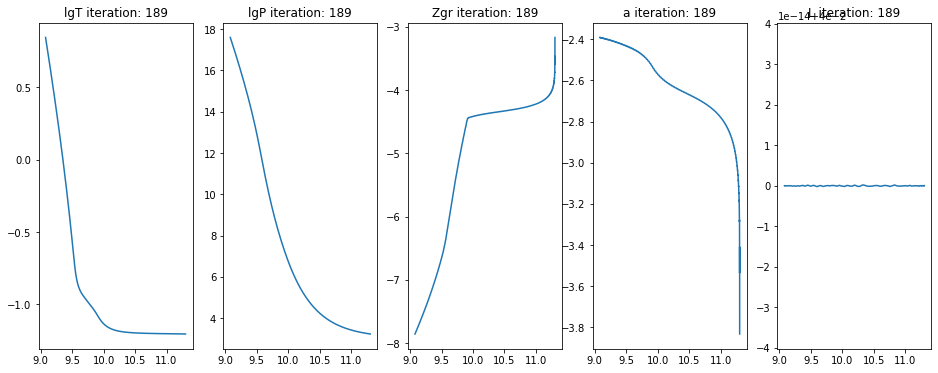

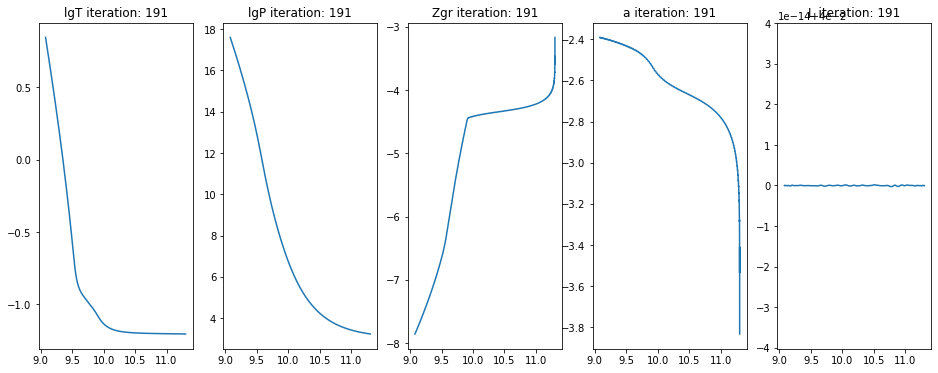

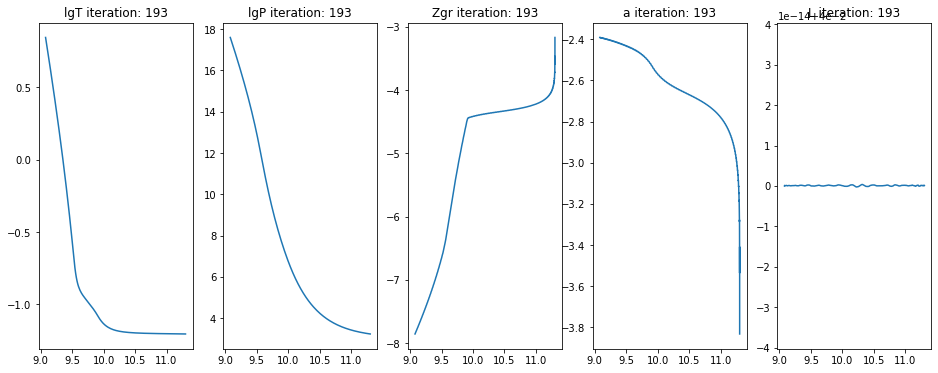

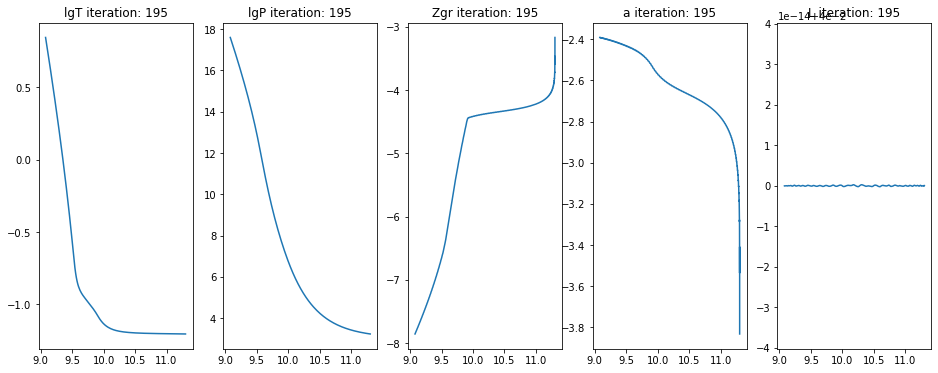

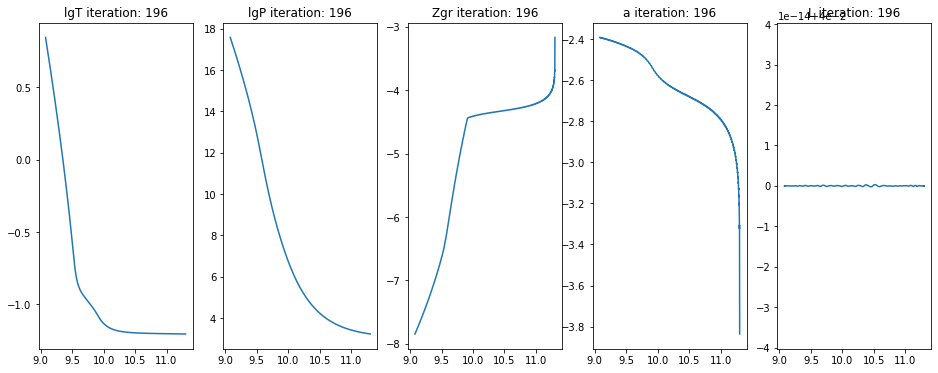

In [20]:
lower = 0 
if len(lgT_list) > 20:
    lower = len(lgT_list) - 20

R = np.log10(np.exp(domain.grid(0))*r_0)

for i in range(lower,len(lgT_list)):
        plt.figure(figsize=(16,6))
        
        plt.subplot(1,5,1)
        plt.plot(R,lgT_list[i])
        plt.title("lgT iteration: " + str(i))
        
        plt.subplot(1,5,2)
        plt.plot(R, lgP_list[i])
        plt.title("lgP iteration: " + str(i))
        
        plt.subplot(1,5,3)
        plt.plot(R, np.log10(np.exp(lgZgr_list[i])))
        plt.title("Zgr iteration: " + str(i))
        
        # Grain size 
        plt.subplot(1,5,4)
        plt.plot(R, np.log10((np.exp(lgM_list[i])*M_0/(4*np.pi))**(1/3)))
        plt.title("a iteration: " + str(i))
        
#         plt.subplot(1,5,5)
#         plt.plot(R, m_list[i])
#         plt.title("m iteration: " + str(i))

        plt.subplot(1,5,5)
        plt.plot(R, L_list[i])
        plt.title("L iteration: " + str(i))
        
        

In [21]:
lgP['g'] = lgP_list[-1]
lgT['g'] = lgT_list[-1]
lgZgr['g'] = lgZgr_list[-1]
lgM['g'] = lgM_list[-1]
m['g'] = m_list[-1]
L['g'] = L_list[-1]

Text(0.5, 1.0, 'Grad')

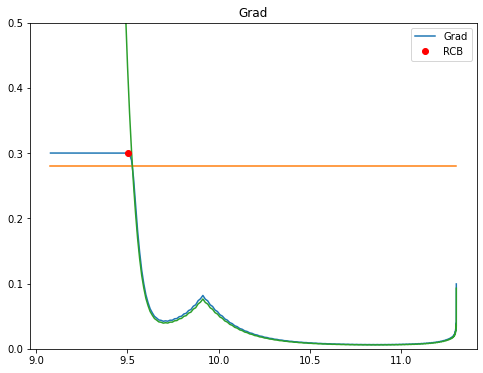

In [22]:
# Grad

Grad = grad.evaluate()
Grad.require_grid_space()
Grad_rad = grad_rad.evaluate()
Grad_rad.require_grid_space()

RCB = 0
epsilon = 0.0001
for i in range(0, len(Grad['g'] - 1)):
    if np.abs(Grad['g'][i] - Grad['g'][0]) >  epsilon:
        RCB = i
        break

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
plt.plot(R, grad_ad*np.ones(len(R)))
plt.plot(R, Grad_rad['g'])
plt.plot(R[RCB], Grad['g'][RCB], 'ro', label = 'RCB')
plt.ylim(0, 0.5)
plt.legend()

plt.title('Grad')

Text(0.5, 1.0, 'Tstop')

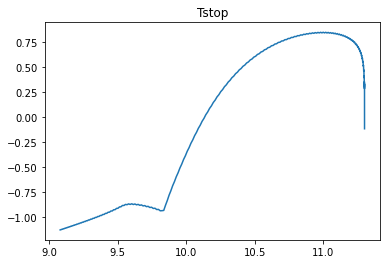

In [23]:
TStop = Tstop.evaluate()
TStop.require_grid_space()
plt.plot(R, np.log10(TStop['g']))
plt.title('Tstop')

In [24]:
Tgrow = 1/Tgrow_inv
TGrow = Tgrow.evaluate()
TGrow.require_grid_space()
plt.plot(R, np.log10(TGrow['g']))
plt.title('Tgrow')

Text(0.5, 1.0, 'Tgrow')

# New analysis section (Jan 30)


Trcb_set = 7.136085879372377 yr
Tbondi_set = 630.3874134457469 yr
Tout_set = 40333.05406475884 yr


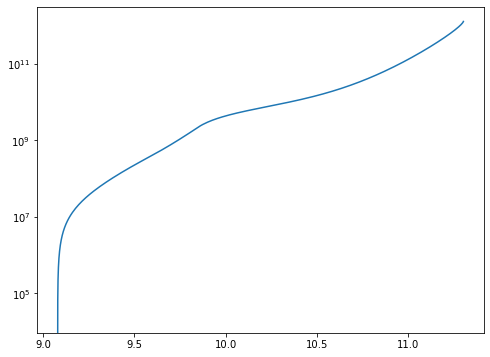

In [25]:
Bondi = r_Bondi # cm
# Bondi = 3.7e11 # cm
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']

Tsettl = np.ones(len(R))

for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')


Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))



Trcb_set = 7.136085879372377 yr
Tbondi_set = 3121.205257177023 yr
Tout_set = 40333.05406475884 yr


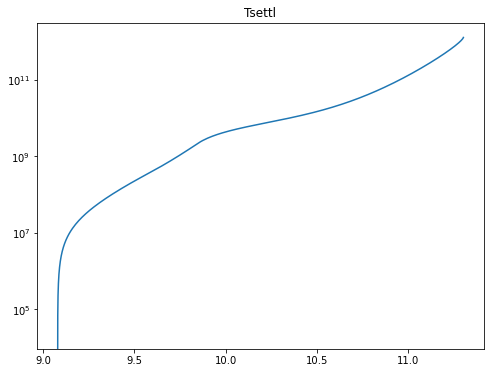

In [26]:
Bondi = 3.7e11 # cm
Bondi = 8.9442713e10
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']


Tsettl = np.ones(len(R))


for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')
plt.title('Tsettl')

Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))

In [27]:
# Ormel profile
size = s.evaluate()
size.require_grid_space()
kappa_gr = Qk_geo.evaluate()
kappa_gr.require_grid_space()


plt.figure(figsize=(12,8))
plt.plot(R, np.exp(lgZgr['g']), 'k-', label='Zgr')
plt.plot(R, kappa_gr['g'], 'm-', label='kappa_gr')
plt.plot(R, size['g'], 'b-', label='s')
plt.plot(R, R/R*1e-4, 'b:', label='1 micron')
plt.yscale('log')
plt.ylim((1e-9, 1e2))
plt.legend()

In [28]:
rho_gas = rho_g.evaluate()
rho_gas.require_grid_space()

lgt = lgT_list[-1]


plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g'])**(1/3), 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0, 'r-', label='Temperature') 
plt.plot(R, np.exp(lgt)*T_0 *rho_gas['g'] , 'r--', label='Press=Rho*T')
plt.yscale('log')
plt.legend()

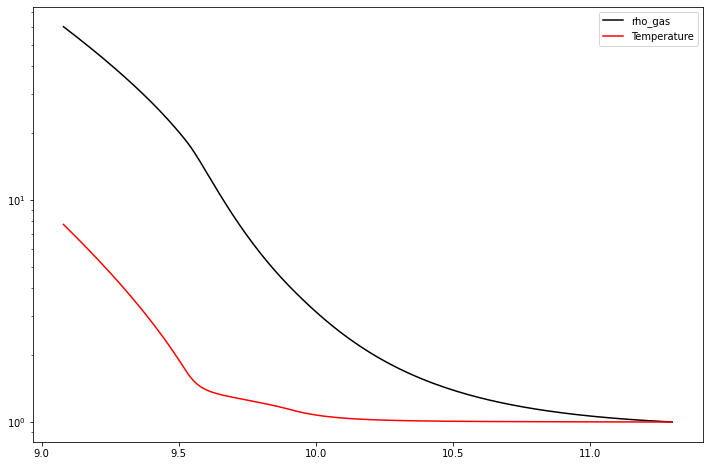

In [29]:
plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g']/rhodisk)**(1/3) , 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0 / Tdisk, 'r-', label='Temperature') 
plt.yscale('log')
plt.legend()

Envelope mass (g): 1.031275e+26


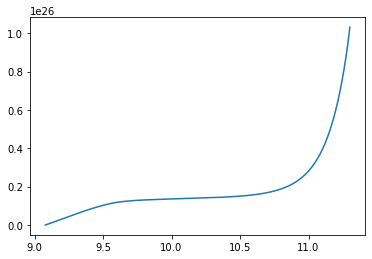

In [30]:
Env = np.zeros(len(R))

En = 4*np.pi*(np.exp(r)*r_0)**2 *rho_g 

m = En.evaluate()
m.require_grid_space()

for i in range(0, len(R)):
    Env[i] = np.trapz(m['g'][0:i], S[0:i]) 
    
    
plt.plot(R, Env)
env_mass = Env[-1]
print("Envelope mass (g): {:e}".format(env_mass))

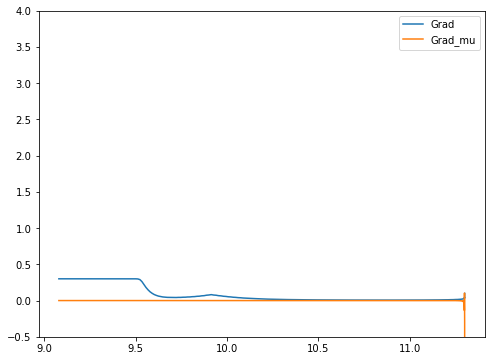

In [31]:
dlgZgr = lgZgr.differentiate('r')
dlgP = lgP.differentiate('r')

# Multiply dlgZgr by Zgr to get dZgr (as a proxy for dmu = d(1+Zgr) = dZgr)
grad_mu= dlgZgr['g']/ dlgP['g'] 
grad_mu *= np.exp(lgZgr['g'])

#grad_mu.evaluate()
#grad_mu.require_grid_space()

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
#plt.plot(R, dlgZgr['g'] / dlgP['g'], label='Grad_mu')
plt.plot(R, grad_mu, label='Grad_mu')
plt.ylim(-0.5, 4)
plt.legend()

(-4.0, 4.0)

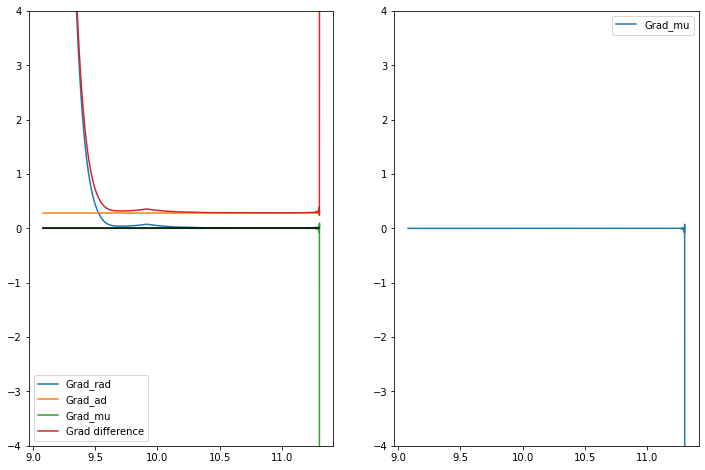

In [32]:
lgMu = np.log(1+np.exp(lgZgr))
dlgMu = log_basis.Differentiate(lgMu)
dlgP = log_basis.Differentiate(np.log(np.exp(lgP) *P_0))

grad_mu = dlgMu/dlgP

# grad_mu1 = np.diff( np.log(1+np.exp(lgZgr['g'])))/ np.diff(np.log(np.exp(lgP['g']) *P_0)) 
Grad_mu = grad_mu.evaluate()
Grad_mu.require_grid_space()

grad_diff = grad_rad - grad_mu - (-grad_ad) 
Grad_diff = grad_diff.evaluate() 
Grad_diff.require_grid_space() 


plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
# plt.plot(R, Grad_diff['g'])
# plt.plot(R,Grad_mu['g'])
plt.plot(R, Grad_rad['g'], label = 'Grad_rad')
plt.plot(R, grad_ad*np.ones(len(R)), label = 'Grad_ad')
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
plt.plot(R, Grad_diff['g'], label = 'Grad difference')
plt.plot(R, np.zeros(len(R)), 'k-') 
plt.legend()
plt.ylim((-4, 4))
plt.subplot(1,2,2)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
# plt.plot(R[1:], grad_mu1)
plt.legend()
plt.ylim((-4, 4))

In [33]:
# Plot R_0 for fingering convection
R_0 = (Grad['g'] - grad_ad)/Grad_mu['g']

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(R_0), label='log10(R_0)')
plt.plot(R, 0*R , 'k-', label='Zero_line')
#plt.ylim(-1.0, 1000.0)
plt.legend()


<ipython-input-33-47634ba53436>:5: RuntimeWarning: invalid value encountered in log10
  plt.plot(R, np.log10(R_0), label='log10(R_0)')


In [34]:
# Profile of nu and Xi for Prandtl number
c_gas=np.sqrt(8.32e7 * np.exp(lgt)*T_0 )
cross_sect_H2=2e-15 #cgs H2 cross section
lambda_mfp= 1./ (cross_sect_H2 * rho_gas['g'] / 2 / 1.67e-24)
nu_visc= lambda_mfp * c_gas

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(lambda_mfp), label='lambda_mfp')
plt.plot(R, np.log10(c_gas), label='c_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()       

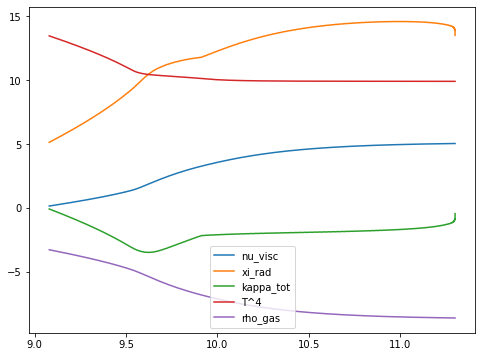

In [35]:
gas_gamma=7./5.
kappa_tot =  kappa.evaluate()
kappa_tot.require_grid_space()
#xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt['g'])*T_0)**4.  / rho_gas['g'] / np.exp(lgP['g']) 
xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt)*T_0)**4.  / rho_gas['g'] / kappa_tot['g']/ np.exp(lgP['g'])

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc), label='nu_visc')
plt.plot(R, np.log10(xi_rad), label='xi_rad')

plt.plot(R, np.log10(kappa_tot['g']), label='kappa_tot')

plt.plot(R, np.log10((np.exp(lgt)*T_0)**4.), label='T^4')
plt.plot(R, np.log10(rho_gas['g']), label='rho_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()

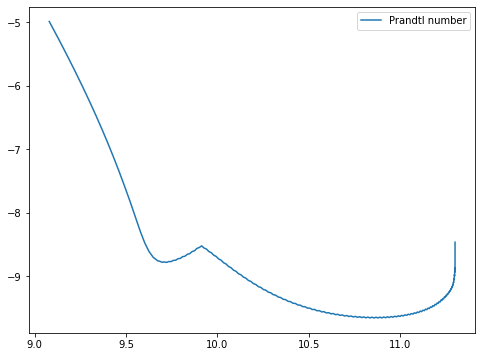

In [36]:
# Profile of Prandtl number
plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc/xi_rad), label='Prandtl number')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()

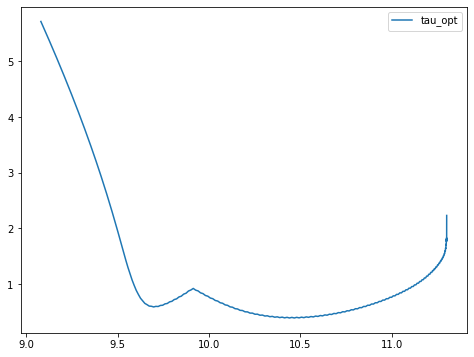

In [37]:
# Optical thickness to 'surface'
tau_opt= 10.**R * rho_gas['g'] *kappa_tot['g'] # Approximation to true integral of rho.dz

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(tau_opt), label='tau_opt')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()


In [38]:
plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'] - Grad_mu['g'] - grad_ad, label='Ledoux')
plt.plot(R, 0*R , label='Stability')
plt.ylim(-4, 1)
plt.legend()

# Oct 4 stuff

In [39]:
# This should be the mass 
plt.plot(R, Core_mass+Env)
plt.show()

In [40]:
Cs = cg.evaluate() # sound speed, which we previously used 
Cs.require_grid_space()
Cs = Cs['g']

Nth = np.sqrt((G*(Core_mass+Env)/(10**R)**2)**2/Cs**2*(grad_ad-Grad_rad['g'])) # I changed grad_rad to be positive now
d_finger= ((nu_visc*xi_rad)/Nth**2)**(1/4)
tau_cool = d_finger**2/xi_rad

Rgas = 8.32e7 / 2.3 # You gave me this value, but the wikipedia one in cgs doesnt have the /2.3 
Sigma = 5.7e-5
tau_cool_thin = Rgas/(16*kappa_tot['g']*Sigma*(np.exp(lgt)*T_0)**3)

Prandtl = nu_visc/xi_rad 

v_coll = d_finger/(np.sqrt(Prandtl)*tau_cool)

<ipython-input-40-66f5853697de>:5: RuntimeWarning: invalid value encountered in sqrt
  Nth = np.sqrt((G*(Core_mass+Env)/(10**R)**2)**2/Cs**2*(grad_ad-Grad_rad['g'])) # I changed grad_rad to be positive now


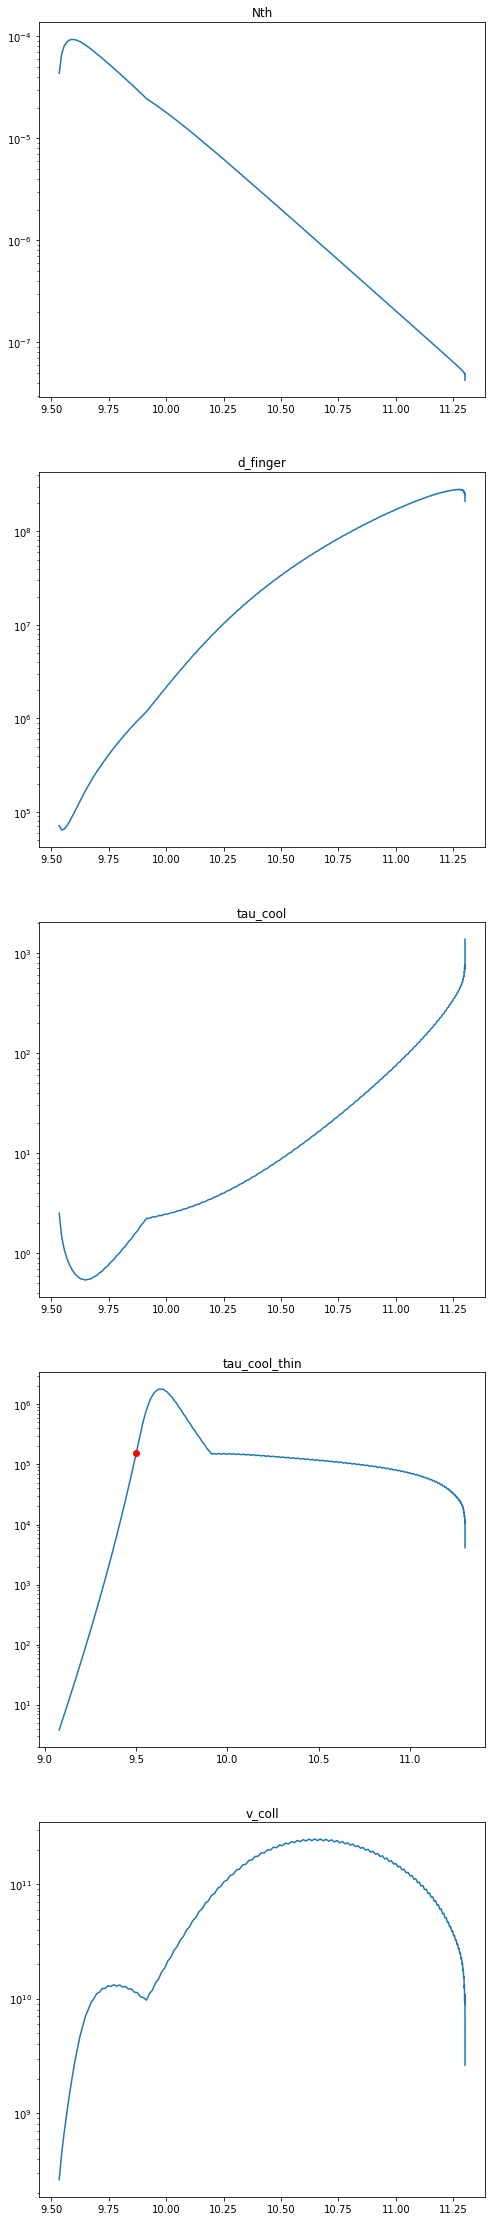

In [41]:
# red dot marks where grad transitions to grad_rad

plt.figure(figsize=(8,8*5))

plt.subplot(5,1,1)
plt.plot(R, Nth)
plt.plot(R[RCB], Nth[RCB], 'ro')
plt.yscale('log')
plt.title('Nth')

plt.subplot(5,1,2)
plt.plot(R,d_finger)
plt.plot(R[RCB], d_finger[RCB], 'ro')
plt.title('d_finger')
plt.yscale('log')

plt.subplot(5,1,3)
plt.plot(R,tau_cool)
plt.plot(R[RCB], tau_cool[RCB], 'ro')
plt.title('tau_cool')
plt.yscale('log')

plt.subplot(5,1,4)
plt.plot(R,tau_cool_thin)
plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.title('tau_cool_thin')
plt.yscale('log')

plt.subplot(5,1,5)
plt.plot(R,v_coll)
plt.plot(R[RCB], v_coll[RCB], 'ro')
plt.title('v_coll')
plt.yscale('log')

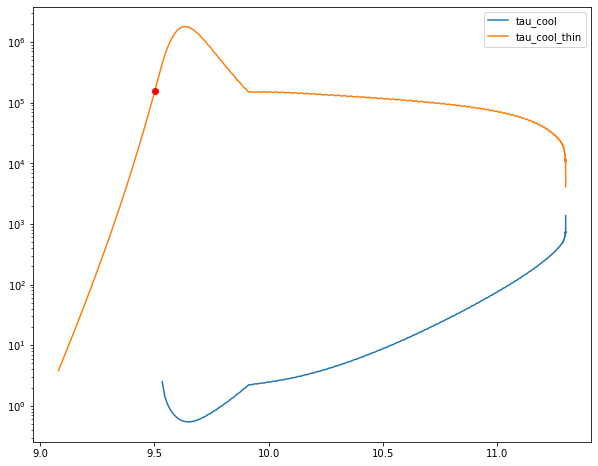

In [42]:
plt.figure(figsize=(10,8))
plt.plot(R,tau_cool, label='tau_cool')
plt.plot(R, tau_cool_thin, label='tau_cool_thin')
plt.plot(R[RCB], tau_cool[RCB], 'ro')
plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.yscale('log')
plt.legend()
plt.show()

In [43]:
np.savetxt("NPressure_dep.txt", lgP_list[-1])
np.savetxt("NTemperature_dep.txt", lgT_list[-1])
np.savetxt("NZgr_dep.txt", lgZgr_list[-1])
np.savetxt("NM_dep.txt", lgM_list[-1])
np.savetxt("Nm_dep.txt",  m_list[-1])
np.savetxt("NL_dep.txt", L_list[-1])

In [44]:
prefix = '1_1_'

np.savetxt('saved/'+prefix+'Ngrad.txt', Grad['g'])
np.savetxt('saved/'+prefix+'Ngrad_rad.txt', Grad_rad['g'])
np.savetxt('saved/'+prefix+'NTstop.txt', np.log10(TStop['g']))
np.savetxt('saved/'+prefix+'NTgrow.txt', np.log10(TGrow['g']))
np.savetxt('saved/'+prefix+'NTsettl.txt', Tsettl) 
np.savetxt('saved/'+prefix+'NZgr.txt', np.exp(lgZgr['g'])) 
np.savetxt('saved/'+prefix+'Nkappa_gr.txt', kappa_gr['g']) 
np.savetxt('saved/'+prefix+'Nsize.txt', size['g'])
np.savetxt('saved/'+prefix+'Nrho_gas_cbrt.txt', (rho_gas['g'])**(1/3))
np.savetxt('saved/'+prefix+'NTemperature.txt', np.exp(lgt)*T_0)
np.savetxt('saved/'+prefix+'NPress.txt', np.exp(lgt)*T_0 *rho_gas['g'])
np.savetxt('saved/'+prefix+'Nrho_gas_norm.txt', (rho_gas['g']/rhodisk)**(1/3))
np.savetxt('saved/'+prefix+'NTemperature_norm.txt',np.exp(lgt)*T_0 / Tdisk)
np.savetxt('saved/'+prefix+'NEnv.txt', Env)
np.savetxt('saved/'+prefix+'Ngrad_mu.txt', Grad_mu['g'])
np.savetxt('saved/'+prefix+'Ngrad_ad.txt', grad_ad*np.ones(len(R)))
np.savetxt('saved/'+prefix+'Ngrad_diff.txt',  Grad_diff['g'])
np.savetxt('saved/'+prefix+'Nlog10(R_0).txt',  np.log10(R_0))
np.savetxt('saved/'+prefix+'Nlambda_mfp.txt',  np.log10(lambda_mfp))
np.savetxt('saved/'+prefix+'Nc_gas.txt',  np.log10(c_gas))
np.savetxt('saved/'+prefix+'Nnu_visc.txt',  np.log10(nu_visc))
np.savetxt('saved/'+prefix+'Nxi_rad.txt',  np.log10(xi_rad))
np.savetxt('saved/'+prefix+'Nkappa_tot.txt',  np.log10(kappa_tot['g']))
np.savetxt('saved/'+prefix+'NTfourth.txt',  np.log10((np.exp(lgt)*T_0)**4.))
np.savetxt('saved/'+prefix+'Nrho_gas.txt',  np.log10(rho_gas['g']))
np.savetxt('saved/'+prefix+'NPrandtl_number.txt',  np.log10(nu_visc/xi_rad))
np.savetxt('saved/'+prefix+'Ntau_opt.txt',  np.log10(tau_opt))
np.savetxt('saved/'+prefix+'NLedoux.txt',  Grad['g'] - Grad_mu['g'] - grad_ad)
d_finger
Nth
tau_cool
tau_cool_thin
np.savetxt('saved/'+prefix+'NR.txt', R)

<ipython-input-44-d0de884ecbab>:20: RuntimeWarning: invalid value encountered in log10
  np.savetxt('saved/'+prefix+'Nlog10(R_0).txt',  np.log10(R_0))


In [45]:
np.savetxt('saved/NR.txt', R)